In [1]:
import os
os.chdir(os.path.expanduser('~/FFF/'))
import fff
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import pickle as pkl
import umap
matplotlib.rcParams.update({'font.size': 18})

INFO: Using pytorch backend
/tmp/ipykernel_1157102/583152811.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
N = 100000
dim = 2
rand_z = torch.randn([N, dim])
rand_z2 = torch.randn([N, dim])
dist = (rand_z - rand_z2)**2
dist = torch.sqrt(torch.sum(dist, dim=1) / dim)
print(dist.shape)
dist_std, dist_m = torch.std_mean(dist)
print(dist_std/np.sqrt(float(N)), dist_m)

torch.Size([100000])
tensor(0.0021) tensor(1.2529)


In [2]:
classifier = False

In [3]:
df_class = pd.read_pickle("data/EMnist_Class")

df = pd.read_pickle("data/16EMnist_F3F")
# read targets and conditions from dataframe
train_data, train_targets = (
    torch.from_numpy(df["train_x"]),
    torch.from_numpy(df["train_y"]),
)

center = torch.mean(train_targets)
std = torch.std(train_targets)

train_l, test_l = (
    torch.from_numpy(df_class["train_l"]),
    torch.from_numpy(df_class["test_l"]),
)
train_l = torch.argmax(train_l, dim=1)
test_l = torch.argmax(test_l, dim=1)

In [4]:
if classifier:
    GTa = fff.FreeFormInjectiveFlow.load_from_checkpoint(
        "GTs/16Mnist_Class/checkpoints/last.ckpt"
    ).eval()
    GT = fff.utils.truncate.Truncate(GTa)
else:
    GT = fff.FreeFormInjectiveFlow.load_from_checkpoint(
    #"GTs/16Mnist_F3F/checkpoints/best.ckpt"
    "GTs/16Mnist_F3F/checkpoints/last.ckpt"
    #"GTs/16Mnist_F16F/checkpoints/last.ckpt"
    #"lightning_logs/28x28/version_3/checkpoints/last.ckpt"
    ).eval()
    GTa = GT

torch.Size([240000, 1, 16, 16])
cond_dim:  0
latent_dim:  3
[100, 32, 32, 100]
[100, 32, 32, 100]
[100, 32, 32, 100]
[100, 32, 32, 100]


In [5]:
if classifier:
    model = fff.FreeFormInjectiveFlow.load_from_checkpoint(
        "lightning_logs/cl_i_uncond/version_1/checkpoints/last.ckpt"
        #epoch=99-step=11600.ckpt"
    )
else:
    model = fff.FreeFormInjectiveFlow.load_from_checkpoint(
        "lightning_logs/3_f61f_01/version_3/checkpoints/last.ckpt"
    )

torch.Size([5000, 256])
cond_dim:  0
latent_dim:  64
[100, 512, 512, 100]
[100, 512, 512, 100]
[100, 512, 512, 100]
[100, 512, 512, 100]
load models checkpoint
cond_dim:  3
latent_dim:  61
[67, 512, 512, 67]
[67, 512, 512, 67]
[67, 512, 512, 67]
[67, 512, 512, 67]
[67, 512, 512, 67]
[67, 512, 512, 67]
Teacher is Autoencoder
torch.Size([240000, 1, 16, 16])
cond_dim:  0
latent_dim:  3
[100, 32, 32, 100]
[100, 32, 32, 100]
[100, 32, 32, 100]
[100, 32, 32, 100]


In [6]:
torch.set_grad_enabled(False)

tensor([[-0.5736,  1.7434,  0.7783],
        [ 0.6681, -0.6047, -0.0502],
        [ 1.4125, -0.4720, -0.1048],
        [ 1.0232, -0.1050, -0.1999],
        [-0.7965,  0.1464,  1.7037],
        [-0.1625,  0.3275,  0.4016],
        [-0.1291,  0.5252,  0.1038],
        [-0.7193, -1.9071, -0.7429],
        [-0.4474,  1.5959,  0.8551],
        [-0.6564,  0.9506,  0.6309]])
encoding...
torch.Size([40000, 64])
61
reconstructing...
sampling...
plotting
torch.Size([40000, 61])
main detail standard deviation:  tensor(1.0182)
2nd detail standard deviation:  tensor(1.0498)


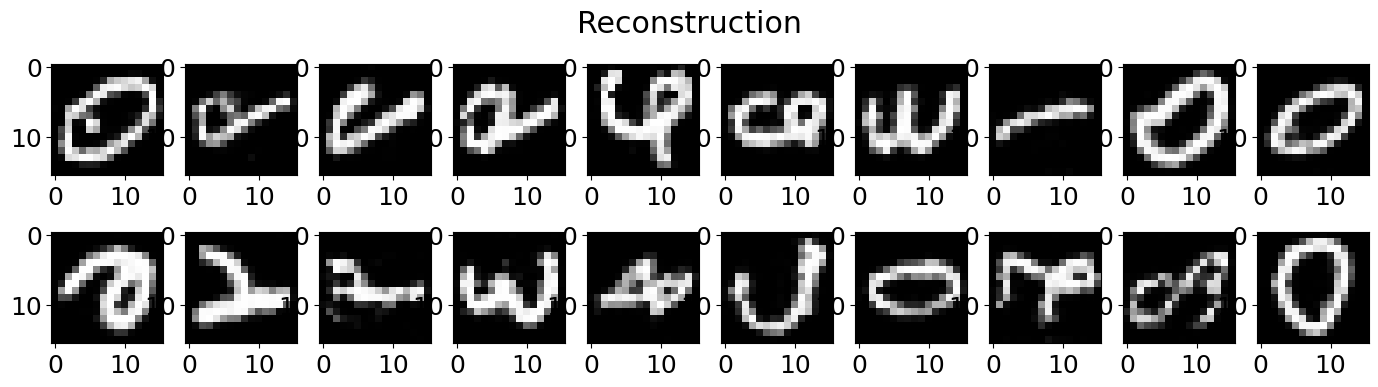

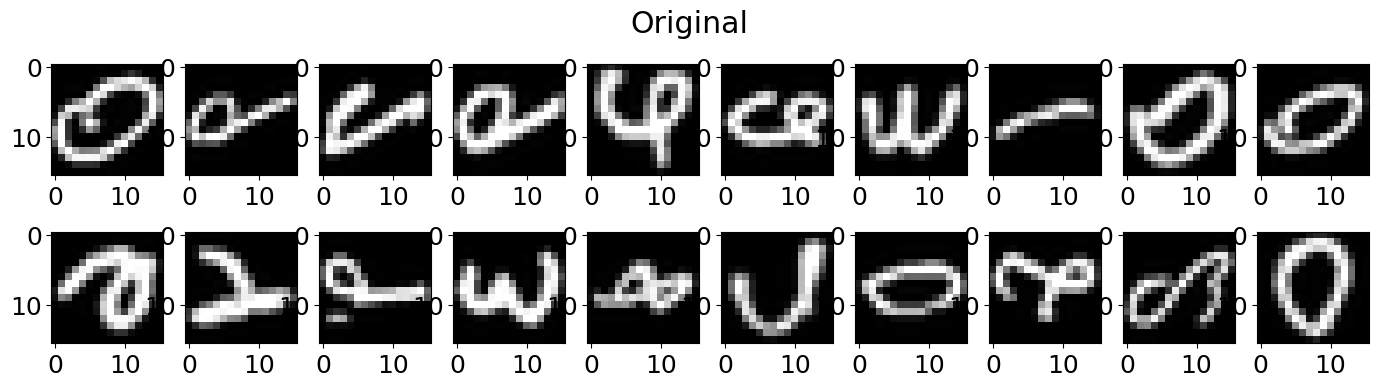

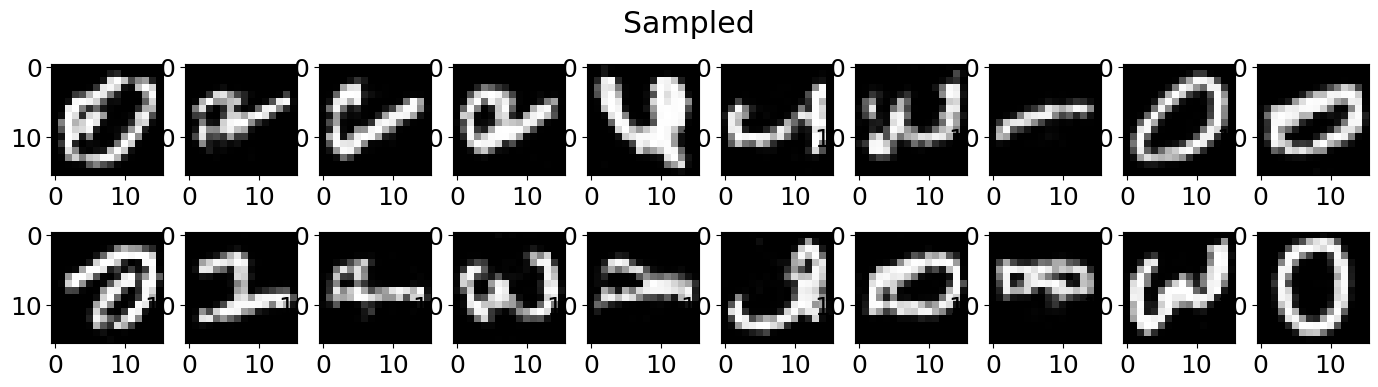

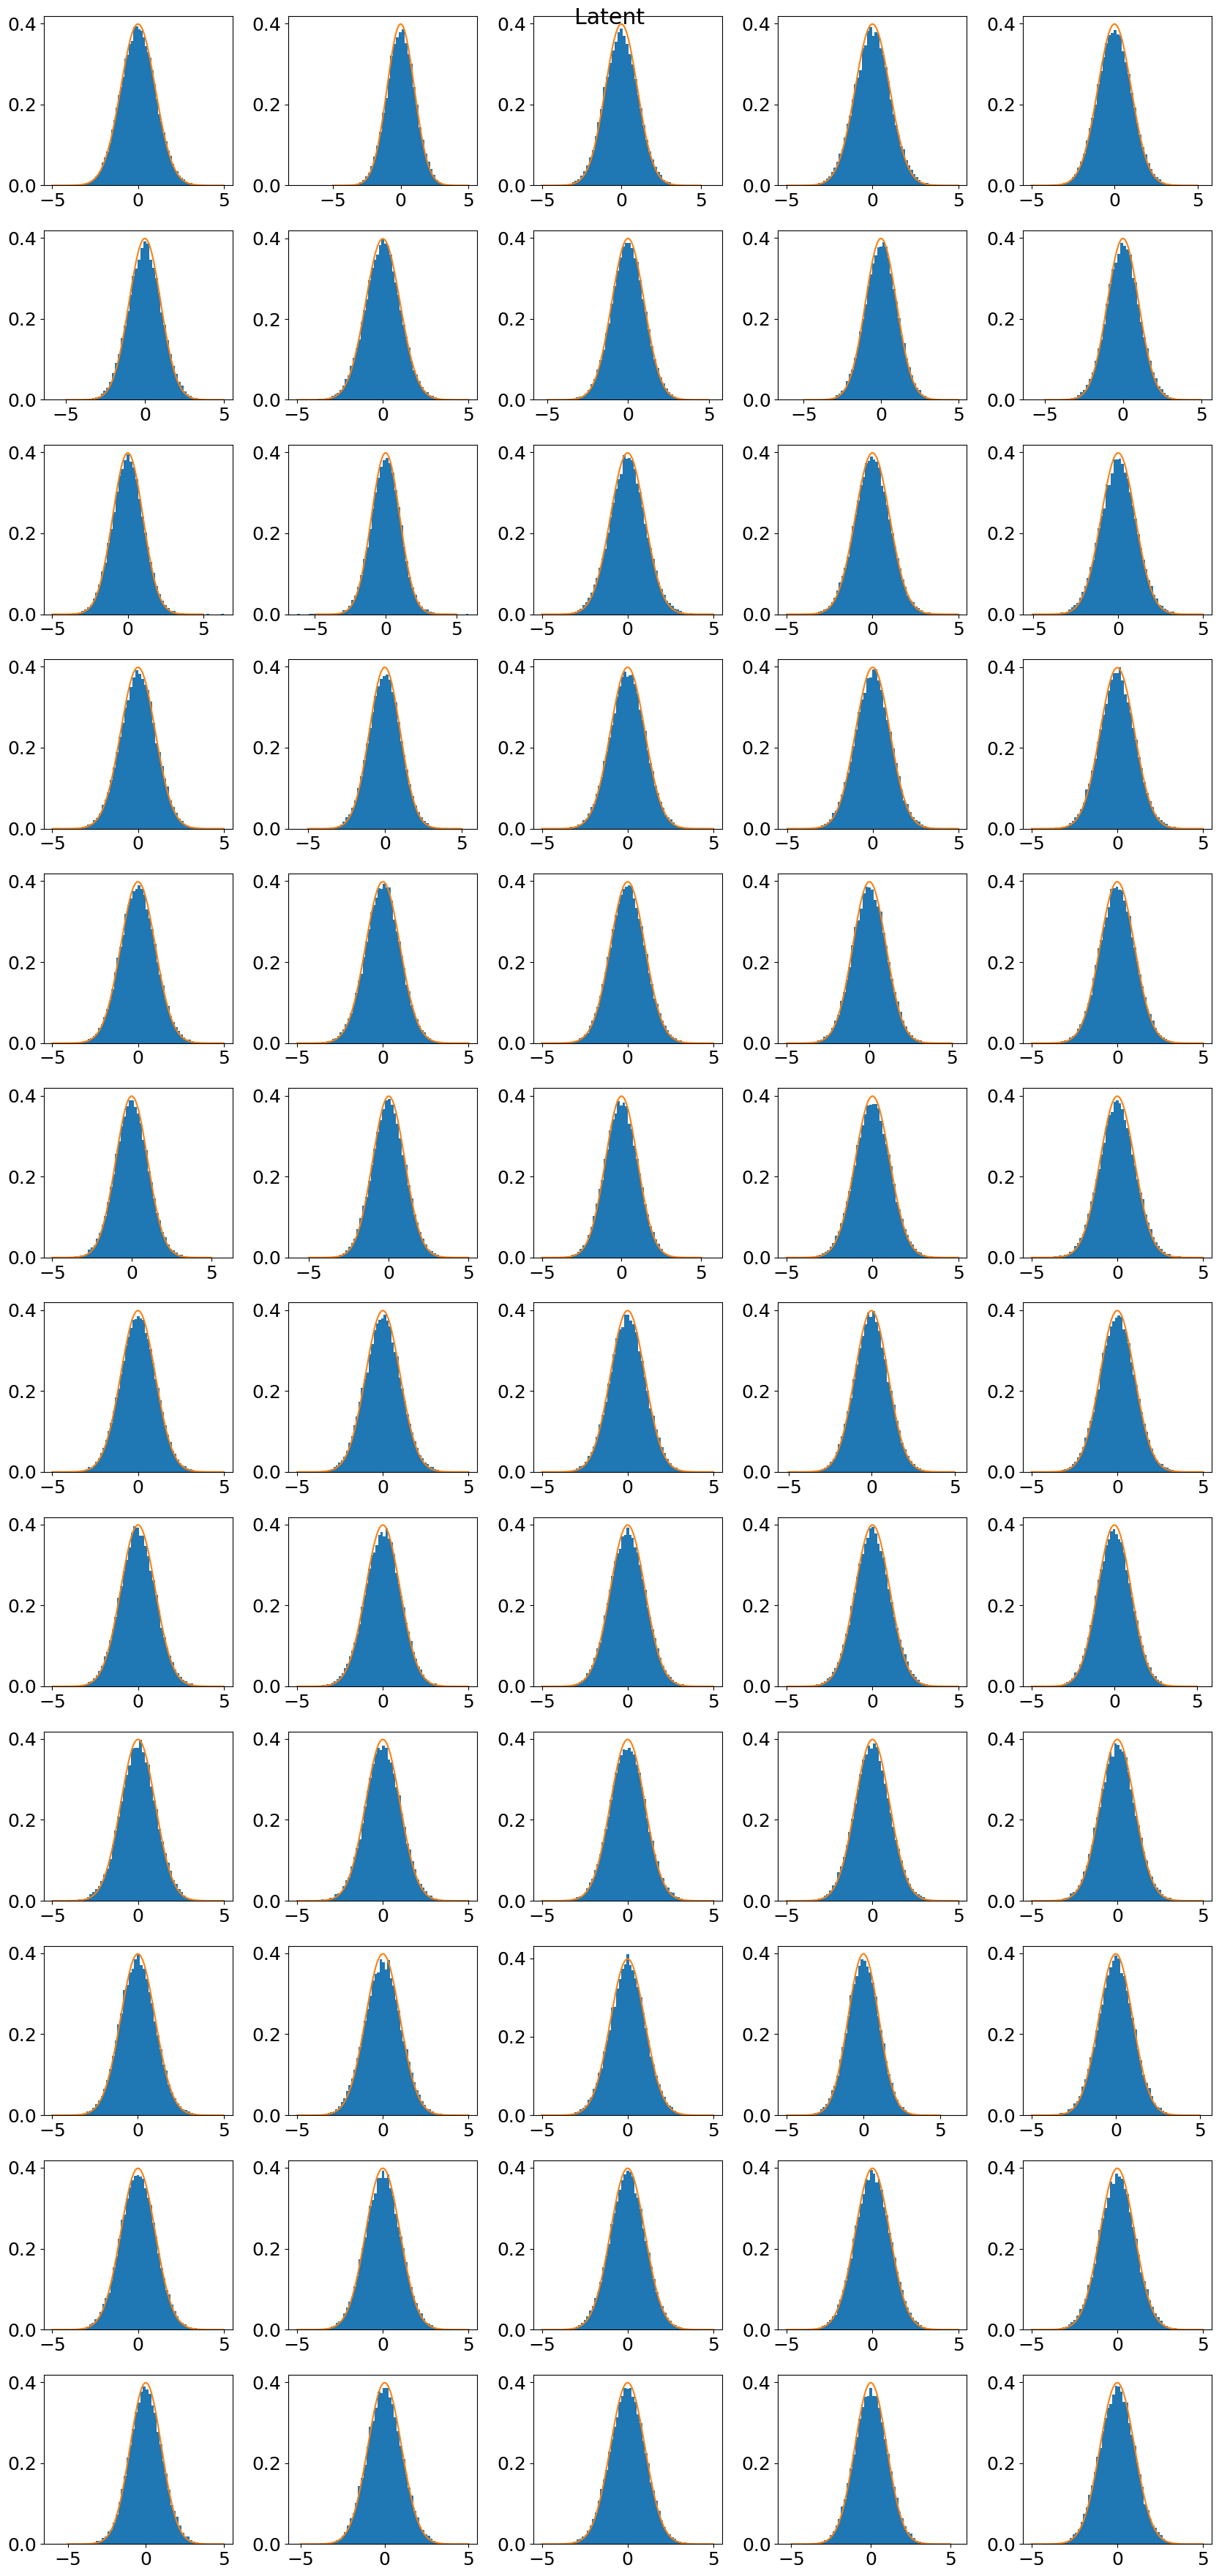

In [17]:
save = False
plot_dir = "emnist/F3F/fif/01"
from pathlib import Path
if save:
    Path(f"plots/{plot_dir}").mkdir(parents=True, exist_ok=True)
data = plot_mnist(model)
if model.transform == "diffusion":
    z_dim = 64
    std_z0 = 1
else:
    z_test = data["test_z_dense"]
    z_dim = z_test.shape[1]
    std_z0 = torch.std(z_test[:,0])
    print("main detail standard deviation: ", std_z0)
    print("2nd detail standard deviation: ", torch.std(z_test[:,1]))
latent_dim = max(1, data["test_c"].shape[1])
#latent_dim = 3
#std_z0 = 1

tensor(1.1367)


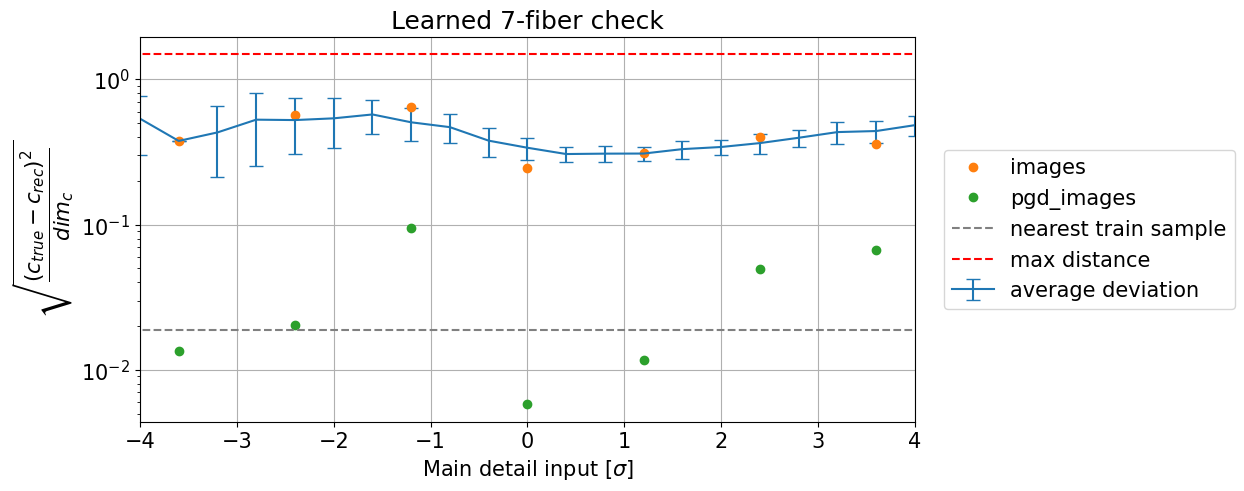

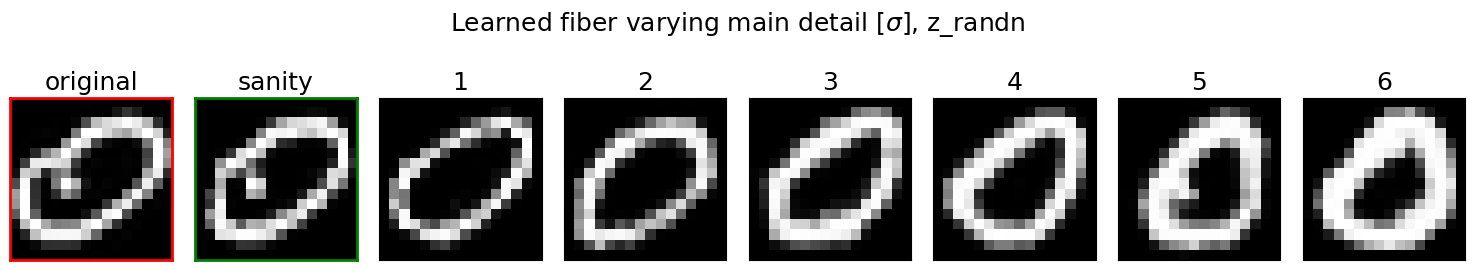

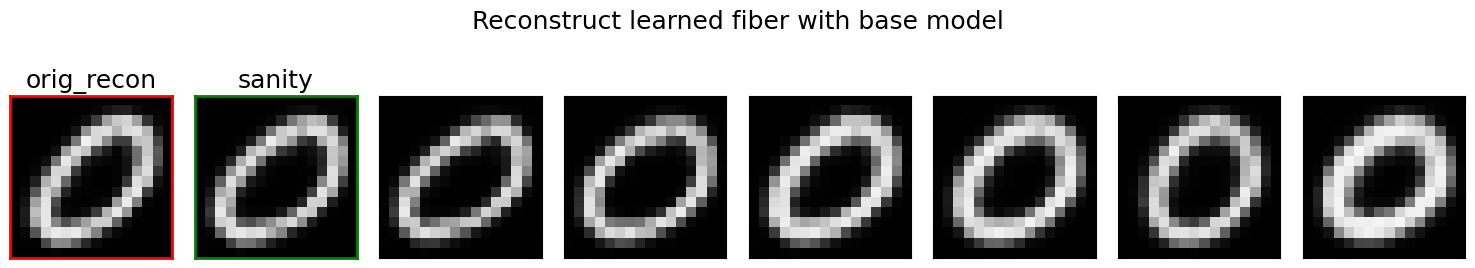

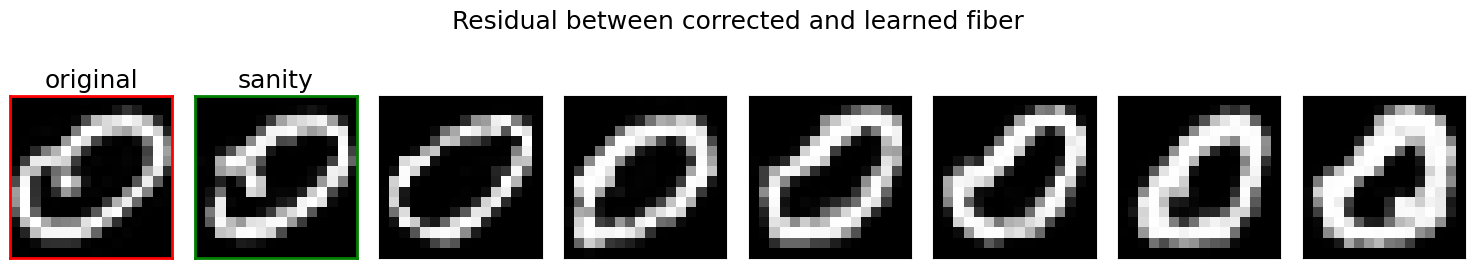

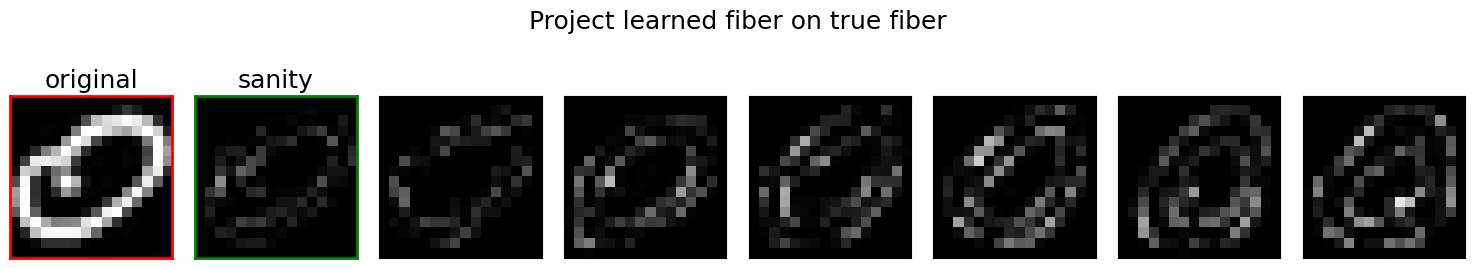

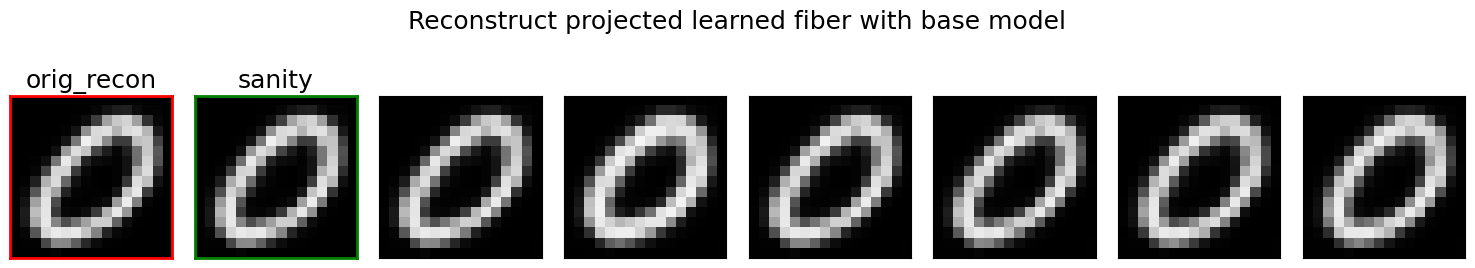

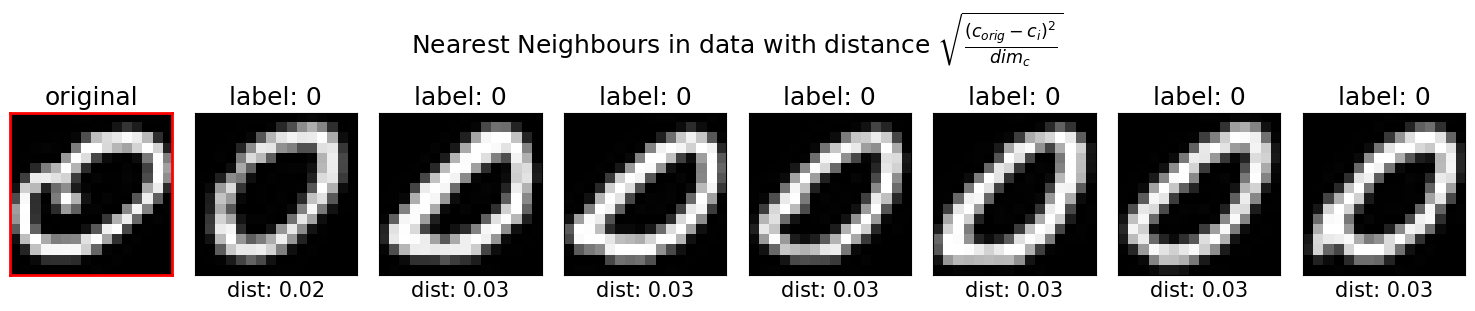

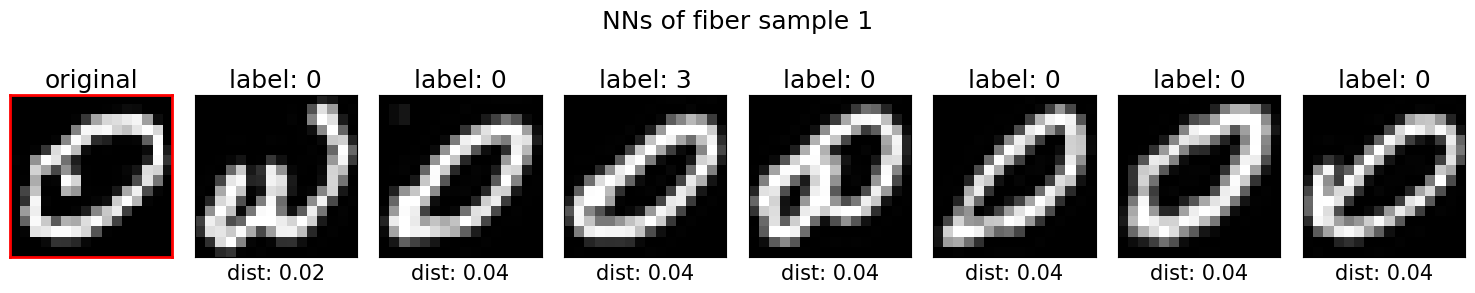

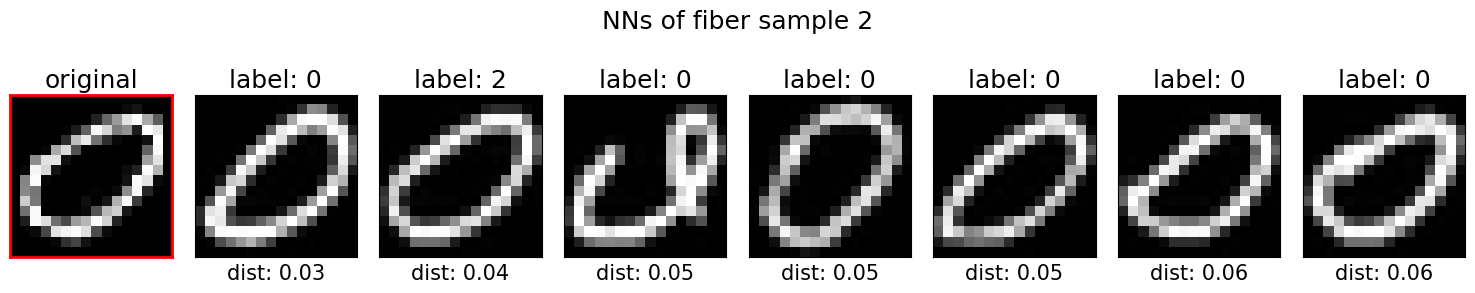

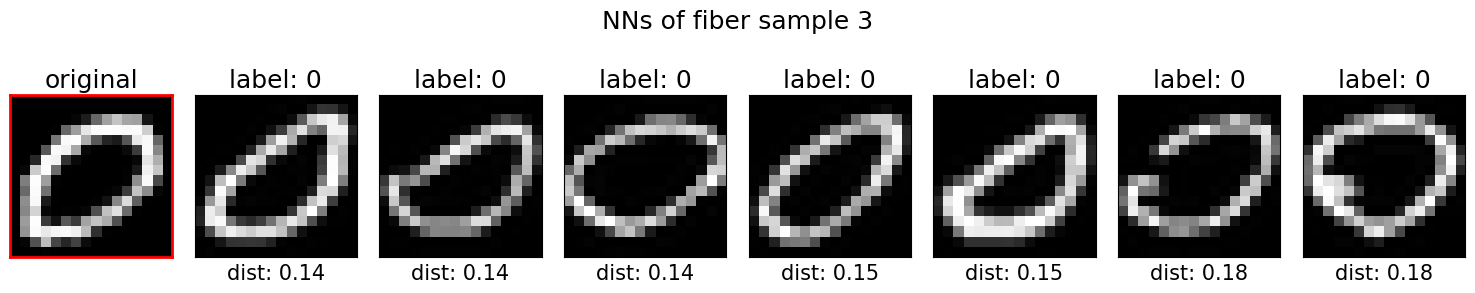

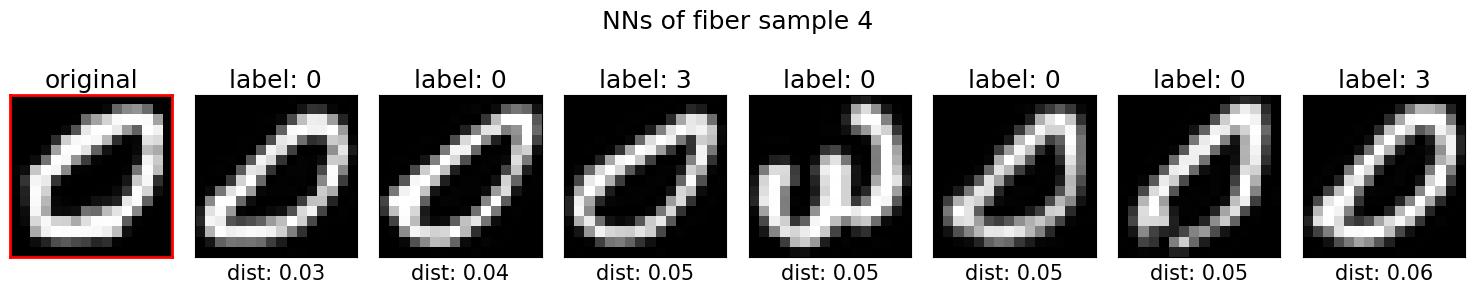

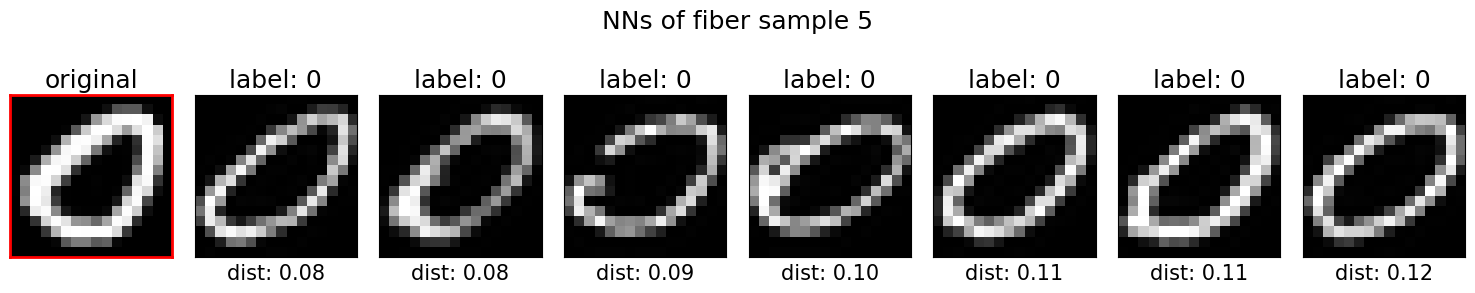

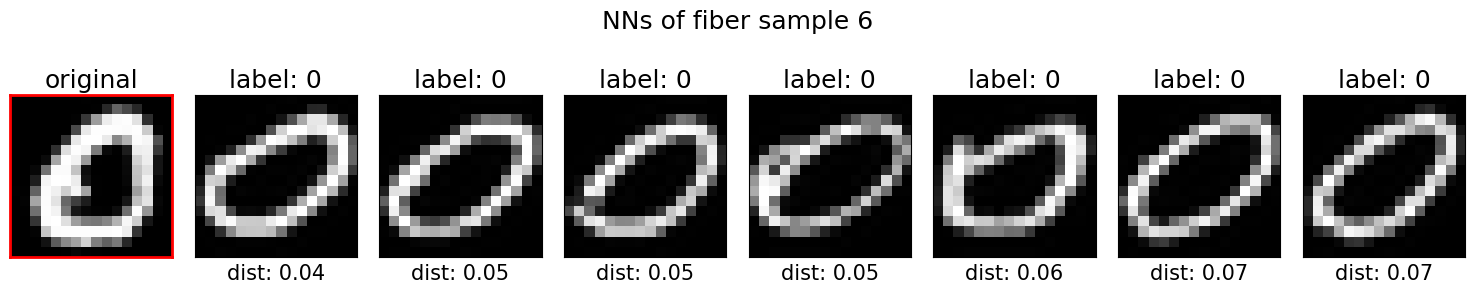

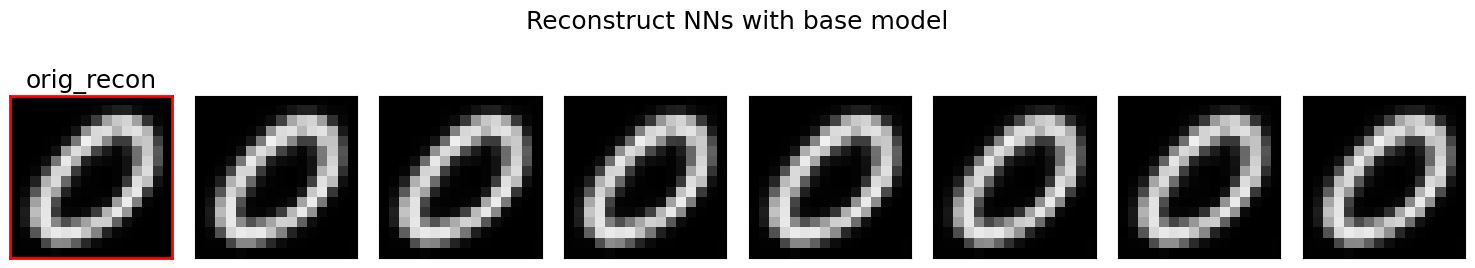

In [65]:
zrange = 4*std_z0
matplotlib.rcParams.update({'font.size': 15})
nums = [7,2,1,0,4,1,4,9,5,9,0,6,9,0,1,5,9,7,3,4,0,0,0,0,0,0,0,0,0,0,0,0]
ran = [0]
#ran = [0]

for j in range(1):
    plot_details(model, data, j, zrange, GD_steps=20, sanity=True)

In [66]:
def plot_details(model2plot, data, i_sample, zrange, GD_steps=100, sanity=False):
    device = model2plot.device
    
    pos_min, pos_max = -zrange, zrange
    c = data["test_c"]
    #z = data["test_z_dense"]
    train_c = data["train_c"]
    train_samples = data["train_samples"]
    test_samples = data["test_samples"]
    N = 21
    n = 7
    ddim = z_dim
    x_orig = test_samples[i_sample]

    # calculate x_c_x
    if classifier:
        conditioned = GTa.apply_conditions((train_samples,torch.zeros((train_samples.shape[0],0),device=test_samples.device)))
    else:
        conditioned = GT.apply_conditions((train_samples,))
    c_GT = conditioned.condition
    x_GT = conditioned.x0
    y_GT = torch.cat([
        GT.encode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(x_GT.split(512), c_GT.split(512))
    ])
    train_c_GT = (y_GT  - center) / std
    # calculate x_c_x
    if classifier:
        conditioned = GTa.apply_conditions((test_samples,torch.zeros((test_samples.shape[0],0),device=test_samples.device)))
    else:
        conditioned = GT.apply_conditions((test_samples,))
    c_GT = conditioned.condition
    x_GT = conditioned.x0
    y_GT = torch.cat([
        GT.encode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(x_GT.split(512), c_GT.split(512))
    ])
    x_test_GT = GTa.decode(y_GT.to(device), c_GT.to(GTa.device)).detach().cpu()
    xcx = x_test_GT[i_sample]
    c_GT = (y_GT  - center) / std

    # calculate Nearest Neighbours
    verify = c_GT[i_sample]
    NN, similar, NN_suptitle, NN_titles = calc_NNs(verify, train_c_GT, train_samples, n+1)
    
    #calculate walk along 0th detail dimension with sampled rest
    z0_range = torch.linspace(pos_min, pos_max, N)
    #z0_sample = z[i_sample][0].numpy()

    new_details_norm = torch.randn(40,N,ddim-1)
    z0_range_norm = torch.unsqueeze(z0_range,0)
    z0_range_norm = z0_range_norm.repeat(40,1)
    new_details_norm = torch.cat([torch.unsqueeze(z0_range_norm,2), new_details_norm], dim=2)
    new_details_norm = torch.reshape(new_details_norm, (40*N,ddim))
    vz_dense = new_details_norm
    #print(torch.reshape(new_details_norm, (40,N,100))[0,:,0])
    
    #decoding...
    c_sample_GT = torch.unsqueeze(c_GT[i_sample], dim=0)
    c_sample = torch.unsqueeze(c[i_sample], dim=0)
    c_sample_norm = c_sample.repeat(40*N,1)
    c_sample_norm0 = torch.empty((c_sample_norm.shape[0], 0), dtype=c_sample.dtype)
    c_sample = c_sample_GT.repeat(N,1)

    if model2plot.transform == "diffusion":
        vz = model2plot.get_latent(device).sample((40*N,), c_sample_norm.to(device)).detach().cpu()
    else:
        vz = model2plot.transform_model.decode(new_details_norm.to(device), c_sample_norm.to(device)).detach().cpu()
    #vz = model2plot.get_latent(device).sample((40*N,), c_sample_norm.to(device)).detach().cpu()
    #vz = torch.randn_like(vz)
    if sanity==True:
        z_orig = model2plot.encode(test_samples[i_sample].to(device), torch.empty(0).to(device))[0].cpu()
        z_orig = z_orig + torch.randn_like(z_orig) * 0.01
        z_orig_rep = z_orig.repeat([40,1])
        vz = vz.reshape([40,N,-1])
        vz[:,1,:] = z_orig_rep
        vz = vz.reshape([40*N,-1])
    vx = model2plot.decode(vz.to(device), c_sample_norm0.to(device)).detach().cpu()
    
    #plotting...
    D_plt_F = {"ind": i_sample, "mark_first": "original", "mark_second": sanity, "n": n+1, "save_name": "0v_x"}
    i_plot = np.arange(n) * N//n + 1
    D_plt_F["x_plot"] = torch.cat((x_orig.unsqueeze(0), vx[i_plot].detach().cpu()), dim=0)
    #D_plt_F["title_plot = torch.cat((torch.Tensor([z0_sample.item()]), (new_details_norm[i_plot,0]/std_z0)), dim=0)
    D_plt_F["suptitle"] = r"Learned fiber varying main detail [$\sigma$], z_randn"
    D_plt_F["titles"] = [0,0,1,2,3,4,5,6,7,8,9]

    # calculate GTs reconstructions
    vxc, D_plt_GT = plot_GT(i_sample, vx, xcx, i_plot, n)
    D_plt_GT["mark_second"] = sanity

    res_pgd = None
    if GD_steps>0:
        # calc PGD and plot PGD
        vxpx, res_pgd, D_plt_PGD, D_plt_PGD_res = plot_PGD(i_sample, vz[i_plot], vx[i_plot], x_orig, c_sample_GT[0], n+1, GD_steps)
        D_plt_PGD["mark_second"] = sanity
        D_plt_PGD_res["mark_second"] = sanity
        # plot GT(x_PGD)
        _, D_plt_PGT = plot_GT(i_sample, vxpx, xcx, range(n), n, name="PGD")
        D_plt_PGT["mark_second"] = sanity

    # plot check fiber
    title_fiber = f"Learned {nums[i_sample]}-fiber check"
    plot_fiber_check(vxc, c_sample, NN, title_fiber, i_plot, res_pgd, N)

    paths = []
    paths.append(plot_images(**D_plt_F))
    paths.append(plot_images(**D_plt_GT))
    if GD_steps>0:
        paths.append(plot_images(**D_plt_PGD))
        paths.append(plot_images(**D_plt_PGD_res))
        paths.append(plot_images(**D_plt_PGT))

    # plot NNs
    NN_plot = torch.cat((x_orig.unsqueeze(0), similar), dim=0)
    paths.append(plot_images(i_sample, NN_plot, titles=NN_titles, suptitle=NN_suptitle, n=n+1, save_name="4NNs", mark_first= "original"))
    # calculate NNs of fiber samples
    for i in range(6):
        _, nns, NN_suptitle_i, NN_titles_i = calc_NNs(vxc[i], train_c_GT, train_samples, n+1)
        NN_plot_i = torch.cat((vx[i_plot][i].detach().cpu().unsqueeze(0), nns), dim=0)
        paths.append(plot_images(i_sample, NN_plot_i, titles=NN_titles_i, suptitle=f"NNs of fiber sample {i+1}", n=n+1, save_name=f"6NNs{i+1}", mark_first= "original"))
    _, D_plt_NN = plot_GT(i_sample, similar, xcx, range(n), n, name="NNs")
    paths.append(plot_images(**D_plt_NN))
    if save:
        out_path = f"plots/{plot_dir}/{nums[j]}_stacked.png"
        stack_images_vertically(paths, out_path)

In [8]:
def plot_GT(i_sample, x, x_orig, i_plot, n, name="learned"):
    plot_dict = {"ind": i_sample, "n": n+1, "mark_first": "orig_recon"}
    if classifier:
        conditioned = GTa.apply_conditions((x,torch.zeros((x.shape[0],0),device=x.device)))
    else:
        conditioned = GT.apply_conditions((x,))
    c_GT = conditioned.condition
    x_GT = conditioned.x0
    xc = GT.encode(x_GT.to(GTa.device), c_GT.to(GTa.device))
    xcx = GTa.decode(xc, c_GT.to(GTa.device))
    xc = (xc.detach().cpu() - center) / std

    # plotting reconstructions
    plot_dict["x_plot"] = torch.cat((x_orig.detach().cpu().unsqueeze(0), xcx.detach().cpu()[i_plot]), dim=0)
    #x_plot = fiber_rec[i_plot].detach().cpu()
    if name=="learned":
        plot_dict["save_name"] = "1v_x_px_x"
        plot_dict["suptitle"] = "Reconstruct learned fiber with base model"
    elif name=="PGD":
        plot_dict["save_name"] = "3v_x_c_x"
        plot_dict["suptitle"] = "Reconstruct projected learned fiber with base model"
    elif name=="NNs":
        plot_dict["save_name"] = "5NN_c_x"
        plot_dict["suptitle"] = "Reconstruct NNs with base model"
    
    return xc, plot_dict

In [56]:
def plot_PGD(i_sample, z, x, x0, c0, n, n_steps=100):
    plot_dict = {"ind": i_sample, "mark_first": "original", "save_name": "2v_x_px", "n": n}
    px = []
    res = []
    px.append(x0.unsqueeze(dim=0))
    for zi, xi in zip(z,x):
        pxi, resi = calc_PGD(zi, xi, x0, c0, steps=n_steps)
        px.append(pxi)
        res.append(resi)

    px = torch.cat(px,dim=0)
    res = torch.cat(res,dim=0).detach().cpu()
    plot_dict["suptitle"] = "Project learned fiber on true fiber"
    plot_dict["x_plot"] = px.clone()
    plot_dict_res = plot_dict.copy()
    plot_dict_res["x_plot"] = px.clone()
    plot_dict_res["save_name"] = "2v_x_px_res"
    plot_dict_res["x_plot"][1:] = torch.abs(plot_dict["x_plot"][1:] - x)
    plot_dict["suptitle"] = "Residual between corrected and learned fiber"
    #print(torch.max(plot_dict["x_plot"][1:],dim=1).values)
    return px[1:], res, plot_dict, plot_dict_res

In [59]:
def calc_NNs(verify, train_c, train_samples, n=8):
    # calculate Nearest Neighbours
    diff = train_c - verify
    diff = torch.sqrt(torch.sum(torch.square(diff), dim =1)/latent_dim)
    ind = torch.argsort(diff)[:n]
    diff = diff[ind]
    #print("squared distance between chosen sample and nearest train samples:", squared_diff[ind]/5)
    similar = train_samples[ind]
    labels = train_l[ind].numpy()
    NN = diff[0].numpy()
    diff_round = np.empty_like(diff.numpy())
    np.round(diff.numpy(),2, diff_round)

    # plot NNs
    suptitle = r"Nearest Neighbours in data with distance $\sqrt{\frac{(c_{orig}-c_i)^2}{dim_c}}$"
    #def title_func(label, distance):
    #    return f"lab: {label}, dist: {distance:.2f}"
    titles = (labels, diff_round)
    #plot_images(i_sample, similar, titles=titles, suptitle=suptitle)
    
    #dist = torch.sqrt(torch.sum((similar[:-1]-similar[1:])**2,-1))
    #print(dist)
    return NN, similar, suptitle, titles

In [33]:
def plot_images(ind, x_plot, n=8, titles=None, suptitle=None, mark_first=False, mark_second=False, save_name=None):
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(15, 3))
    for i in range(n):
        axes[i].imshow(x_plot[i].detach().cpu().reshape(16, 16), cmap='gray', vmin=0, vmax=1)
        axes[i].xaxis.set_tick_params(labelbottom=False)
        axes[i].yaxis.set_tick_params(labelleft=False)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        if isinstance(titles, np.ndarray):
            axes[i].set_title(titles[i])
        elif isinstance(titles, tuple) and i>0:
            axes[i].set_title(f"label: {titles[0][i]}")
            axes[i].set_xlabel(f"dist: {titles[1][i]:.2f}")
        elif titles != None:
            axes[i].set_title(titles[i])
    if mark_first:
        for spine in axes[0].spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(2)
        axes[0].set_title(mark_first)
    if mark_second:
        for spine in axes[1].spines.values():
            spine.set_edgecolor('green')
            spine.set_linewidth(2)
        axes[1].set_title("sanity")
    if suptitle != None:
        fig.suptitle(suptitle)
    fig.tight_layout()
    path = f"plots/{plot_dir}/{nums[ind]}_{save_name}.png"
    if save:
        plt.savefig(path, bbox_inches='tight')
    return path

In [36]:
def plot_fiber_check(check_fiber, c_sample, NN, title, i_plot, delta2, N, upperbound=True):
    
    delta_coarse = torch.sqrt(torch.sum((check_fiber-c_sample.repeat(40,1))**2, dim=1)/latent_dim)
    print(torch.max(delta_coarse.reshape(40,-1)))
    delta_c_std, delta_c = torch.std_mean(delta_coarse.reshape(40,-1), dim=0)
    delta_c = delta_c.numpy()
    delta_details = np.linspace(-zrange,zrange,N)/std_z0
    
    #plotting...
    plt.figure(figsize=[10,5])
    plt.errorbar(delta_details,delta_c,yerr=delta_c_std, label="average deviation",capsize=5)
    plt.plot(delta_details[i_plot],delta_coarse[i_plot], marker='o', label="images", linestyle='')
    if delta2!=None:
        plt.plot(delta_details[i_plot],delta2[:i_plot.shape[0]], marker='o', label="pgd_images", linestyle='')
    
    plt.axhline(y=NN, xmin=-10, xmax=10, color='gray', linestyle="--", label='nearest train sample')
    if upperbound==True:
        plt.axhline(y=1.49, xmin=-10, xmax=10, color='red', linestyle="--", label='max distance')
    plt.title(title)
    plt.ylabel(r"$\sqrt{\frac{(c_{true}-c_{rec})^2}{dim_c}}$", fontsize=22)
    plt.legend(bbox_to_anchor=(1.01, 0.5), borderaxespad=1)
    plt.xlabel(r"Main detail input [$\sigma$]")
    plt.yscale("log")
    #plt.ylim(0, 1.6)
    plt.xlim((-zrange/std_z0,zrange/std_z0))
    plt.grid()
    if save:
        plt.savefig(f"plots/{plot_dir}/{nums[j]}deviations.png", bbox_inches='tight')

In [13]:
def calc_GD_dense(z_dense, x, x0, c0, steps=100):
    torch.set_grad_enabled(True)
    z_dense = torch.unsqueeze(z_dense,dim=0)
    constraint = torch.sqrt(torch.sum(((x0 - x)**2), dim=-1))
    #print("distance: x_original - x_fiber: ", constraint.item())
    c0 = torch.unsqueeze(c0,dim=0)
    
    def closs(c0, c_hat, x_hat):
        v = torch.sqrt(torch.sum(((c0 - c_hat)**2), dim=-1))/latent_dim
        #distance = torch.sqrt(torch.sum(((x_hat.detach().cpu() - vx[0])**2), dim=-1))
        #r = torch.max(torch.Tensor([0., (distance - constraint).item()]))
        #print("loss:", v.item())
        #if r != 0:
        #    print("penalty:", r.item())
        return v
    
    class ZModel(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.param = torch.nn.Parameter(z_dense.clone())
    
    zmodel = ZModel()
    optimizer = torch.optim.Adam(zmodel.parameters(), lr=0.05)
    max_z = torch.max(torch.abs(zmodel.param)).detach()
    max_z_i = torch.argmax(torch.abs(zmodel.param))
    print(max_z)
    print(max_z_i)
    
    c_empty = torch.empty((0,), device=model.device, dtype=x.dtype)
    for i in range(steps):
        z = model.transform_model.decode(zmodel.param.to(model.device), c_empty)
        zx = model.decode(z.to(model.device), c_empty)
        if classifier:
            conditioned = GTa.apply_conditions((zx,torch.zeros((zx.shape[0],0),device=zx.device)))
        else:
            
            conditioned = GT.apply_conditions((zx,))
        c_GT = conditioned.condition
        x_GT = conditioned.x0
        zxc = (GT.encode(x_GT, c_GT).cpu() - center) / std
        loss = closs(c0, zxc, zx)
        loss.backward()
        optimizer.step()
        # check, if image gets further apart than 
        #check = torch.mean(torch.sqrt(torch.sum(((x0 - zx.cpu())**2), dim=-1)))
        #if check > constraint:
        #    print("too far:")
        #    print(check.item())
        optimizer.zero_grad()

    print("loss:", loss.item())
    torch.set_grad_enabled(False)
    max_z_after = torch.max(torch.abs(zmodel.param))
    max_z_i_after = torch.argmax(torch.abs(zmodel.param))
    print(max_z_after)
    print(max_z_i_after)
    if max_z_after > 5. and (max_z_after-max_z) > 1.:
        print("warning!, z got an extreme value:", max_z_after)
    z = model.transform_model.decode(zmodel.param.to(model.device), c_empty)
    zx = model.decode(z, c_empty).detach().cpu()
    return zx, loss

In [14]:
def calc_PGD(z, x, x0, c0, steps=100):
    torch.set_grad_enabled(True)
    z = torch.unsqueeze(z,dim=0)
    constraint = torch.sqrt(torch.sum(((x0 - x)**2), dim=-1))
    #print("distance: x_original - x_fiber: ", constraint.item())
    c0 = torch.unsqueeze(c0,dim=0)
    
    def closs(c0, c_hat, x_hat):
        v = torch.sqrt(torch.sum(((c0 - c_hat)**2), dim=-1))/max(latent_dim, 1)
        #distance = torch.sqrt(torch.sum(((x_hat.detach().cpu() - vx[0])**2), dim=-1))
        #r = torch.max(torch.Tensor([0., (distance - constraint).item()]))
        #print("loss:", v.item())
        #if r != 0:
        #    print("penalty:", r.item())
        return v
    
    class ZModel(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.param = torch.nn.Parameter(z.clone())
    
    zmodel = ZModel()
    optimizer = torch.optim.Adam(zmodel.parameters(), lr=0.05)
    max_z = torch.max(torch.abs(zmodel.param))
    
    c_empty = torch.empty((0,), device=model.device, dtype=x.dtype)
    for i in range(steps):
        zx = model.decode(zmodel.param.to(model.device), c_empty)
        if classifier:
            conditioned = GTa.apply_conditions((zx,torch.zeros((zx.shape[0],0),device=zx.device)))
        else:
            
            conditioned = GT.apply_conditions((zx,))
        c_GT = conditioned.condition
        x_GT = conditioned.x0
        zxc = (GT.encode(x_GT, c_GT).cpu() - center) / std
        loss = closs(c0, zxc, zx)
        loss.backward()
        optimizer.step()
        # check, if image gets further apart than 
        #check = torch.mean(torch.sqrt(torch.sum(((x0 - zx.cpu())**2), dim=-1)))
        #if check > constraint:
        #    print("too far:")
        #    print(check.item())
        optimizer.zero_grad()

    #print("loss:", loss.item())
    torch.set_grad_enabled(False)
    max_z_after = torch.max(torch.abs(zmodel.param))
    if max_z_after > 5. and (max_z_after-max_z) > 1.:
        print("warning!, z got an extreme value:", max_z_after)
    zx = model.decode(zmodel.param.to(model.device), c_empty).detach().cpu()
    return zx, loss

In [15]:
from fff.evaluate.plots import all_conditions
def plot_mnist(model2plt):
    device = model2plt.device
    
    data = {}
    train_batch = model2plt.train_data[:]
    test_batch = model2plt.test_data[:]

    train_conditioned = model2plt.apply_conditions(train_batch)
    train_samples = train_conditioned.x_noisy
    train_c = train_conditioned.condition
    train_c0 = torch.empty((train_samples.shape[0], 0), device=train_samples.device, dtype=train_samples.dtype)
    
    test_conditioned = model2plt.apply_conditions(test_batch)
    test_c = test_conditioned.condition
    print(test_c[:10])
    test_samples = test_conditioned.x0
    test_c0 = torch.empty((test_samples.shape[0], 0), device=test_samples.device, dtype=test_samples.dtype)
    
    data["train_samples"] = train_samples
    data["test_samples"] = test_samples
    data["test_c"] = test_c
    data["train_c"] = train_c

    #computing...
    print("encoding...")
    batch_size = model2plt.hparams.batch_size
    test_z = torch.cat([
        model2plt.encode(batch.to(device), c_batch.to(device))[0].detach().cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), test_c0.split(batch_size))
    ])
    print(test_z.shape)
    #test_z_rec = test_z + torch.randn_like(test_z) * 0.01
    test_z_rec = test_z

    if not model2plt.transform=="diffusion":
        z_list = []
        z_rec_list = []
        for batch, c_batch in zip(test_z.split(batch_size), test_c.split(batch_size)):
            _z_dense = model2plt.transform_model.encode(batch.to(device), c_batch.to(device))
            while True:    
                if isinstance(_z_dense, tuple):
                    _z_dense = _z_dense[0]
                else: break
            z_list.append(_z_dense.detach().cpu())
        test_z_dense = torch.cat(z_list)
        z_dim = test_z_dense.shape[1]
        print(z_dim)
        data["test_z_dense"] = test_z_dense
        for batch, c_batch in zip(test_z_dense.split(batch_size), test_c.split(batch_size)):
            _z = model2plt.transform_model.decode(batch.to(device), c_batch.to(device))
            while True:    
                if isinstance(_z, tuple):
                    _z = _z[0]
                else: break
            z_rec_list.append(_z.detach().cpu())
        test_z_rec = torch.cat(z_rec_list)
    
    print("reconstructing...")
    reconstruction = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(test_z_rec.split(batch_size), test_c0.split(batch_size))
    ])
    """
    test_z_dense = torch.cat([
        model2plt.transform_model.encode(batch.to(device), c_batch.to(device))[0].detach().cpu()
        for batch, c_batch in zip(test_z.split(batch_size), test_c.split(batch_size))
    ])
    test_z1 = torch.cat([
        model2plt.transform_model.decode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(test_z_dense.split(batch_size), test_c.split(batch_size))
    ])
    reconstruction1 = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(test_z1.split(batch_size), test_c0.split(batch_size))
    ])
    """
    print("sampling...") 
    """
    z_sampled = torch.randn_like(test_z)
    x_sampled = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(z_sampled.split(batch_size), test_c.split(batch_size))
    ])
    """
    x_sampled = model2plt.sample((test_z[:100].shape[0],),test_c[:100].to(device))

    #plotting...
    print("plotting")
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(17, 4))
    for i in range(2):
        for j in range(10):
            axes[i][j].imshow(reconstruction[i*10 +j].detach().cpu().reshape(16, 16), cmap='gray', vmin=0, vmax=1)
    fig.suptitle("Reconstruction")
    if save:
        plt.savefig(f"plots/{plot_dir}/reconstruction.png", bbox_inches='tight')
    
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(17, 4))
    for i in range(2):
        for j in range(10):
            axes[i][j].imshow((test_samples[i*10 +j]).detach().cpu().reshape(16, 16), cmap='gray', vmin=0, vmax=1)
    fig.suptitle("Original")
    if save:
        plt.savefig(f"plots/{plot_dir}/original.png", bbox_inches='tight')
    
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(17, 4))
    for i in range(2):
        for j in range(10):
            axes[i][j].imshow(x_sampled[i*10 +j].detach().cpu().reshape(16, 16), cmap='gray', vmin=0, vmax=1)
    fig.suptitle("Sampled")
    if save:
        plt.savefig(f"plots/{plot_dir}/sampled.png", bbox_inches='tight')

    """
    #sanity check
    z_san = test_z[:10] + torch.randn_like(test_z[:10]) * 0.01
    x_san = model2plt.decode(z_san.to(device), test_c0[:10].to(device))
    if classifier:
        conditioned = GTa.apply_conditions((x_san[:10],torch.zeros((10,0),device=device)))
    else:
        conditioned = GT.apply_conditions((x_san[:10],))
    c_emp = conditioned.condition
    x_san = conditioned.x0
    c_san = (GT.encode(x_san.to(GTa.device), c_emp.to(GTa.device)).detach().cpu()-center)/std
    sanity = torch.sqrt(torch.sum((c_san-test_c[:10])**2, dim=1)).detach().numpy()/8
    print(sanity)
    """

    if not model2plt.transform=="diffusion":
        z_plot = test_z_dense.clone().squeeze()
        z_plot[z_plot>10] = 10
        z_plot[z_plot<-10] = 10
        print(z_plot.shape)
    
        a = np.linspace(-5,5,100)
        """
        plt.figure(figsize=[4,4])
        plt.hist(z_plot, bins=60, label="Samples", density=True)
        plt.plot(a, normal(a))
        plt.tight_layout()
        """
        nrows = z_dim//5
        fig, axes = plt.subplots(nrows=nrows, ncols=5, figsize=(17, nrows*3))
        for i in range(nrows):
            for j in range(5):
                axes[i][j].hist(z_plot[:,i*5+j], bins=60, label="Samples", density=True)
                axes[i][j].plot(a, normal(a))
        fig.suptitle("Latent")
        fig.tight_layout()
        if save:
            plt.savefig(f"plots/{plot_dir}/latent.png", bbox_inches='tight')
        #plt.close()
    
    return data

In [16]:
def normal(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

In [19]:
from PIL import Image

def stack_images_vertically(image_paths, output_path):
    images = [Image.open(path) for path in image_paths]
    
    # Calculate the total height and maximum width
    total_height = sum(image.height for image in images)
    max_width = max(image.width for image in images)
    
    # Create a new blank image with the appropriate dimensions
    stacked_image = Image.new('RGBA', (max_width, total_height))
    
    # Paste each image into the new image
    y_offset = 0
    for image in images:
        stacked_image.paste(image, (0, y_offset))
        y_offset += image.height
    
    # Save the result
    stacked_image.save(output_path)

tensor(1.4909)
tensor(1.4909)
tensor(1.4905)
tensor(1.3844)
tensor(1.4909)


/tmp/ipykernel_2644688/3457698026.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[10,5])


tensor(1.4897)
tensor(1.4909)
tensor(1.4909)
tensor(1.4909)
tensor(1.4909)


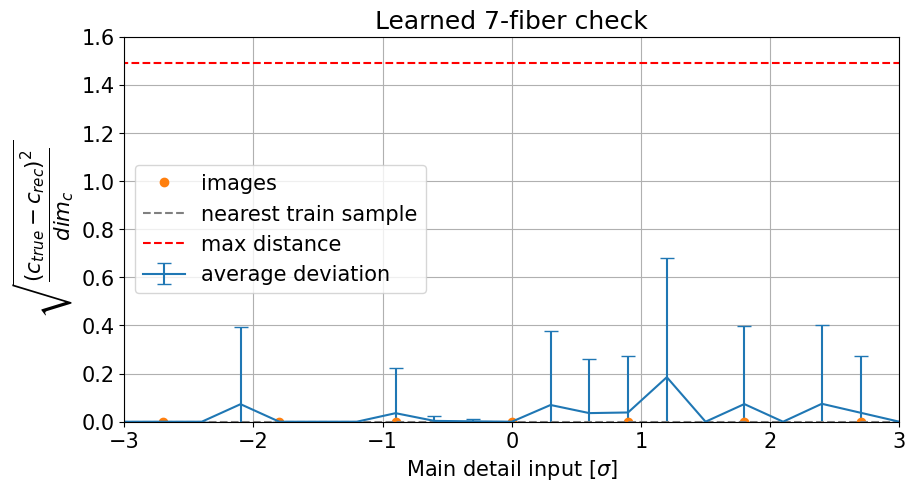

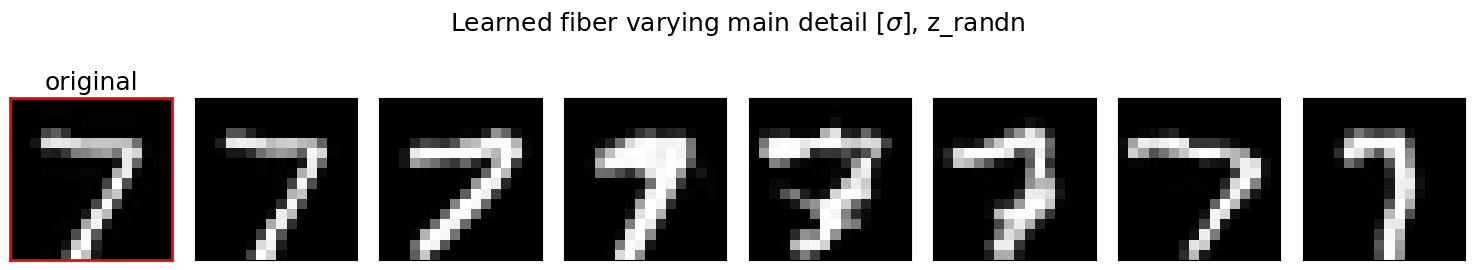

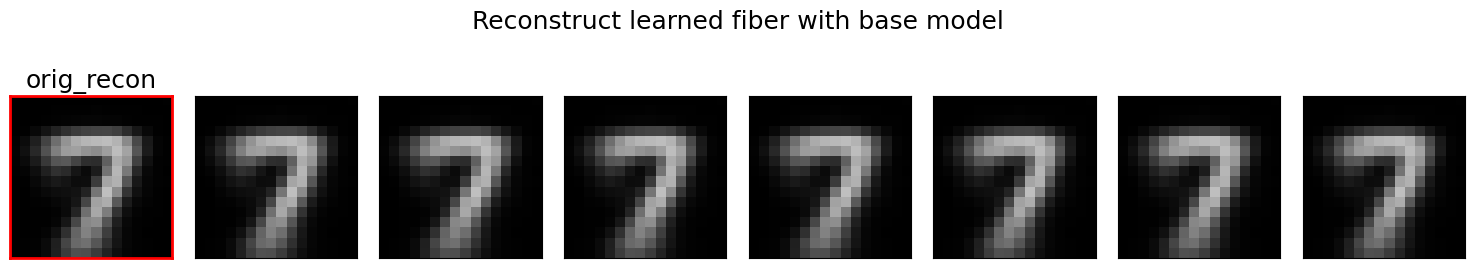

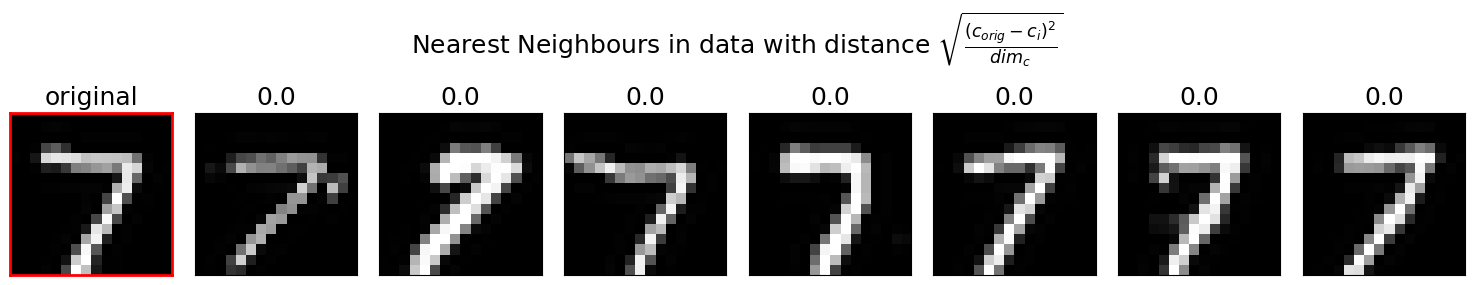

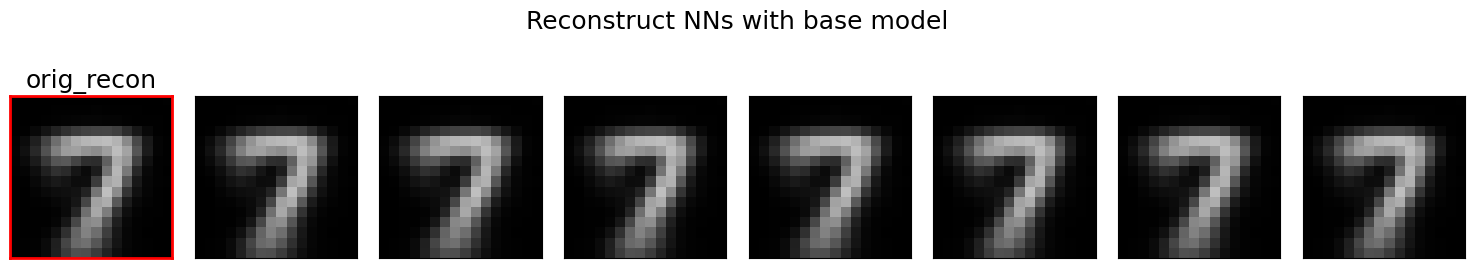

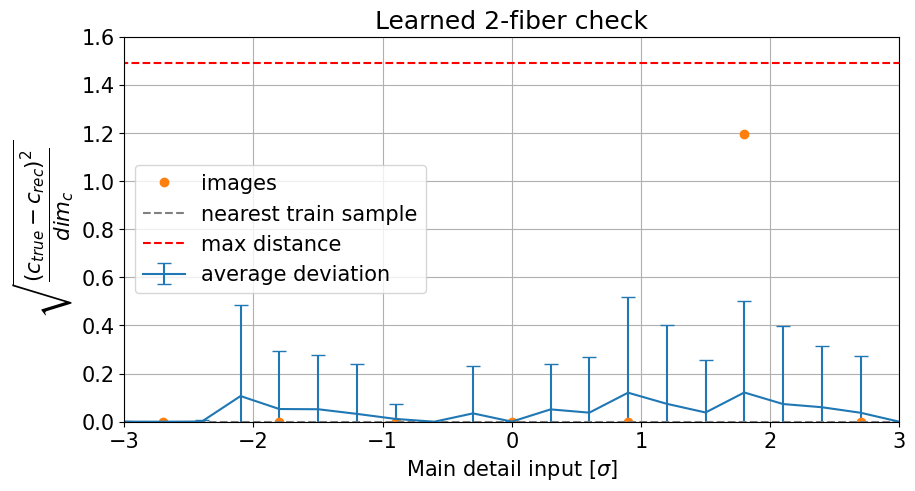

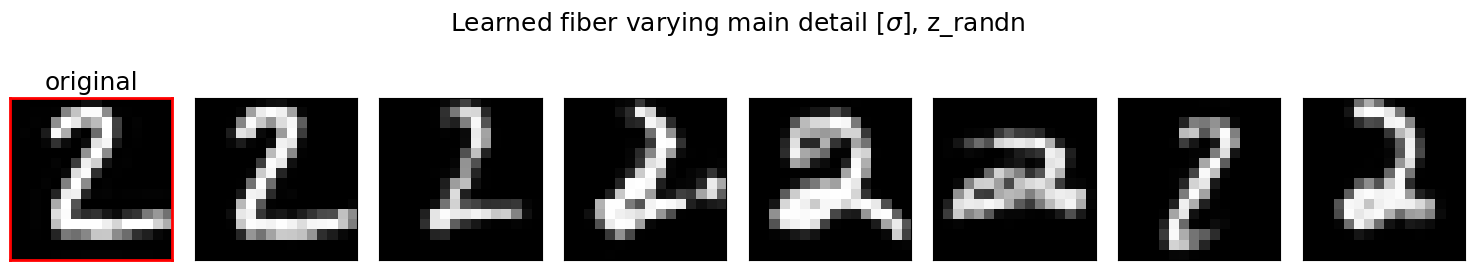

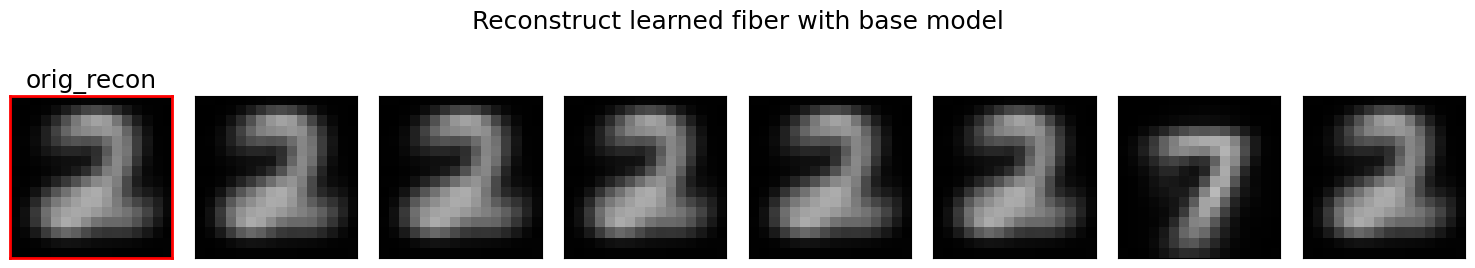

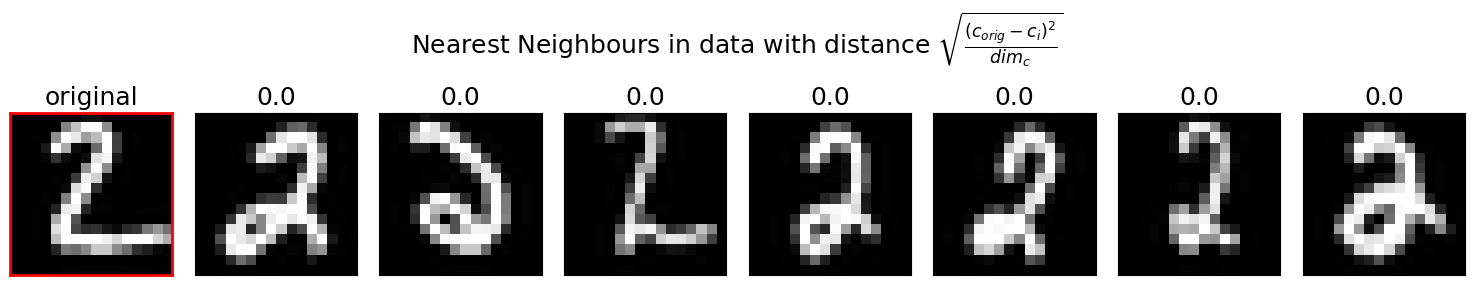

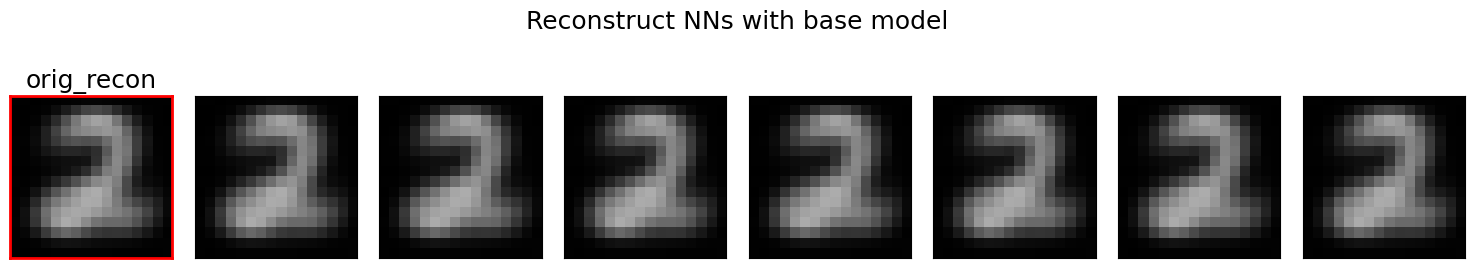

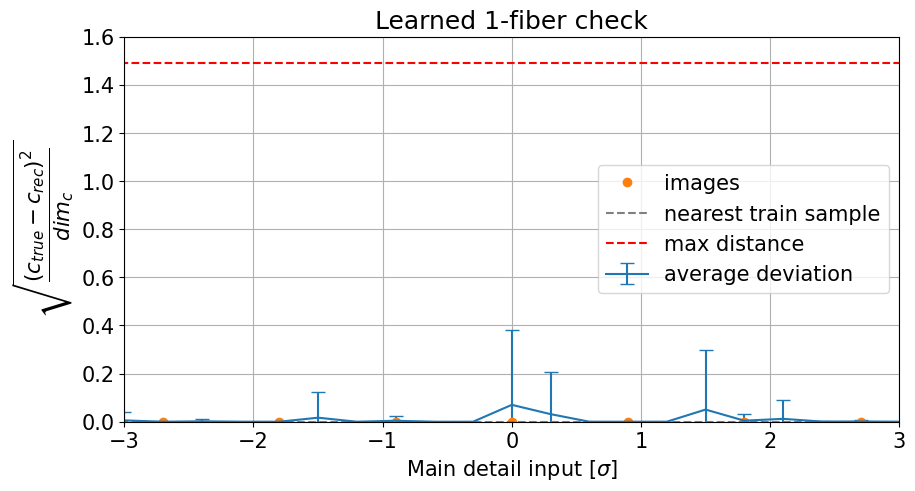

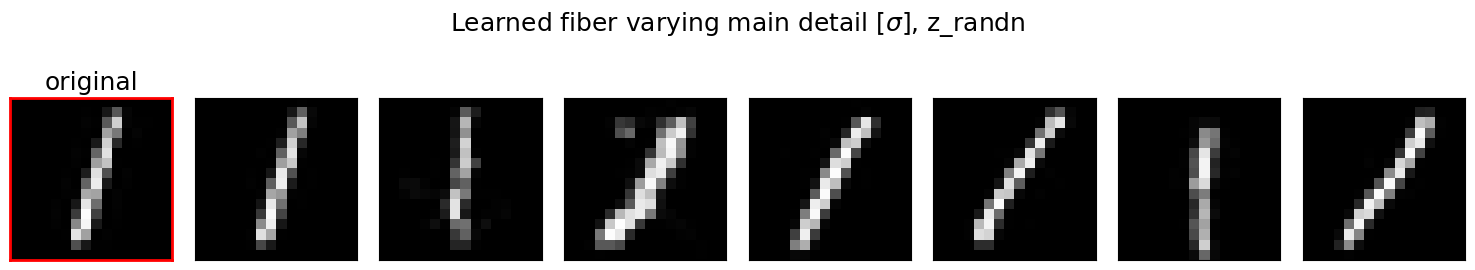

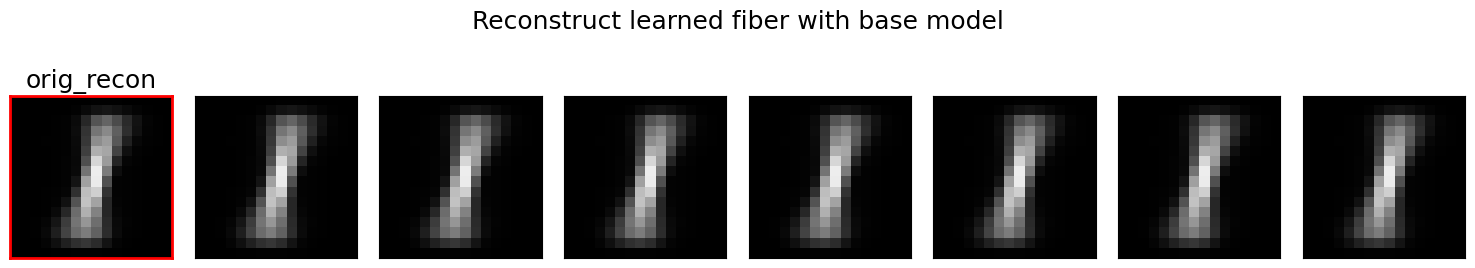

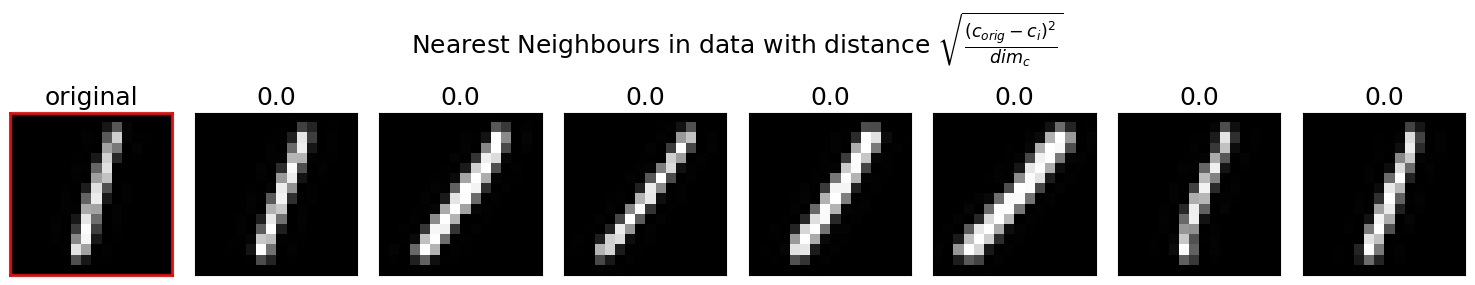

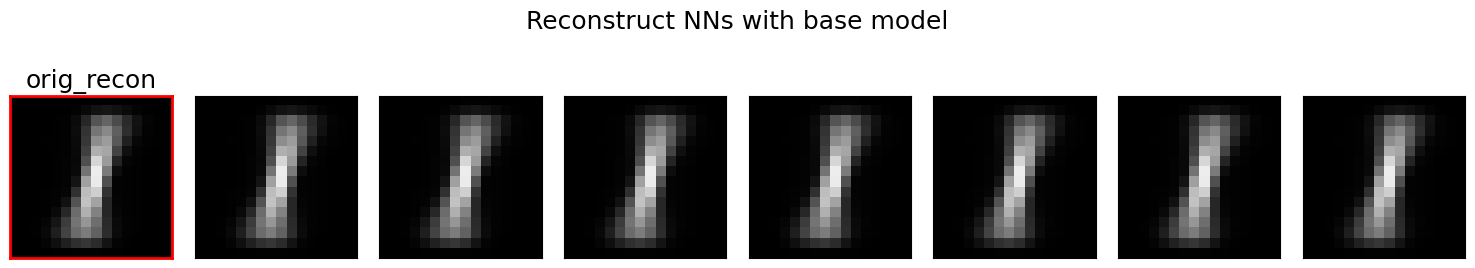

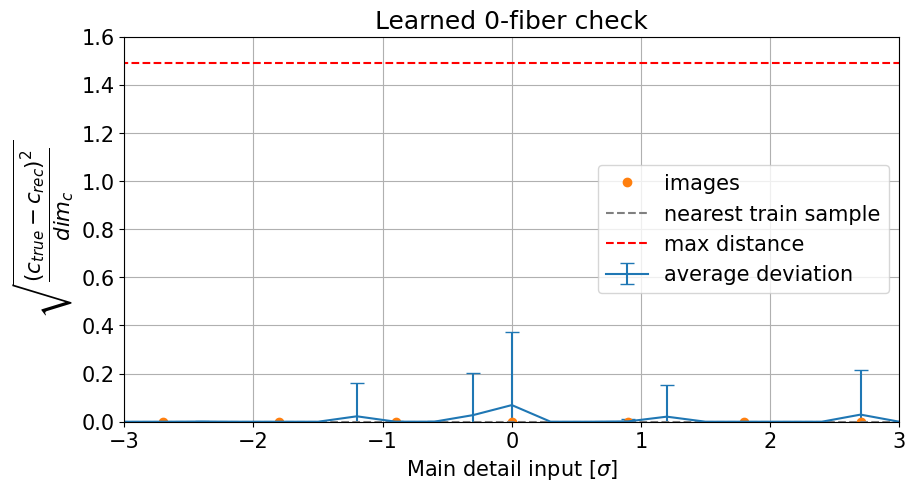

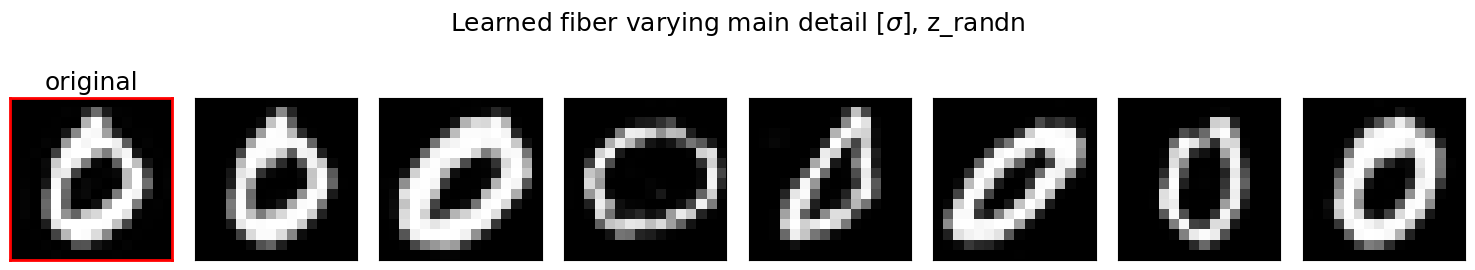

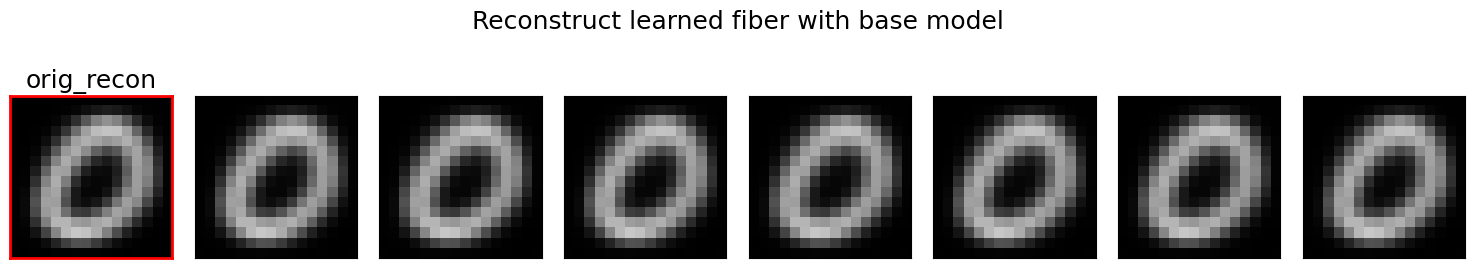

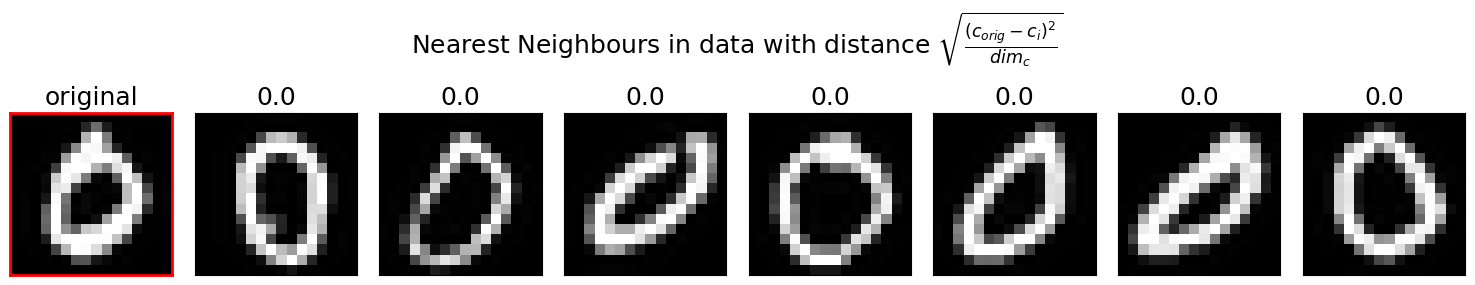

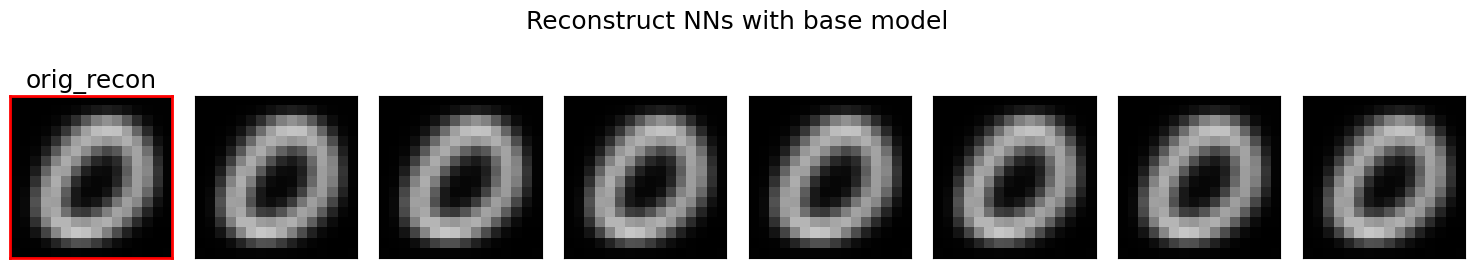

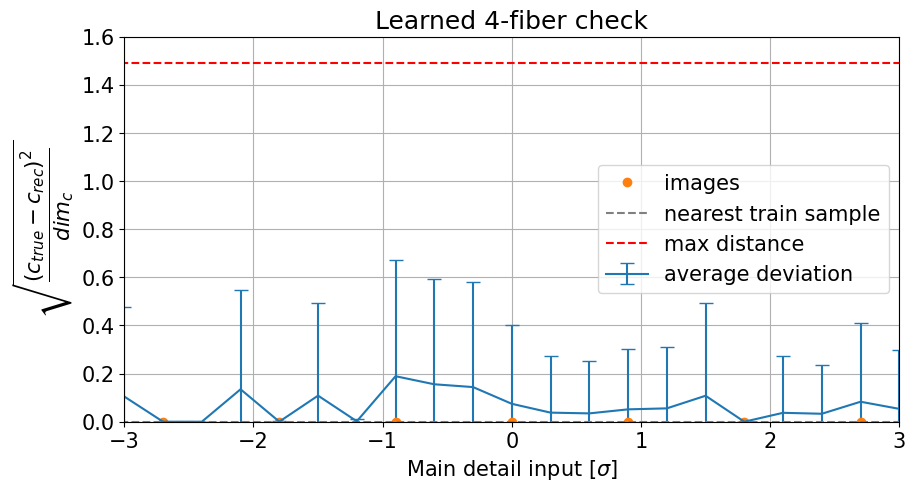

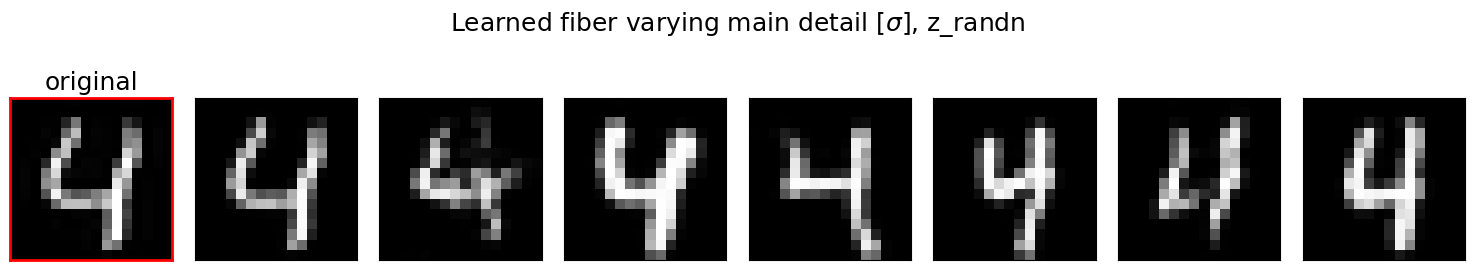

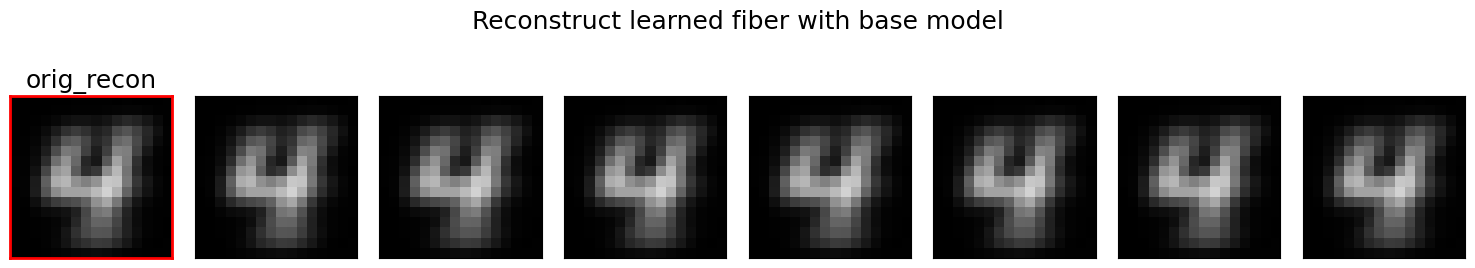

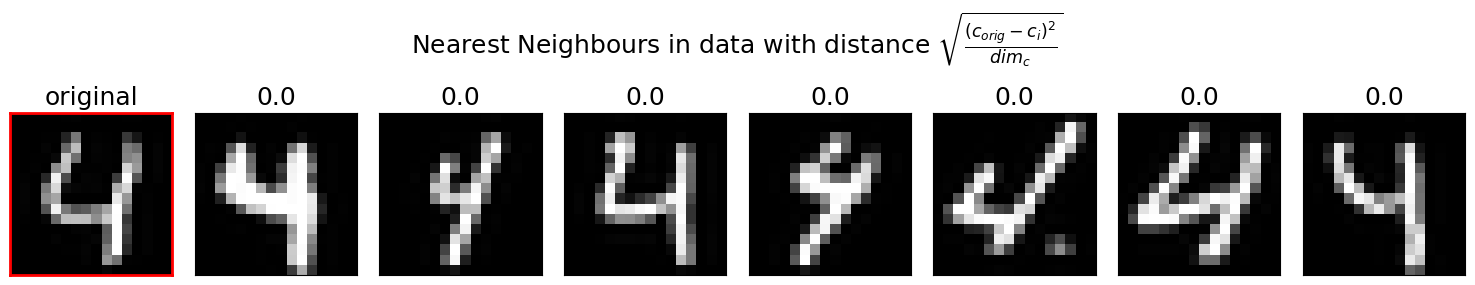

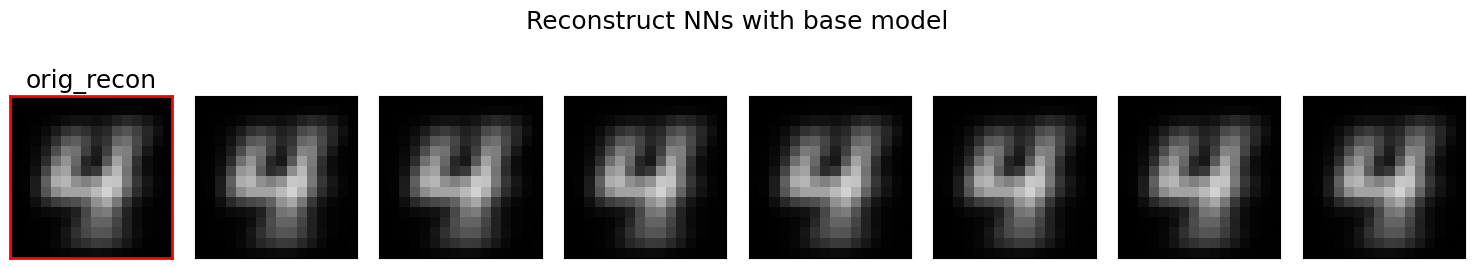

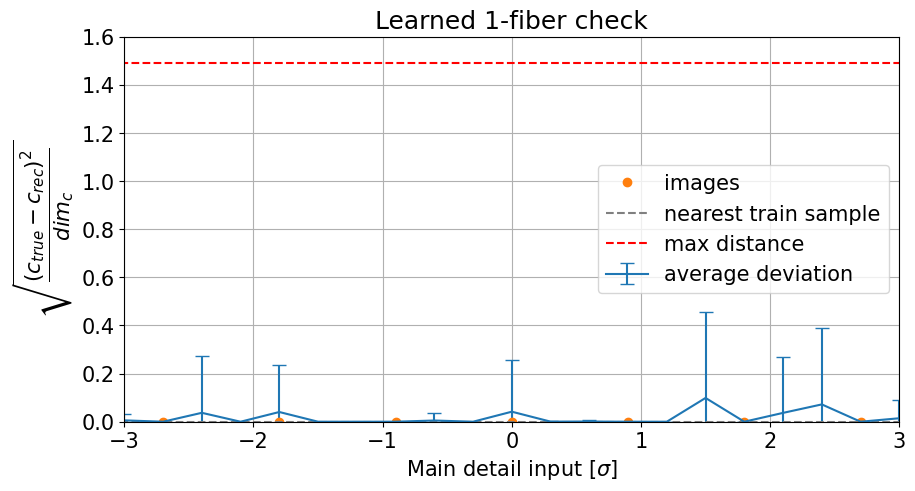

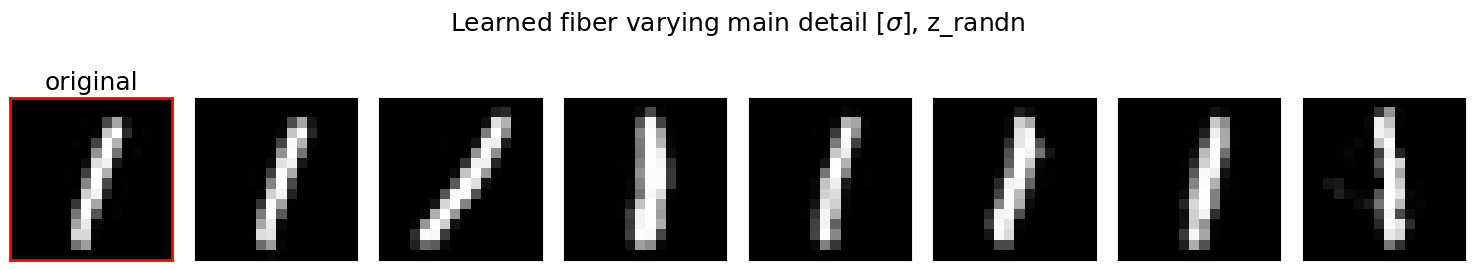

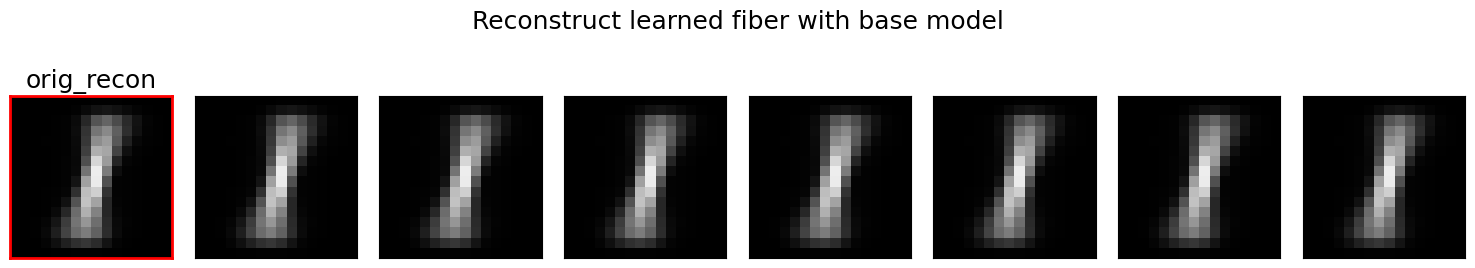

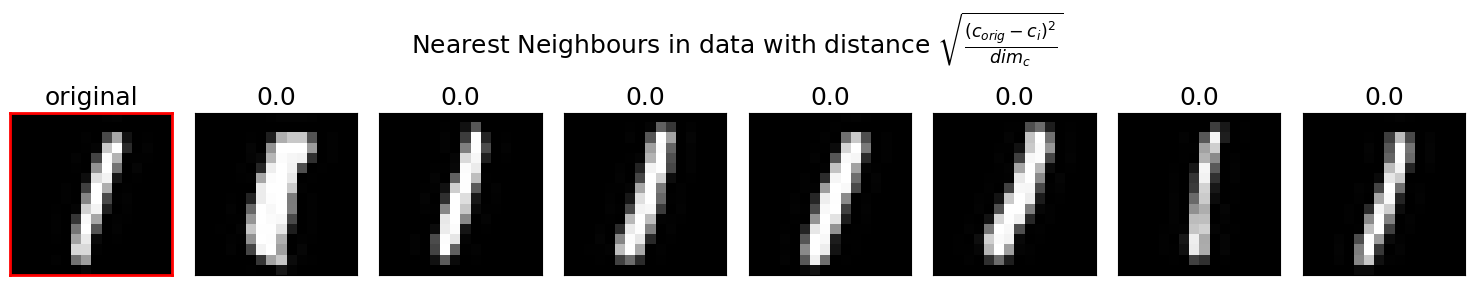

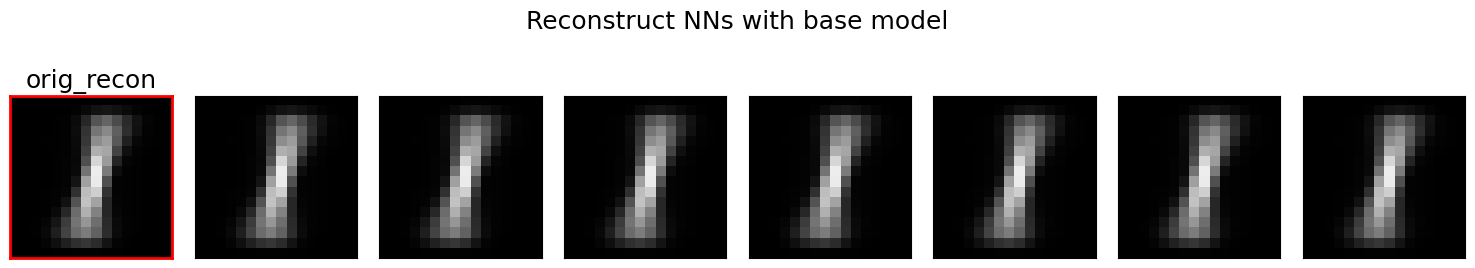

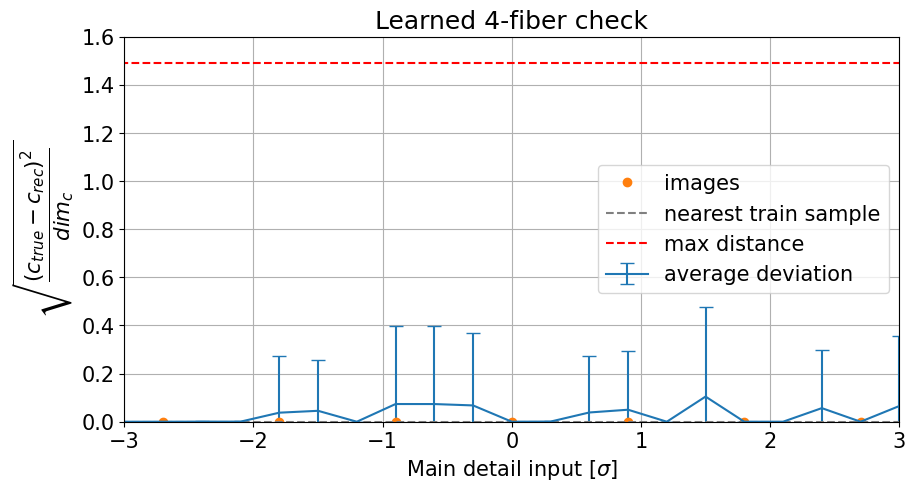

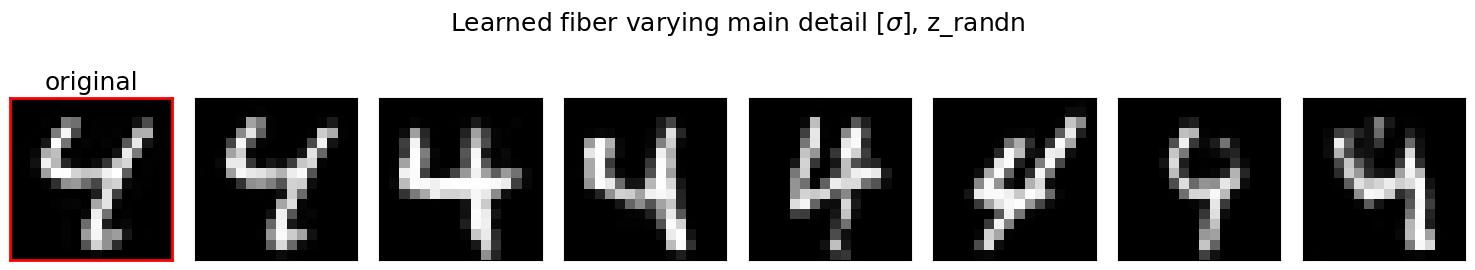

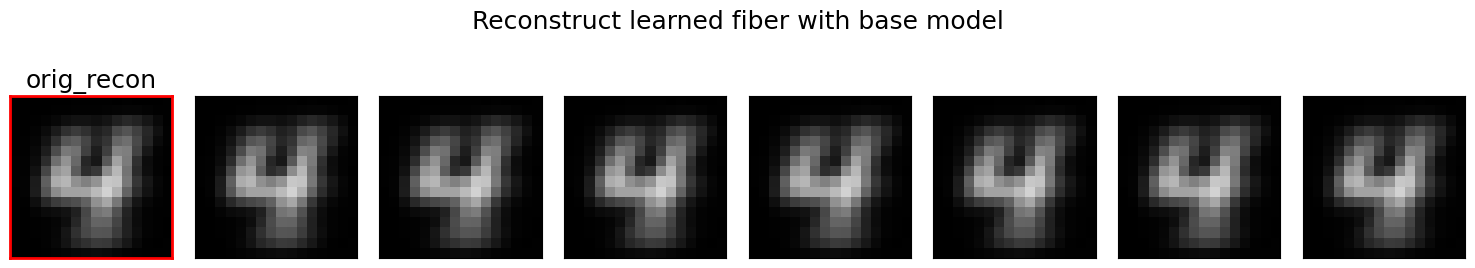

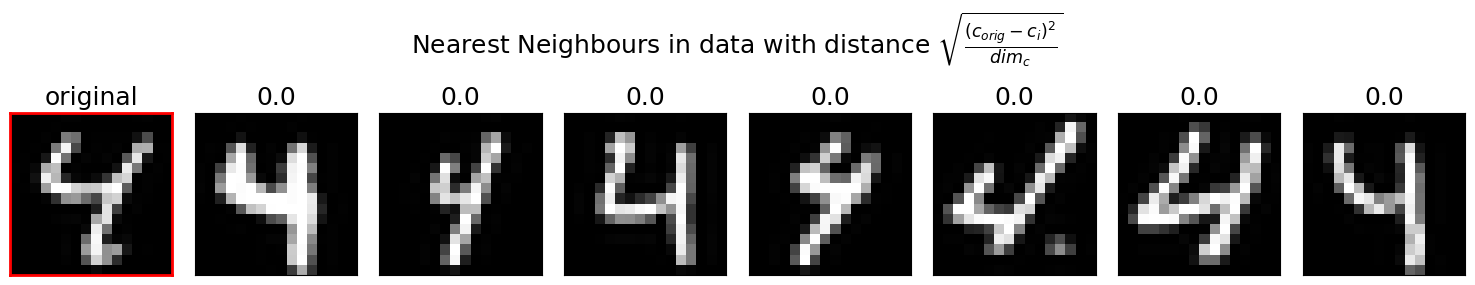

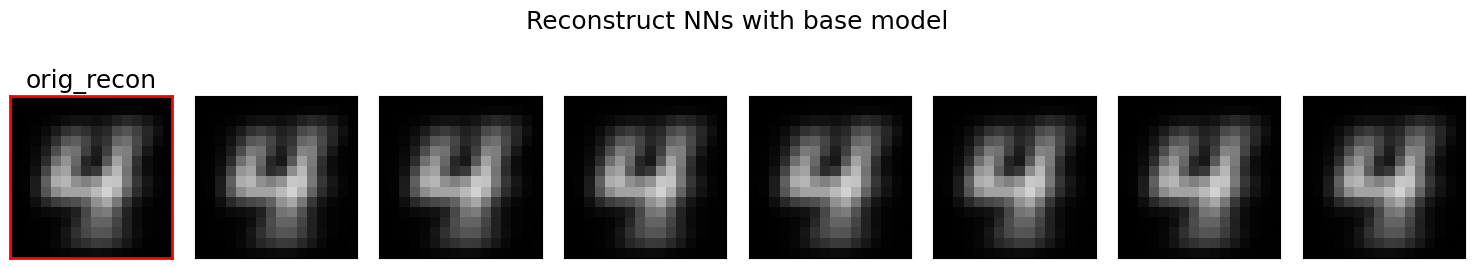

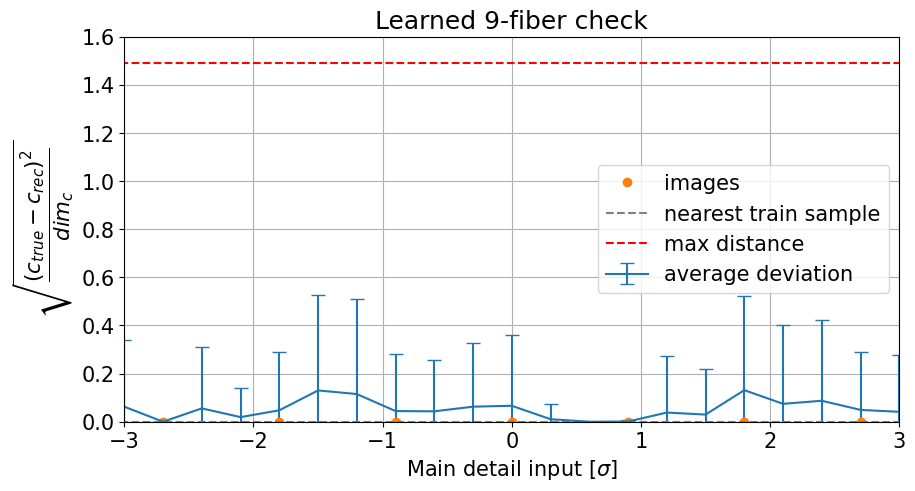

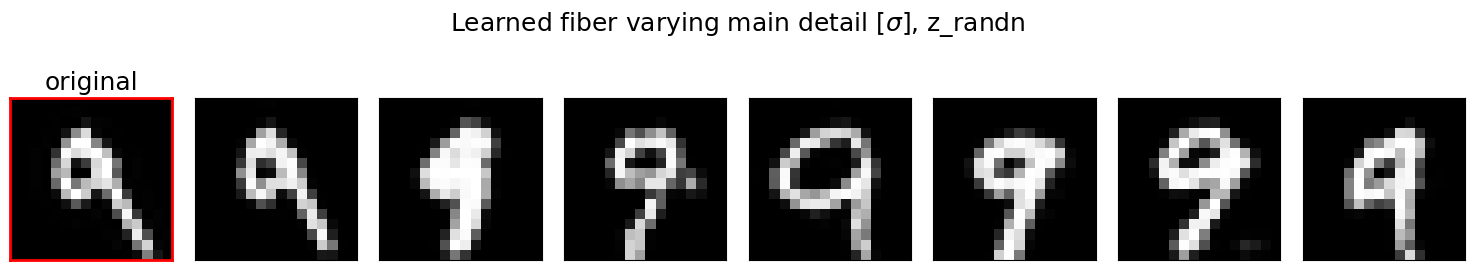

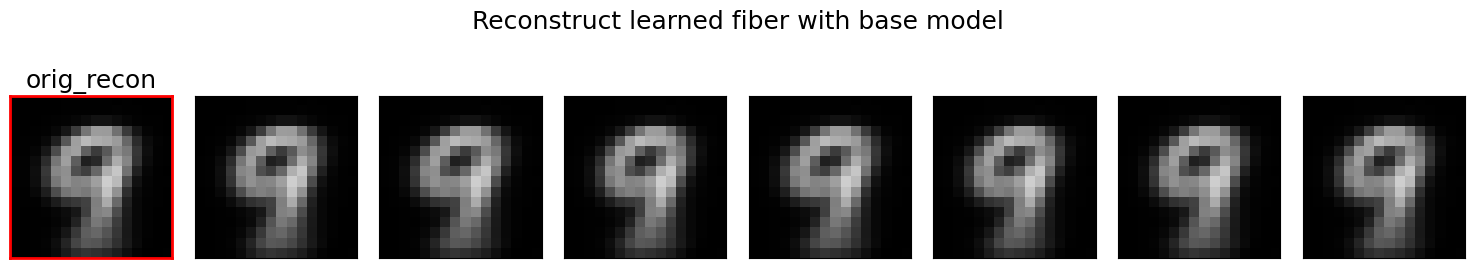

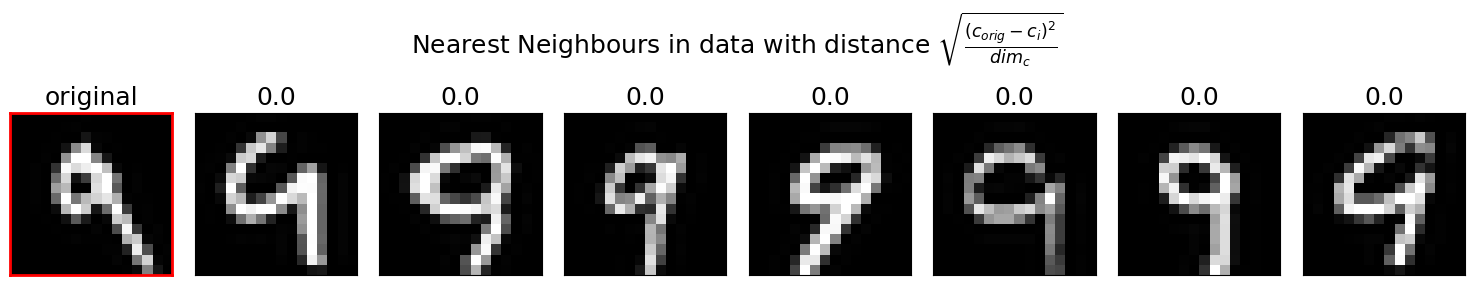

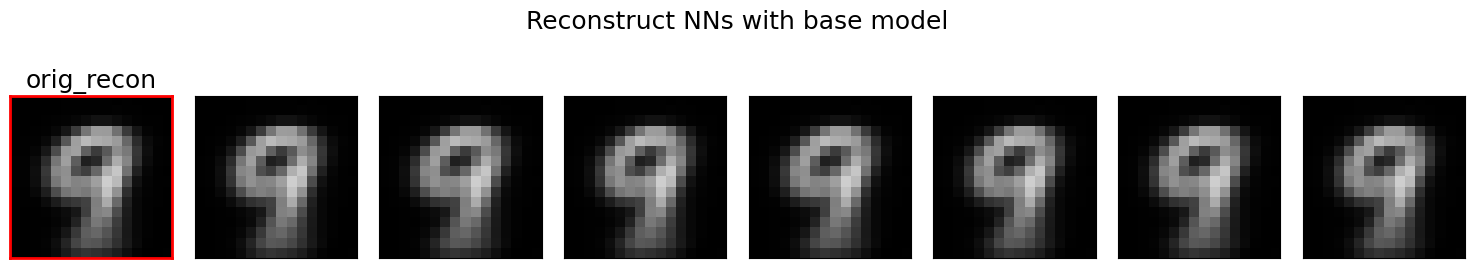

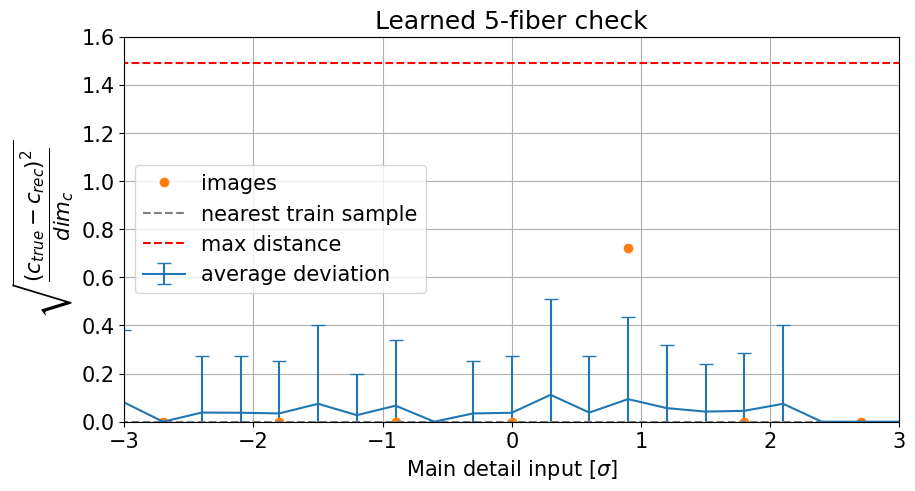

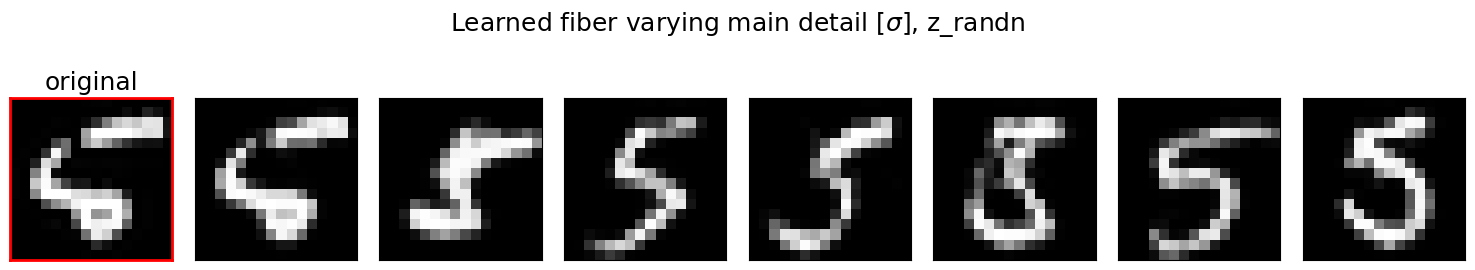

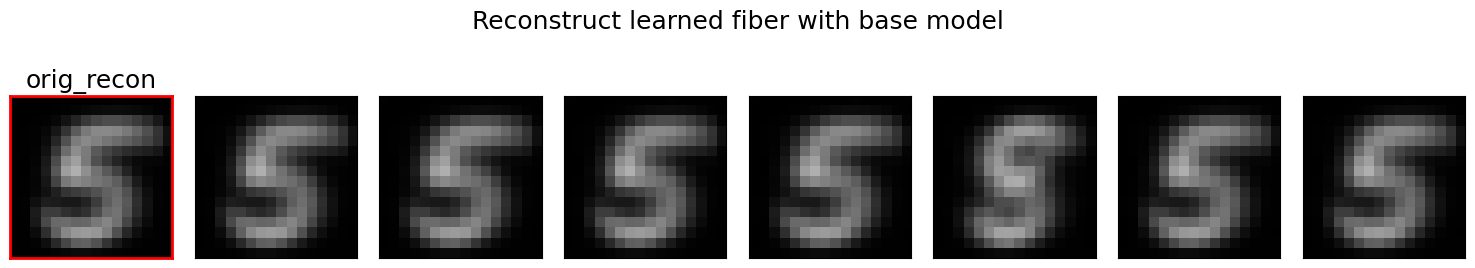

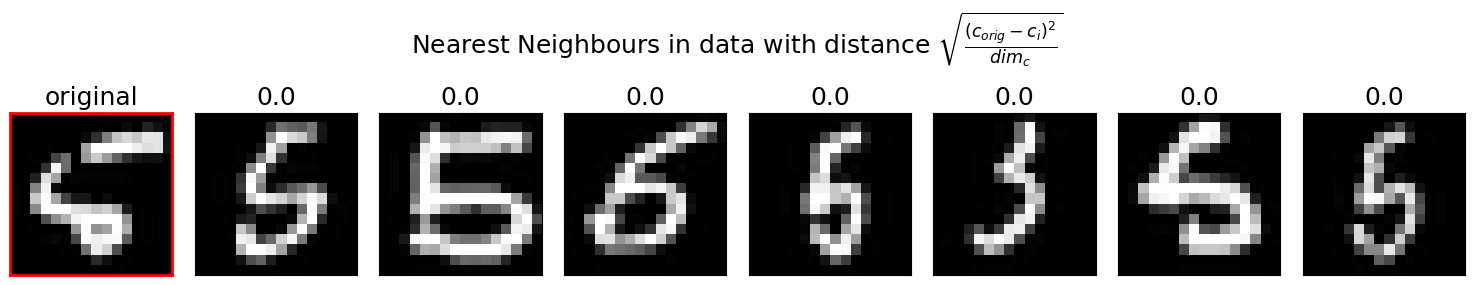

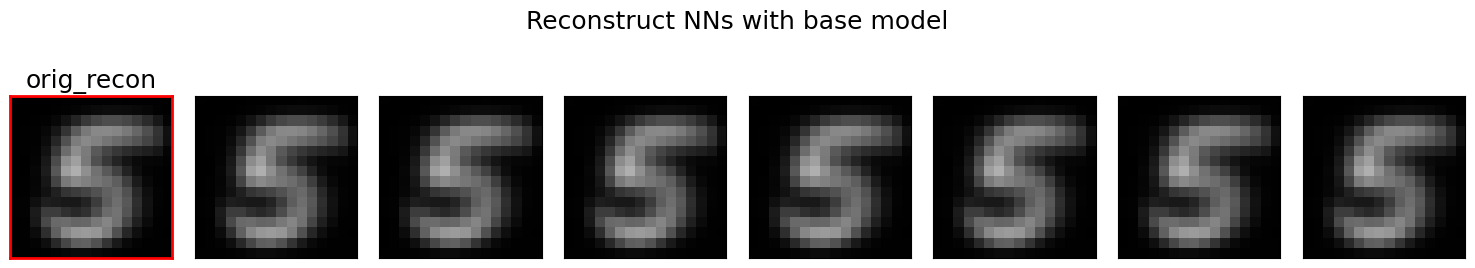

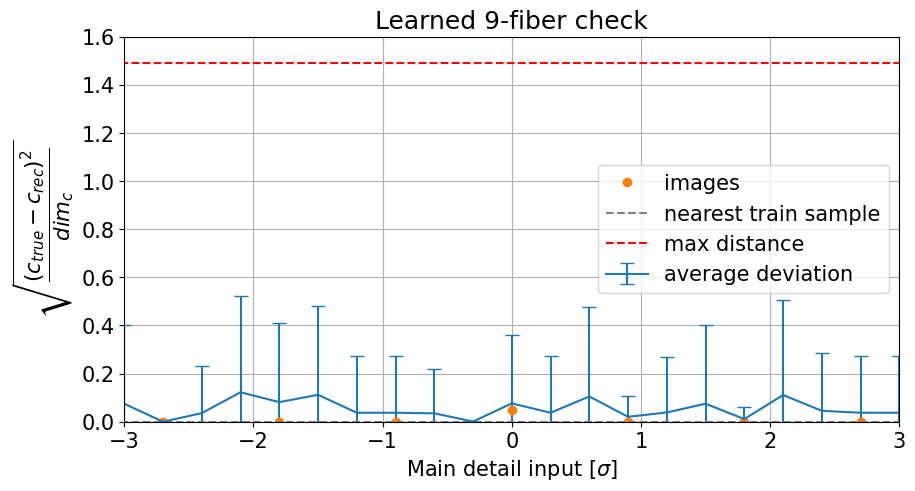

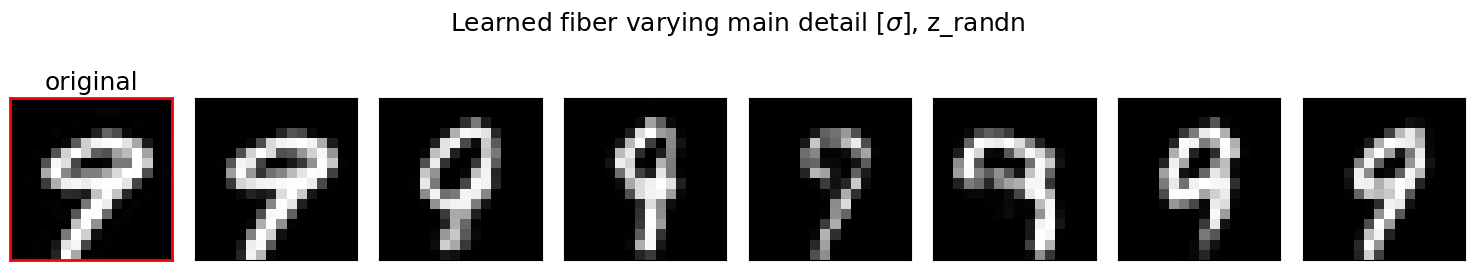

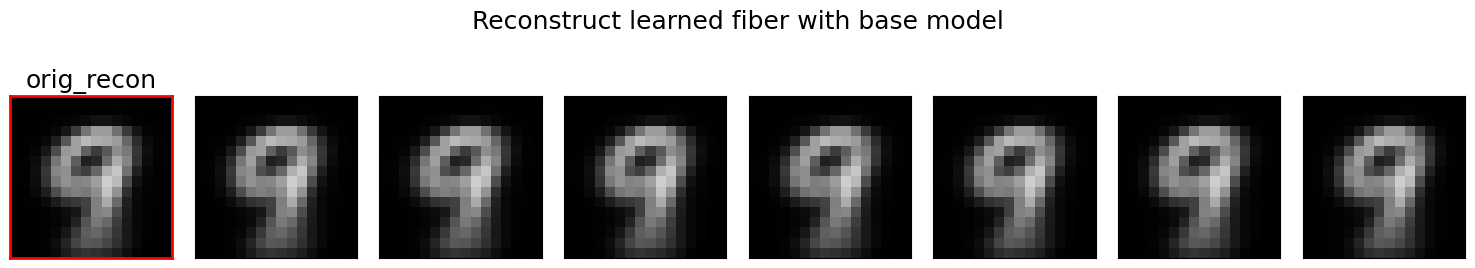

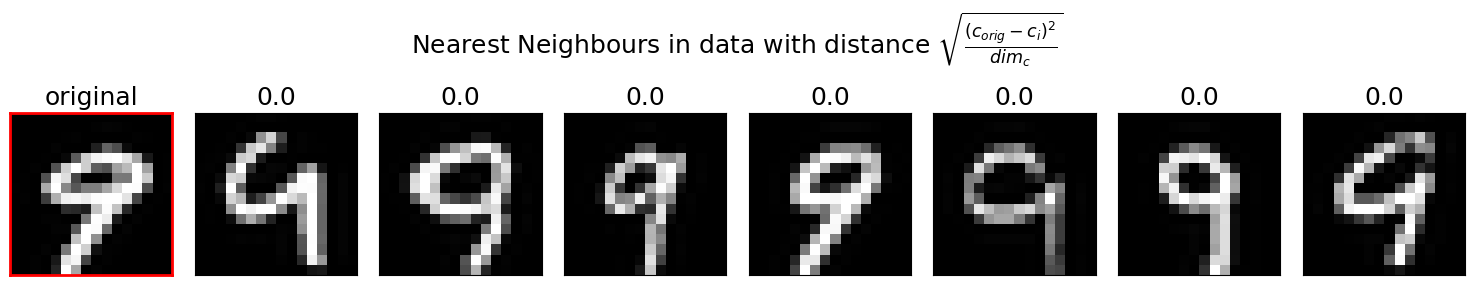

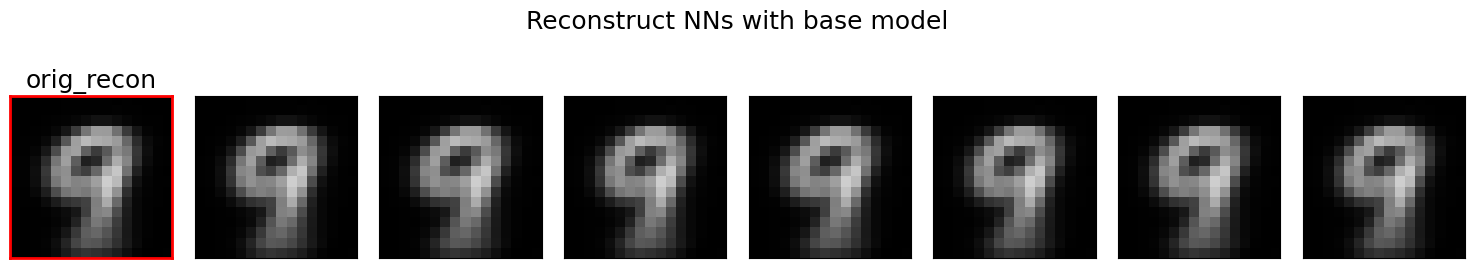

In [42]:
#Diffusion small data
zrange = 3*std_z0
matplotlib.rcParams.update({'font.size': 15})
nums = [7,2,1,0,4,1,4,9,5,9,0,6,9,0,1,5,9,7,3,4,0,0,0,0,0,0,0,0,0,0,0,0]
ran = np.arange(10)

for j in ran:
    plot_details(model, data, j, zrange, 0)

tensor(1.4920)
tensor(1.4920)
tensor(1.4237)
tensor(1.4920)
tensor(1.4920)


/tmp/ipykernel_2644688/3457698026.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[10,5])


tensor(1.4899)
tensor(1.4920)
tensor(1.4920)
tensor(1.4920)
tensor(1.4920)


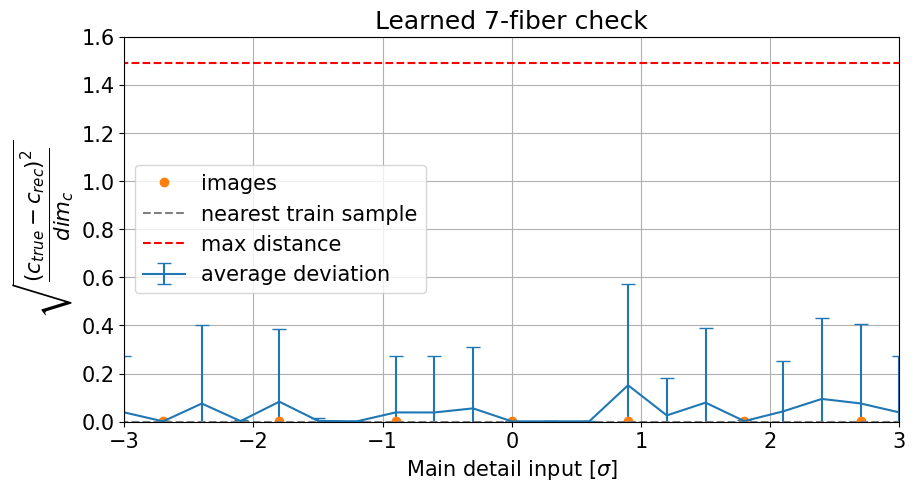

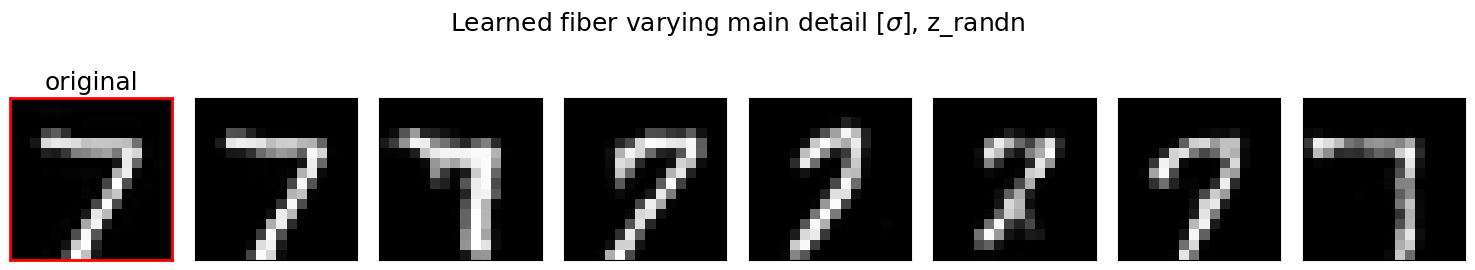

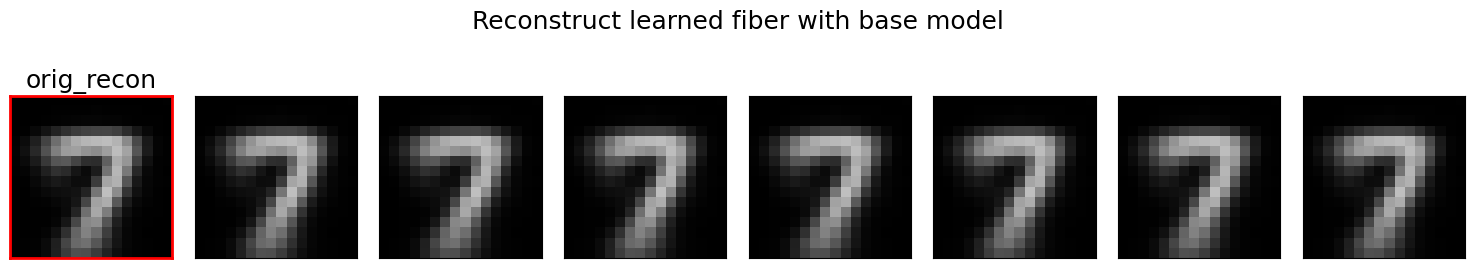

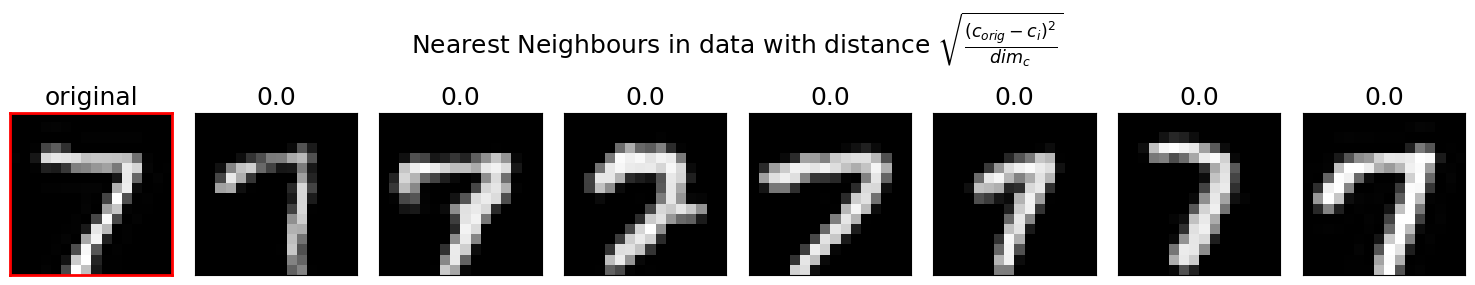

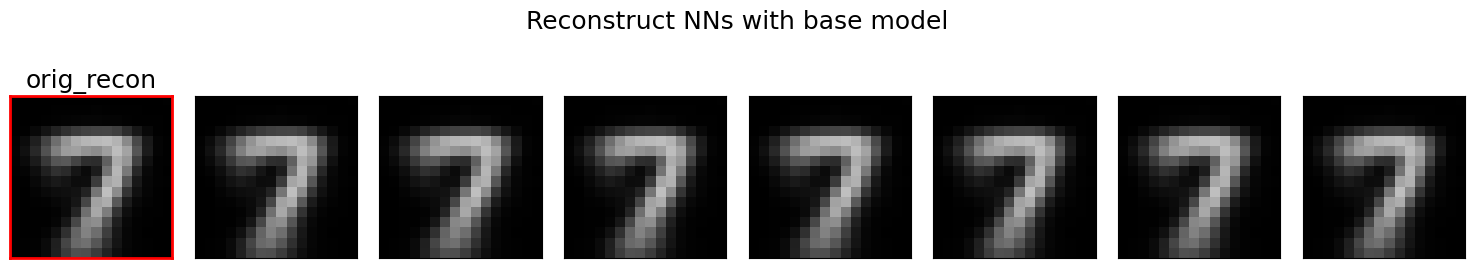

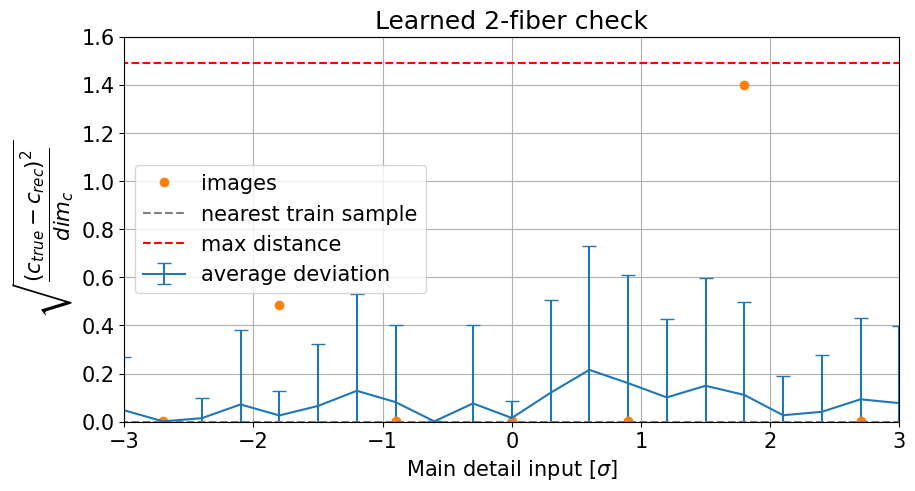

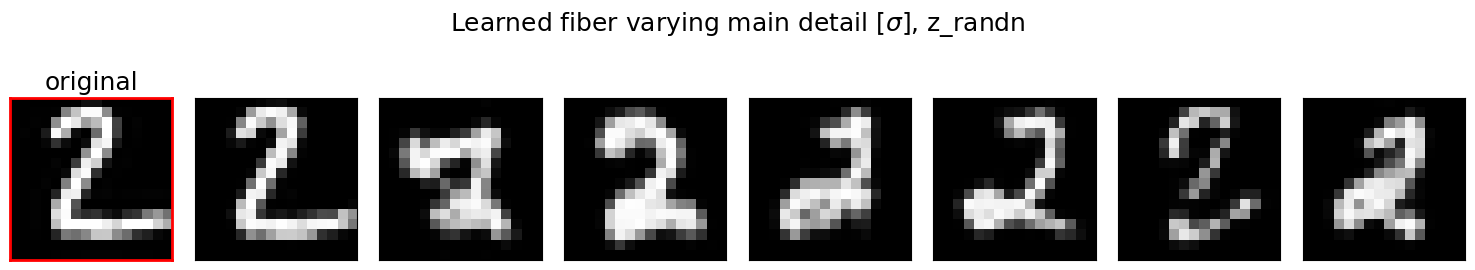

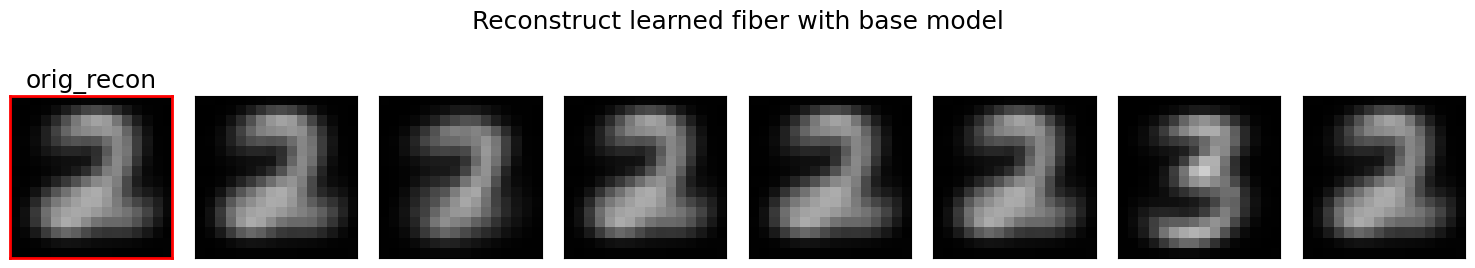

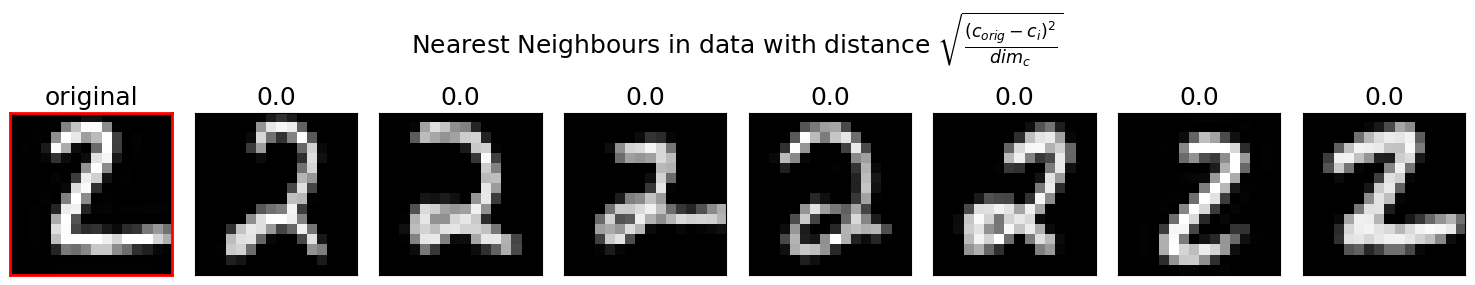

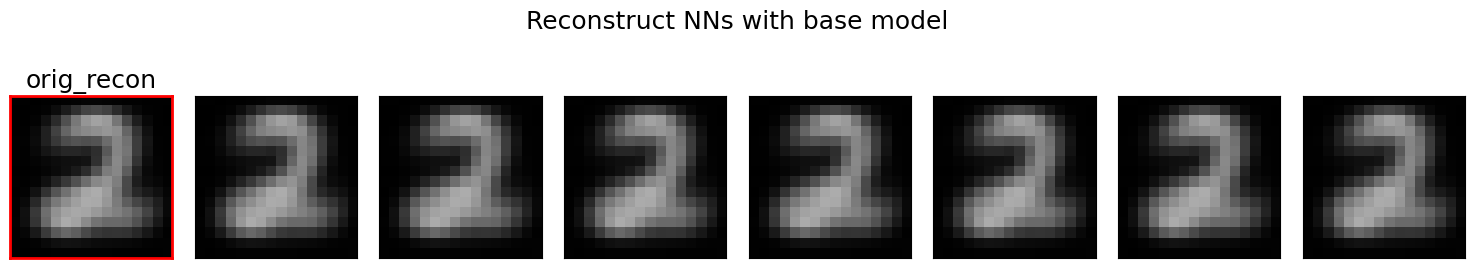

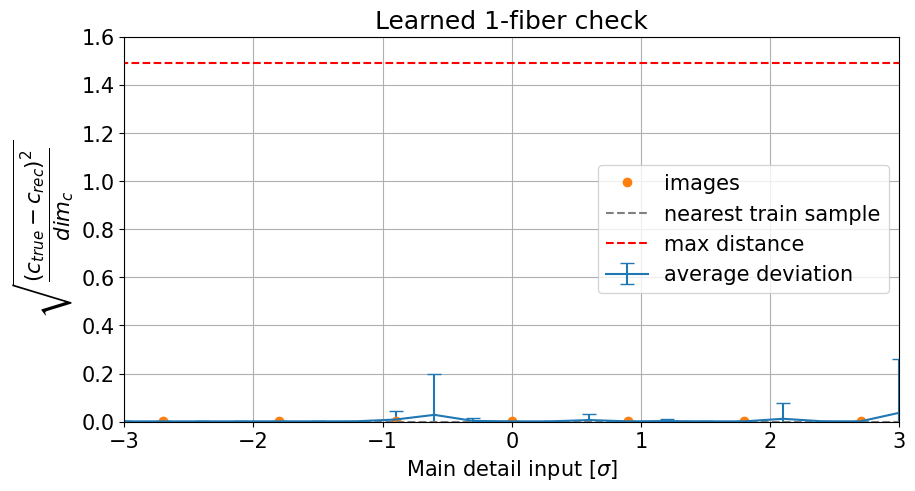

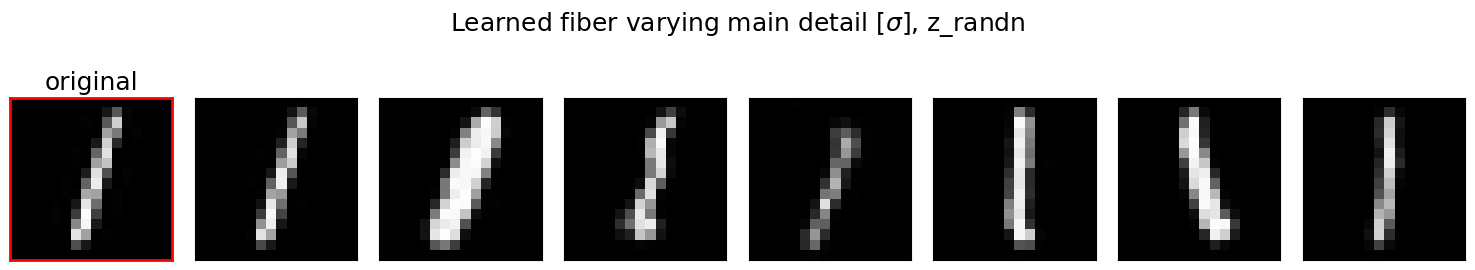

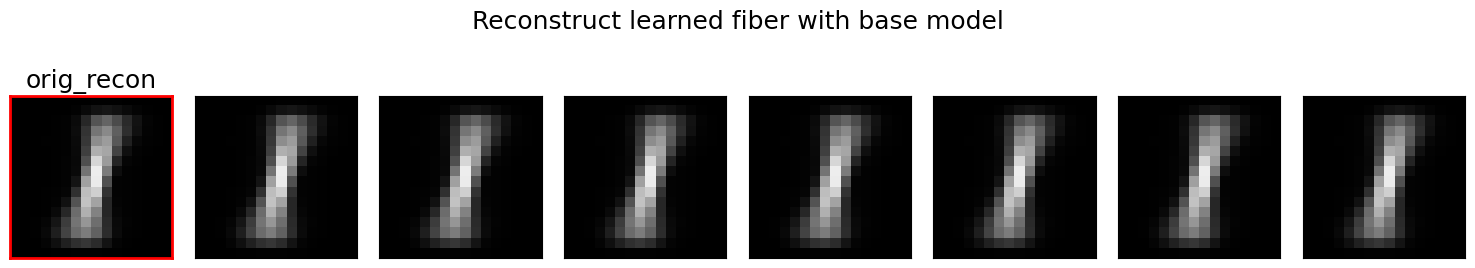

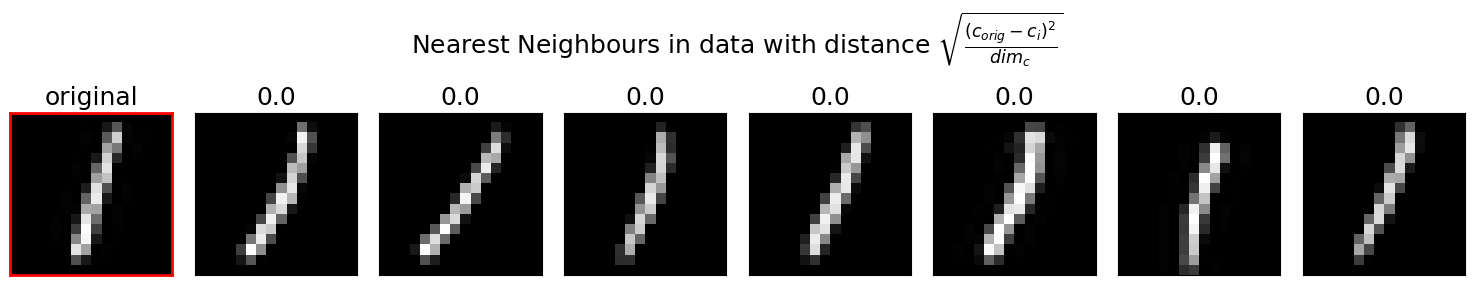

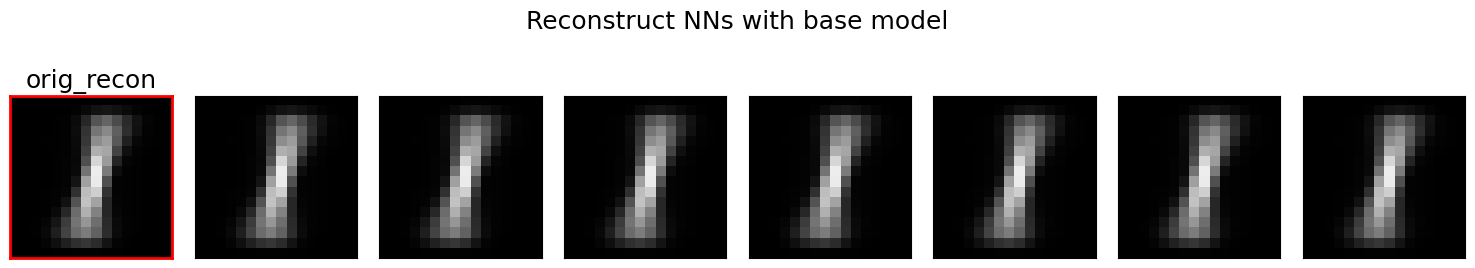

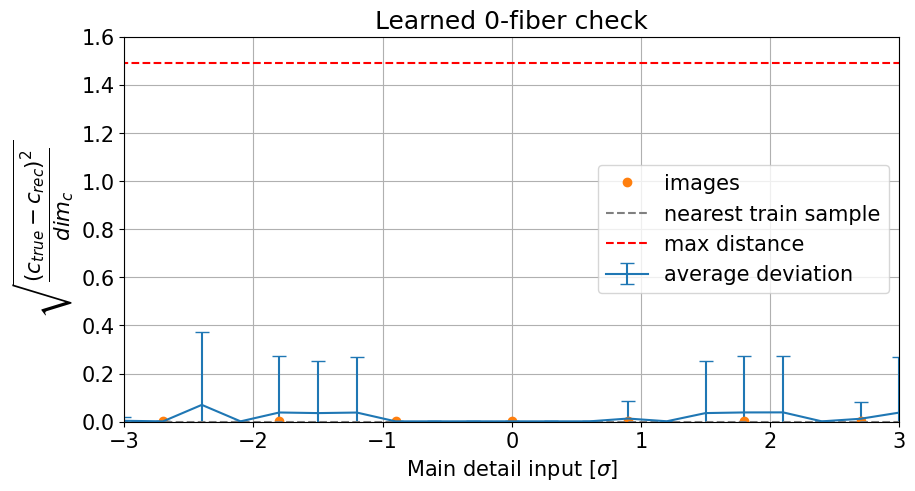

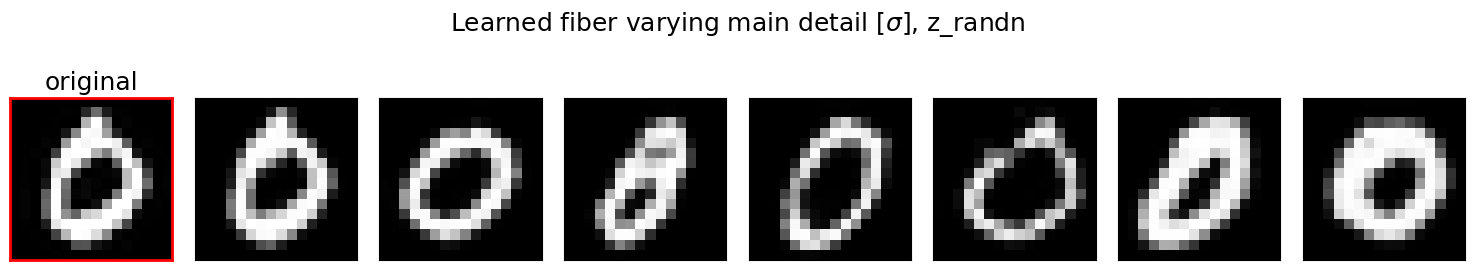

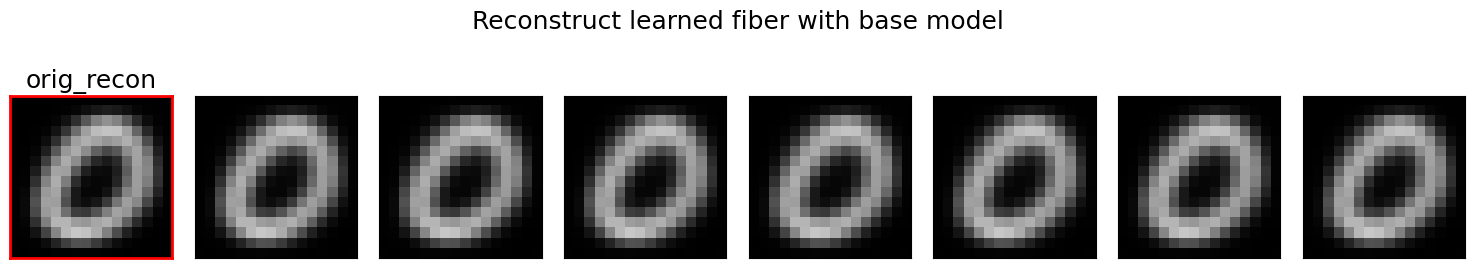

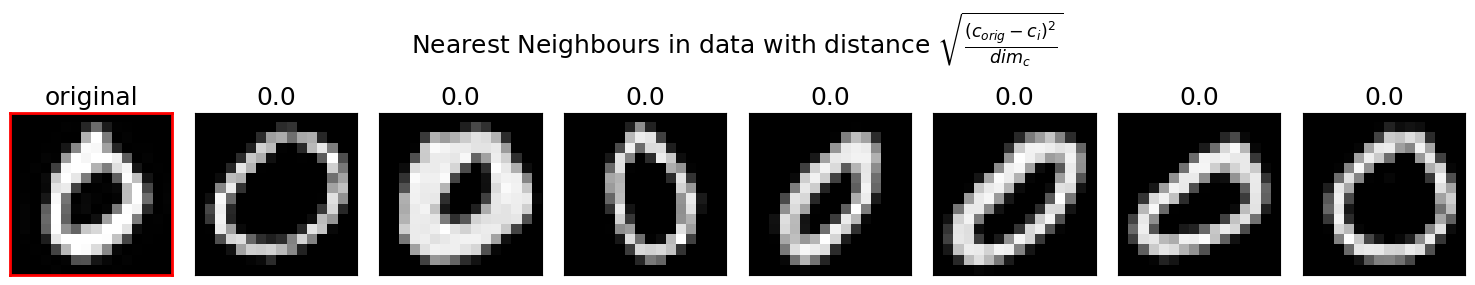

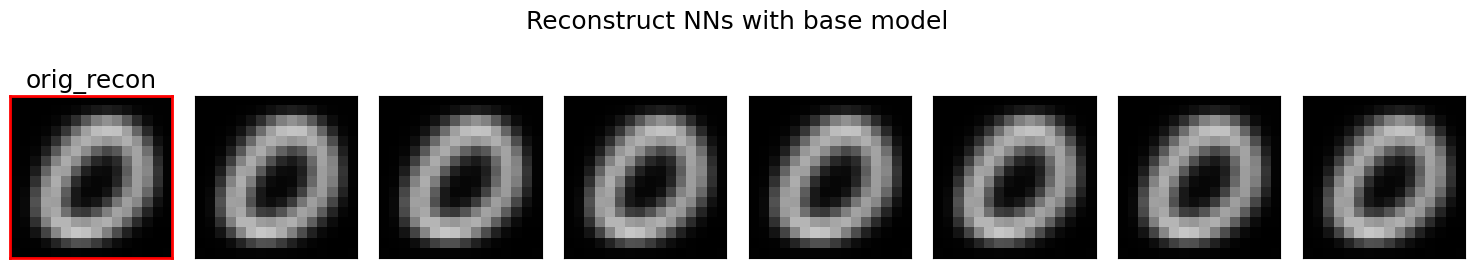

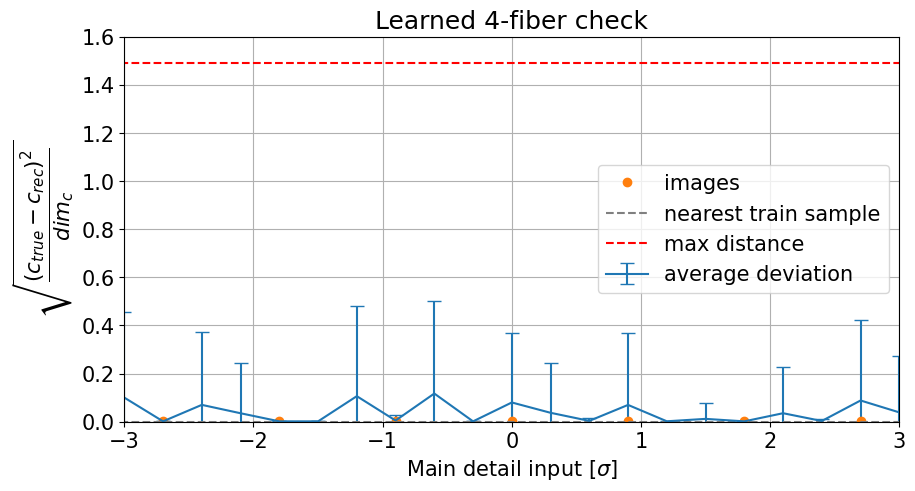

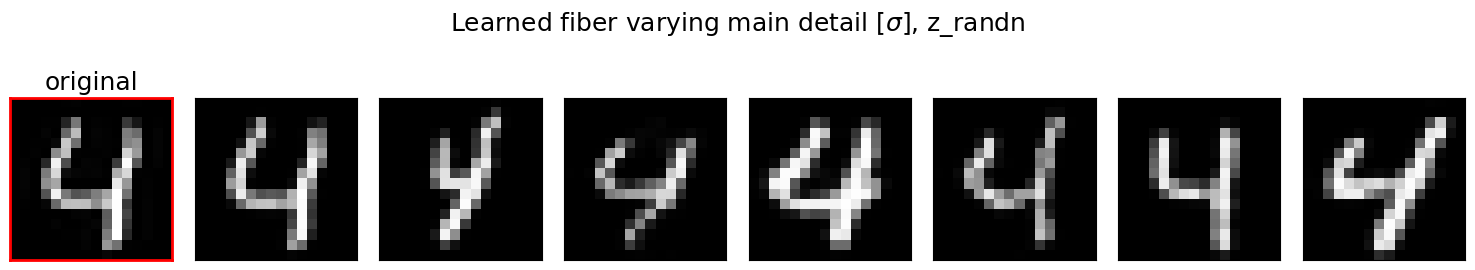

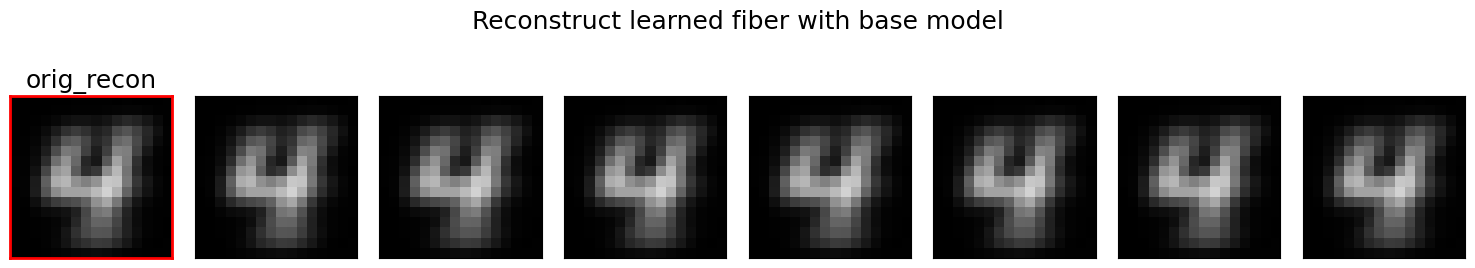

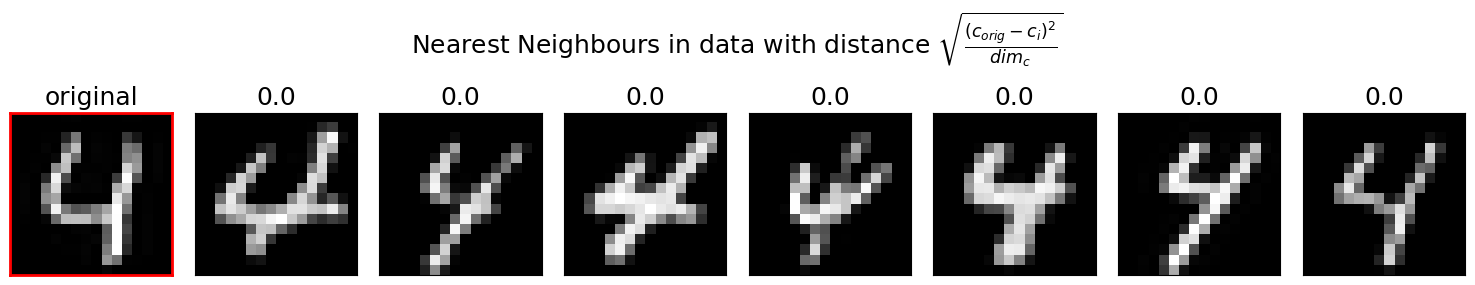

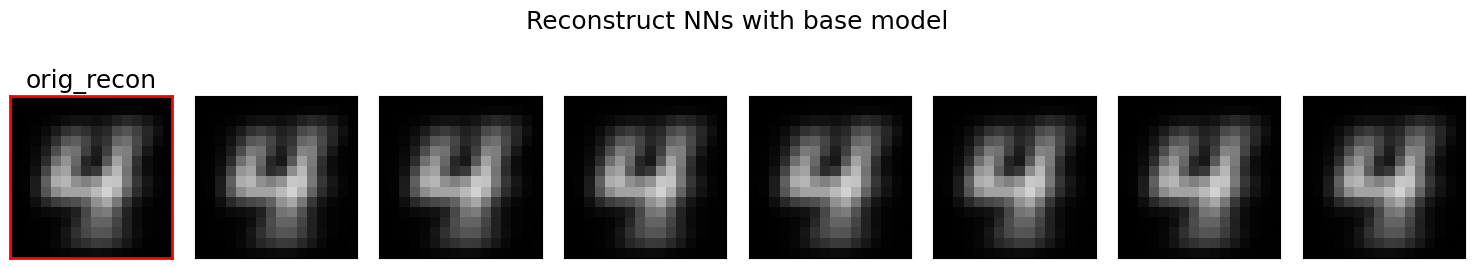

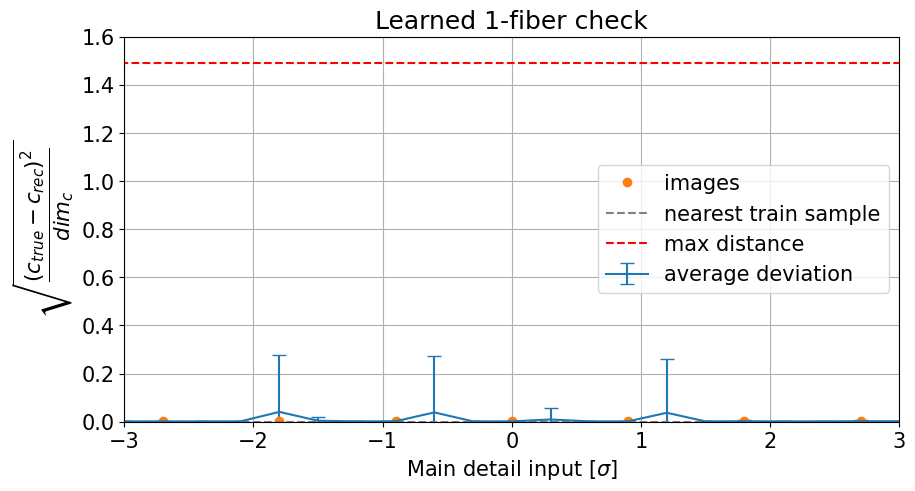

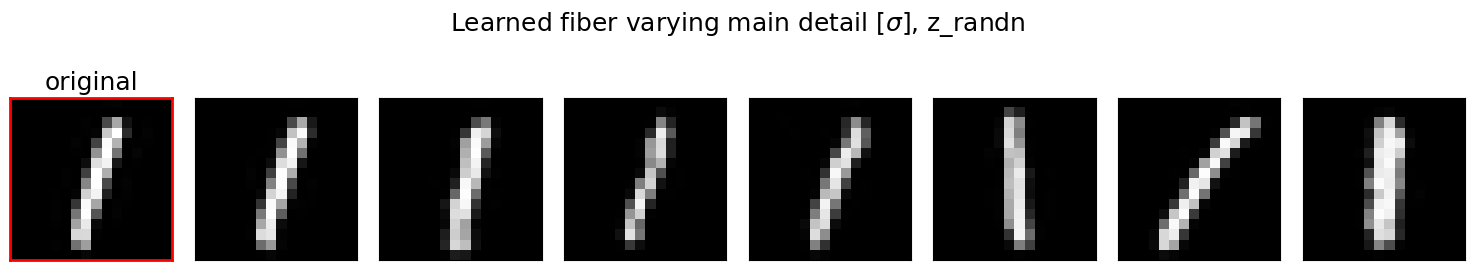

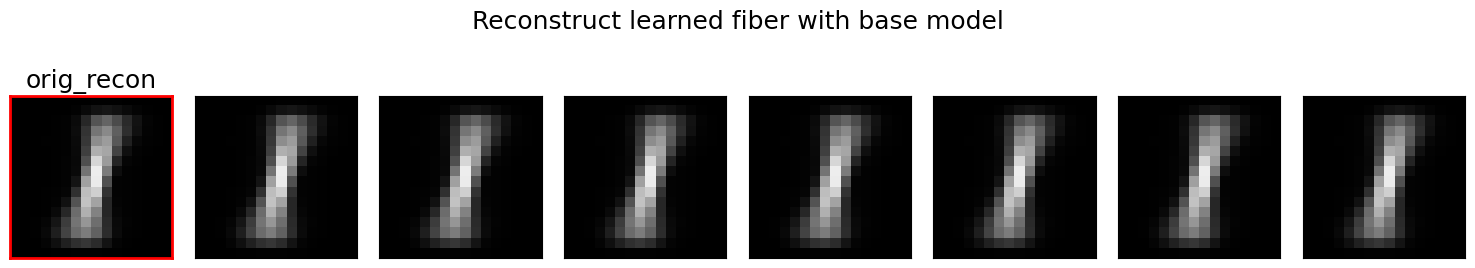

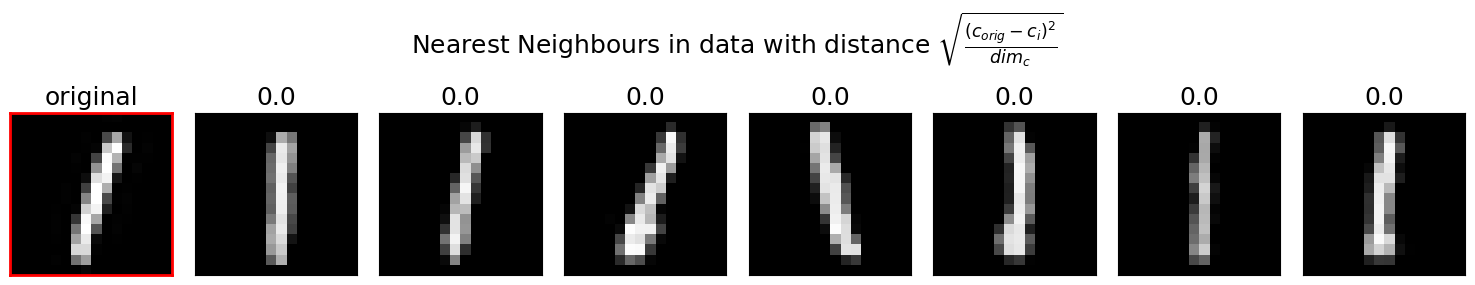

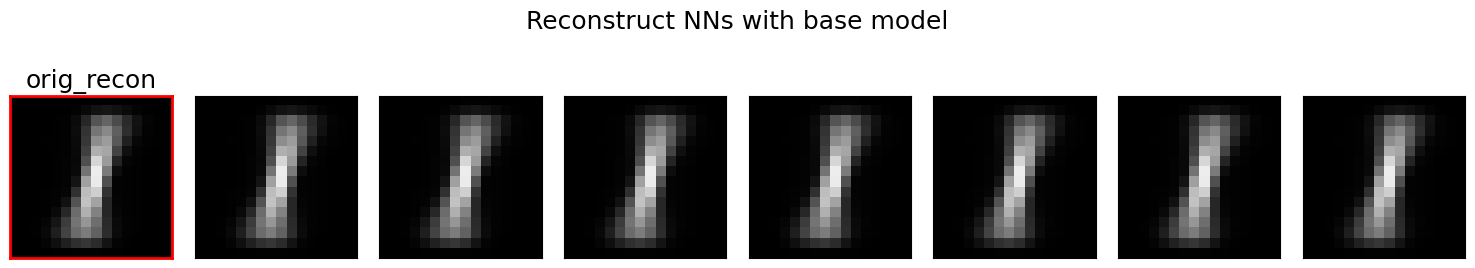

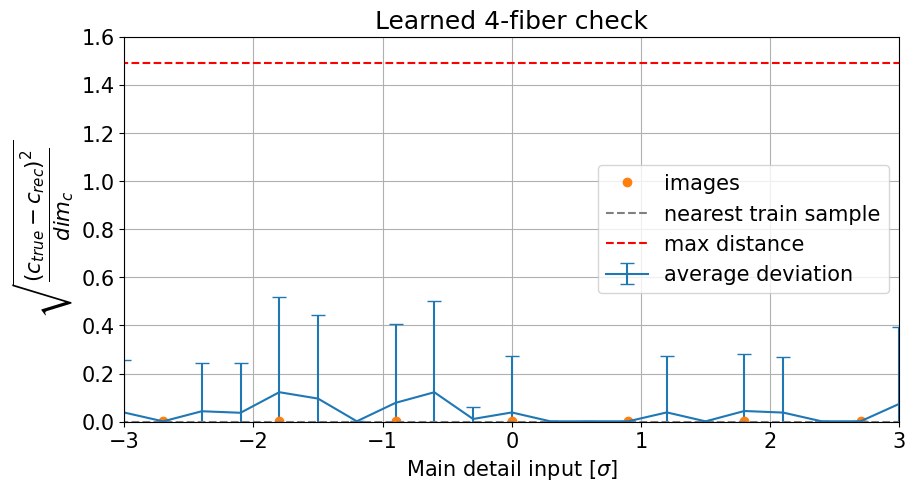

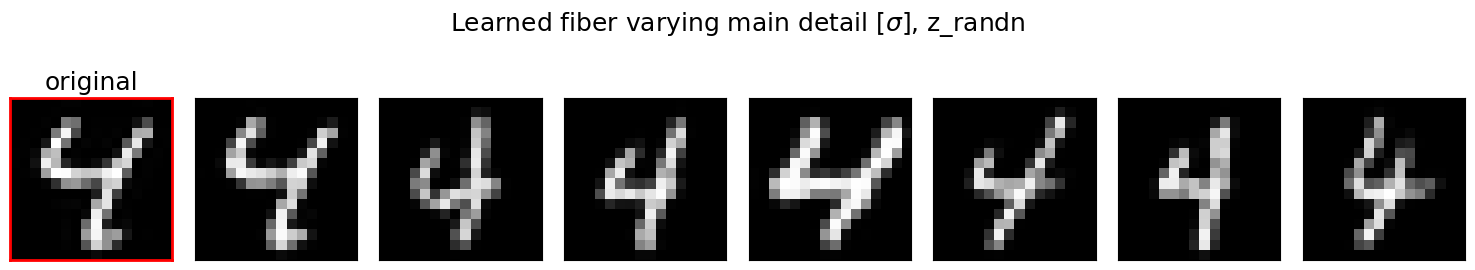

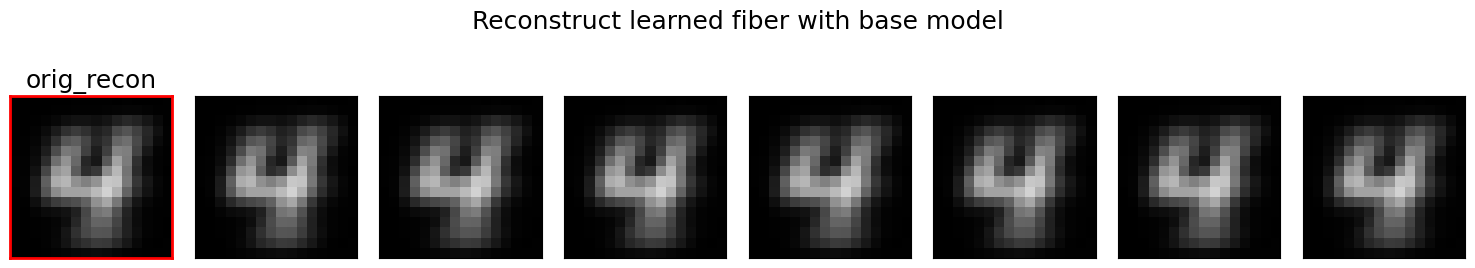

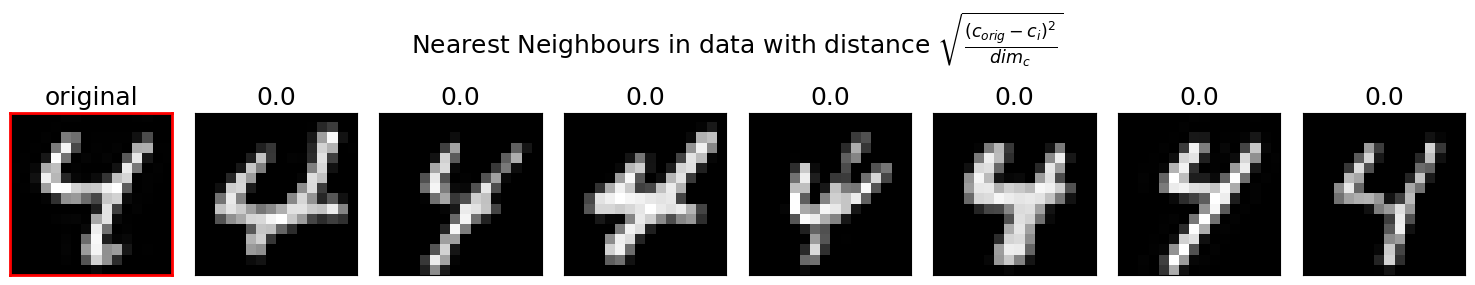

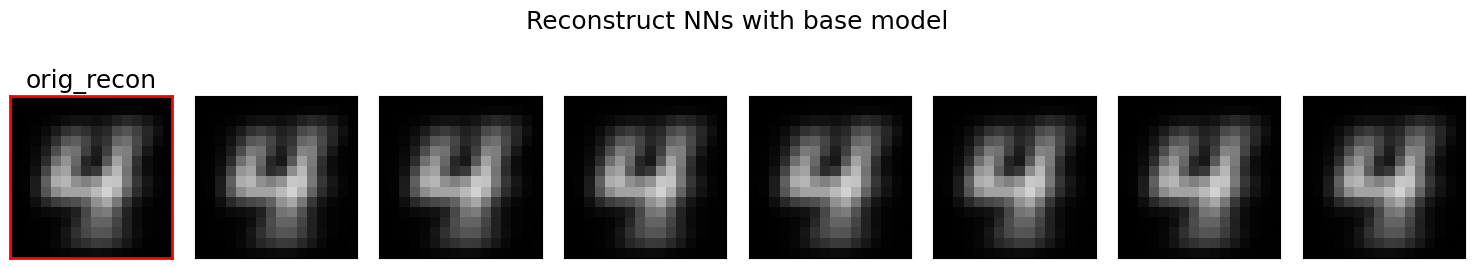

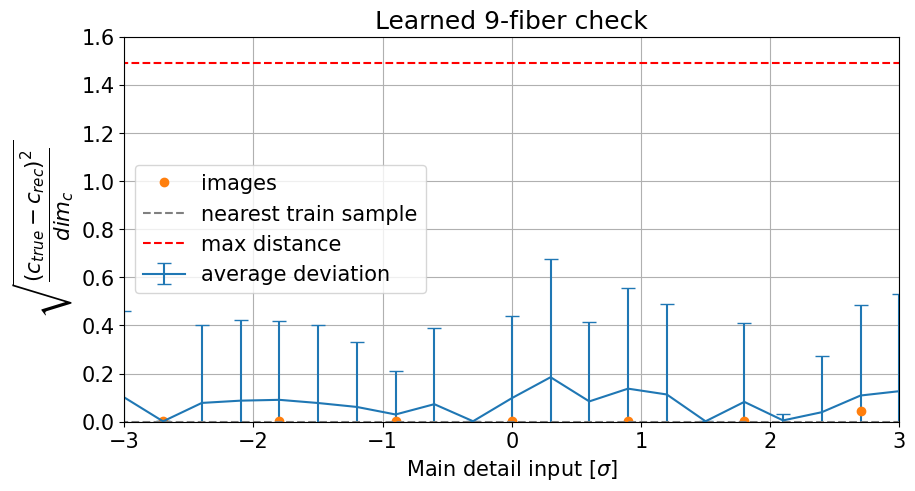

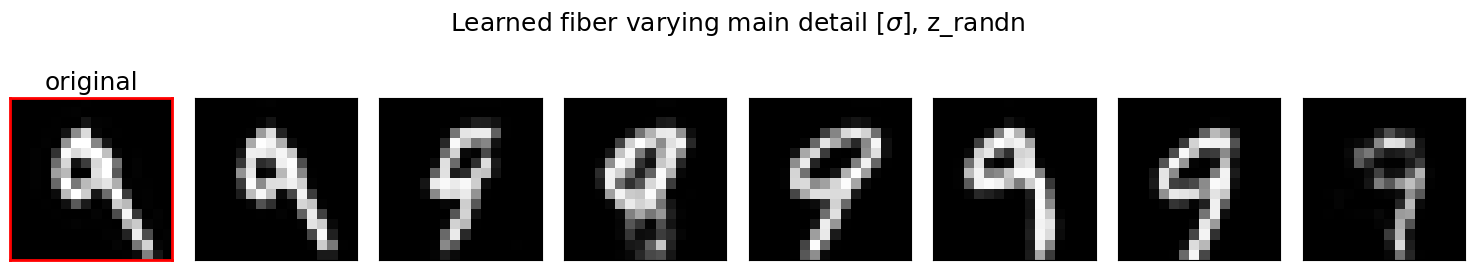

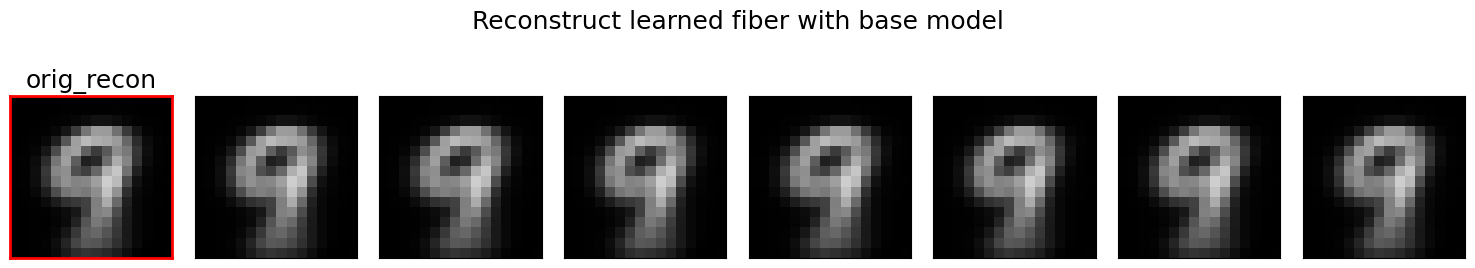

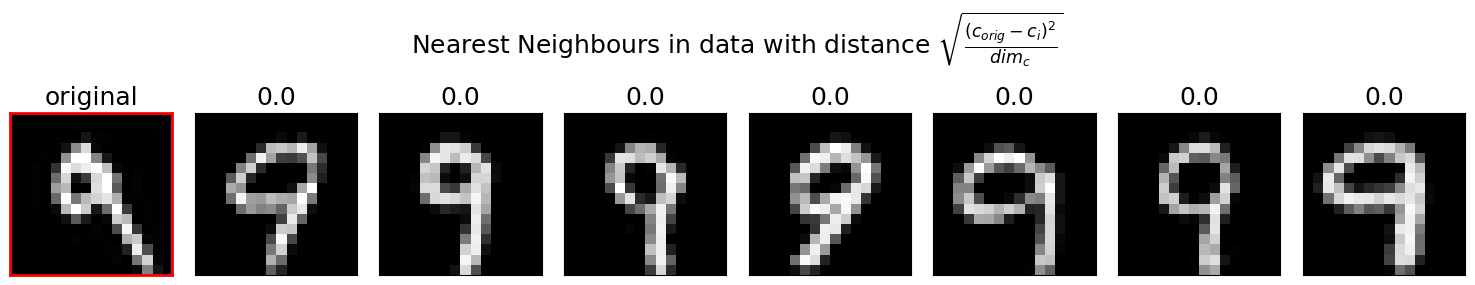

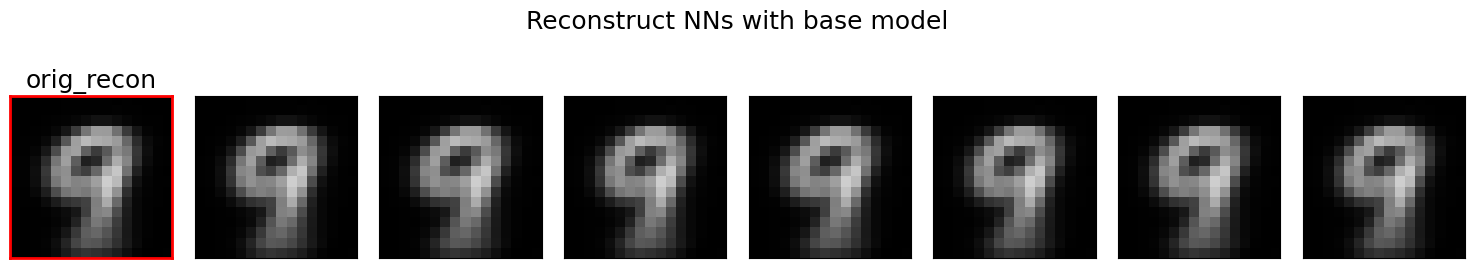

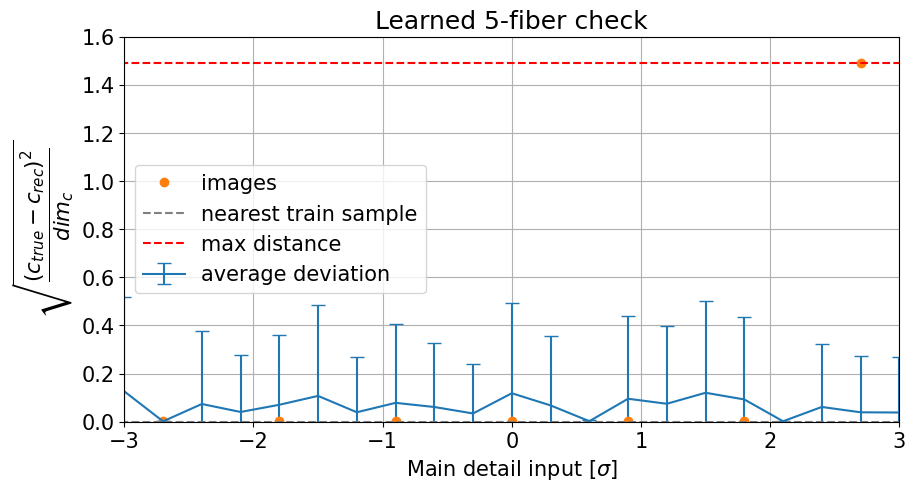

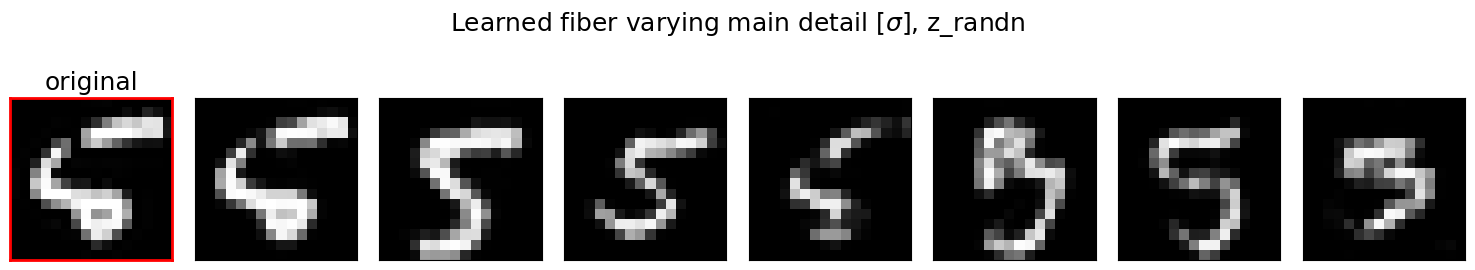

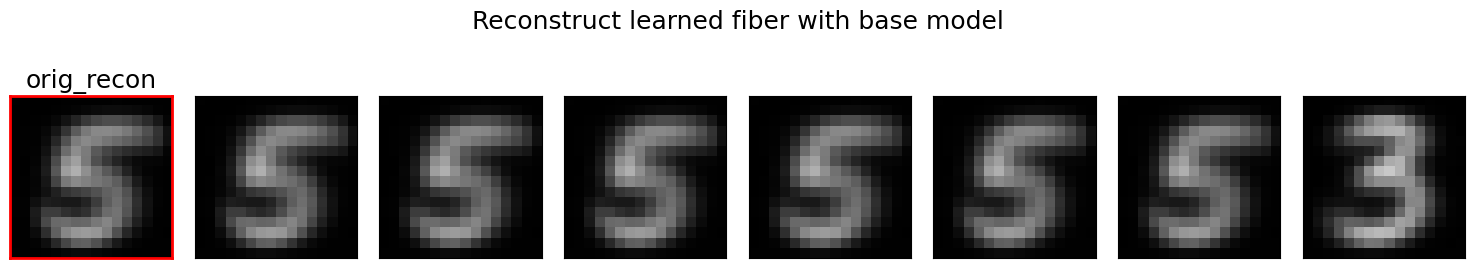

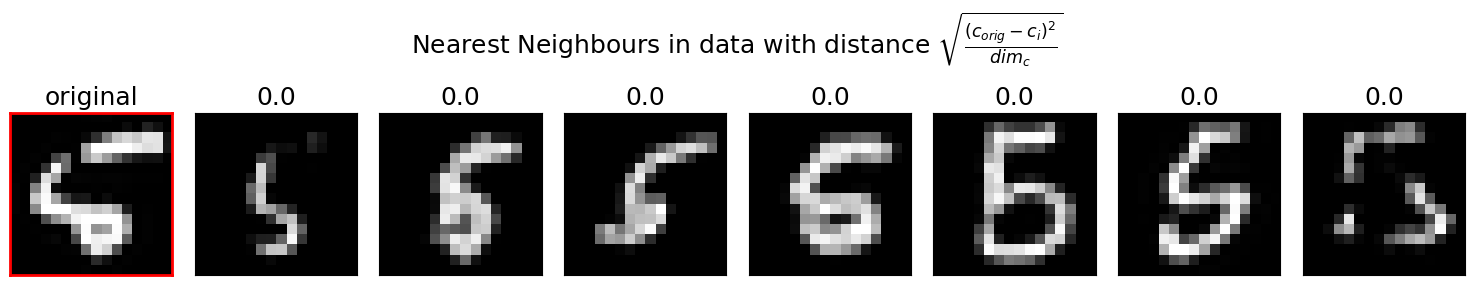

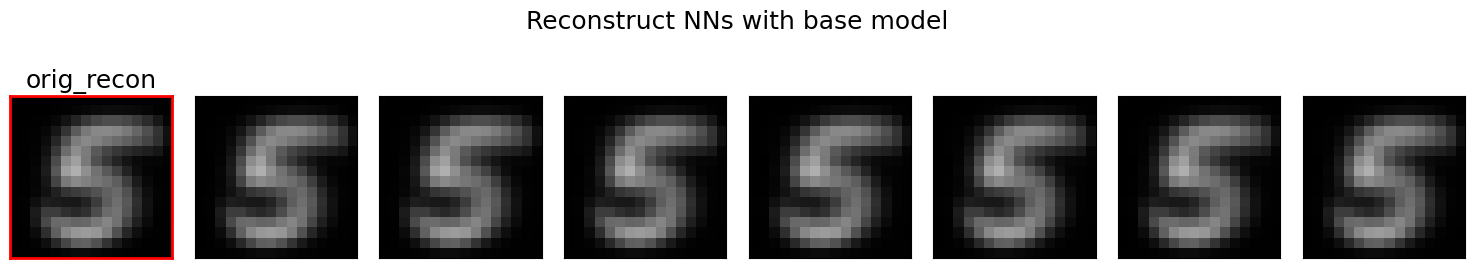

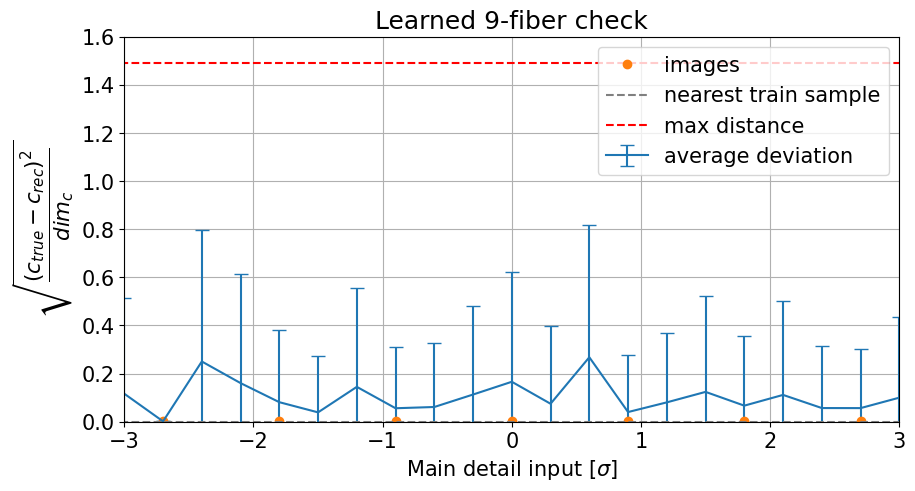

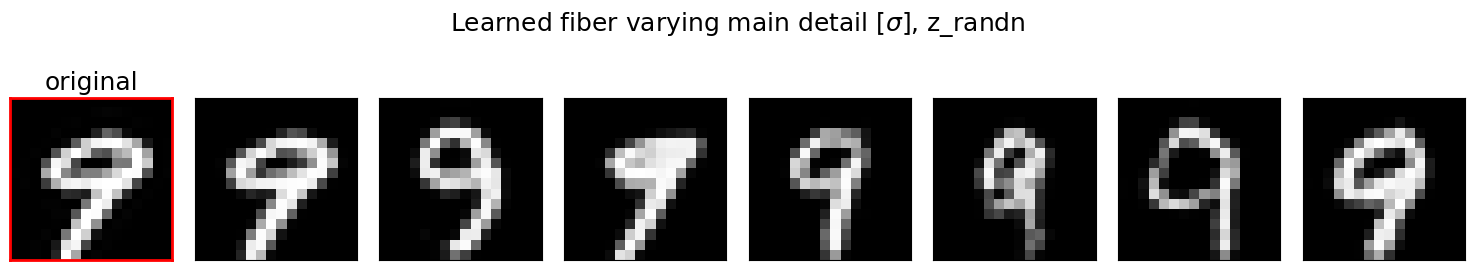

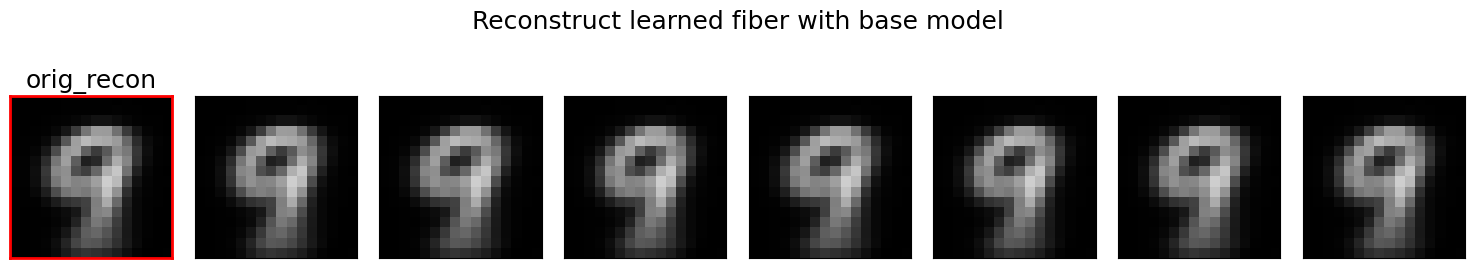

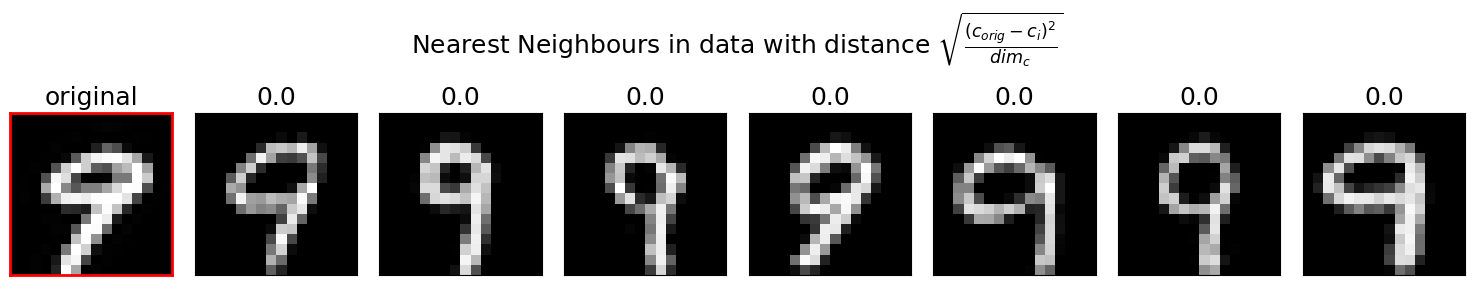

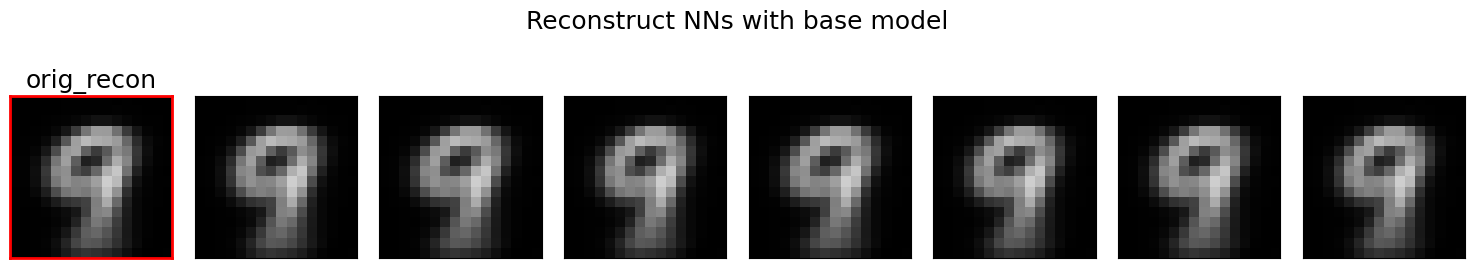

In [34]:
#Diffusion
zrange = 3*std_z0
matplotlib.rcParams.update({'font.size': 15})
nums = [7,2,1,0,4,1,4,9,5,9,0,6,9,0,1,5,9,7,3,4,0,0,0,0,0,0,0,0,0,0,0,0]
ran = np.arange(10)

for j in ran:
    plot_details(model, data, j, zrange, 0)

tensor(1.4920)
tensor(1.4920)
tensor(0.4990)
tensor(1.4617)
tensor(1.4920)


/tmp/ipykernel_2644688/3457698026.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[10,5])


tensor(1.4920)
tensor(1.4920)
tensor(1.4920)
tensor(1.4920)
tensor(1.4920)


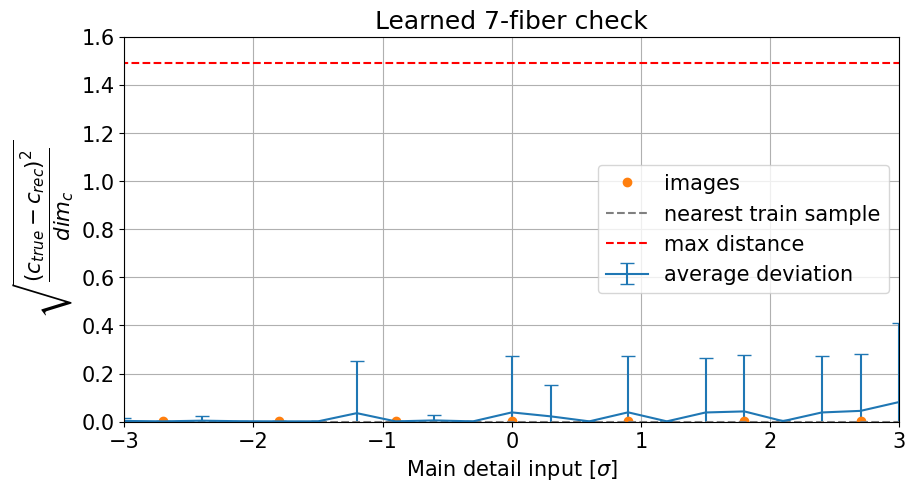

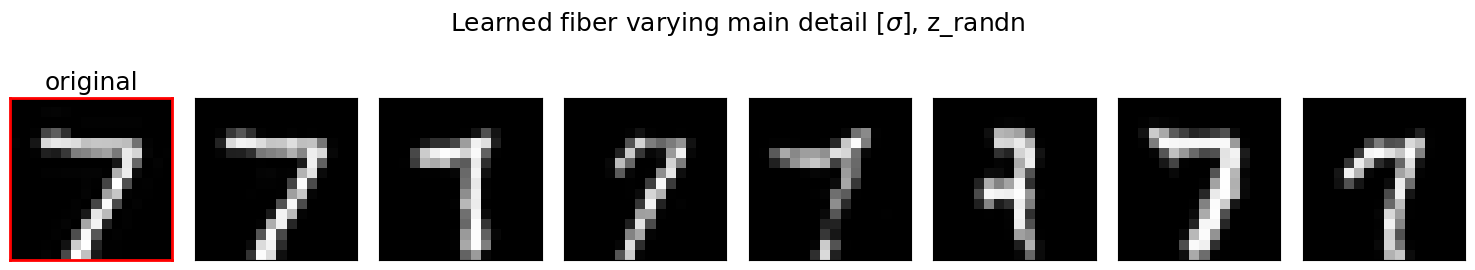

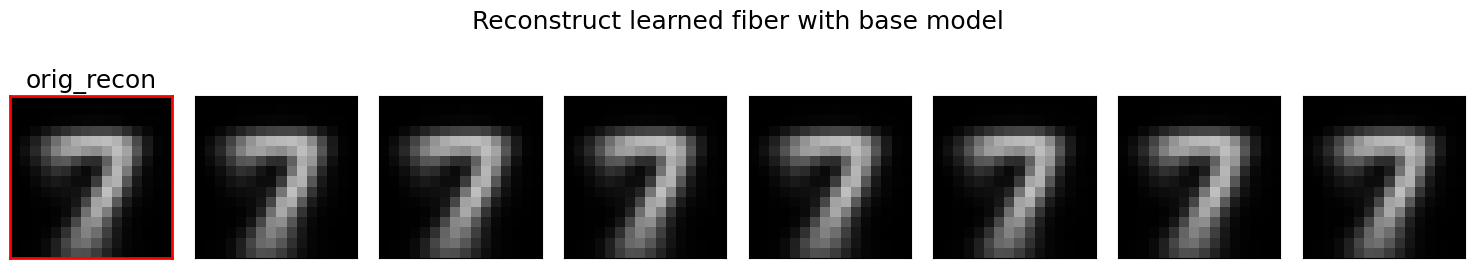

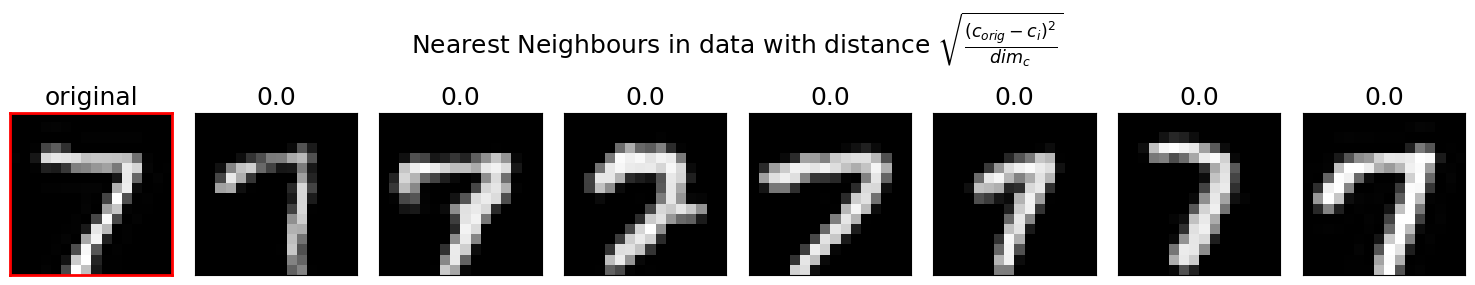

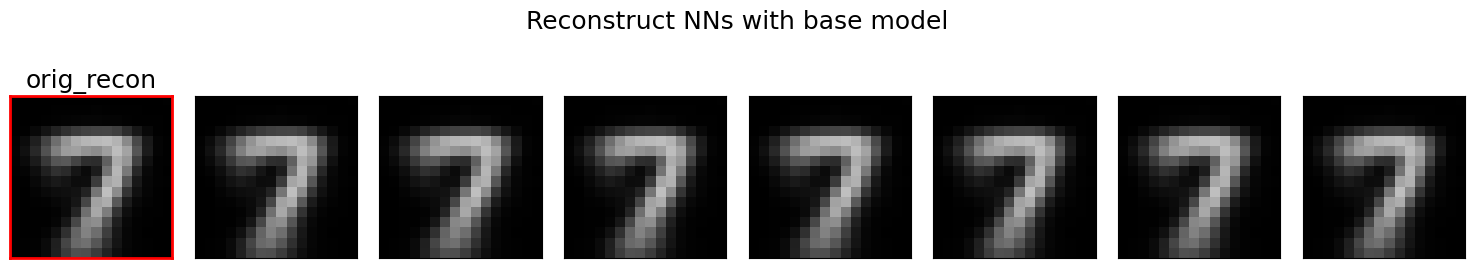

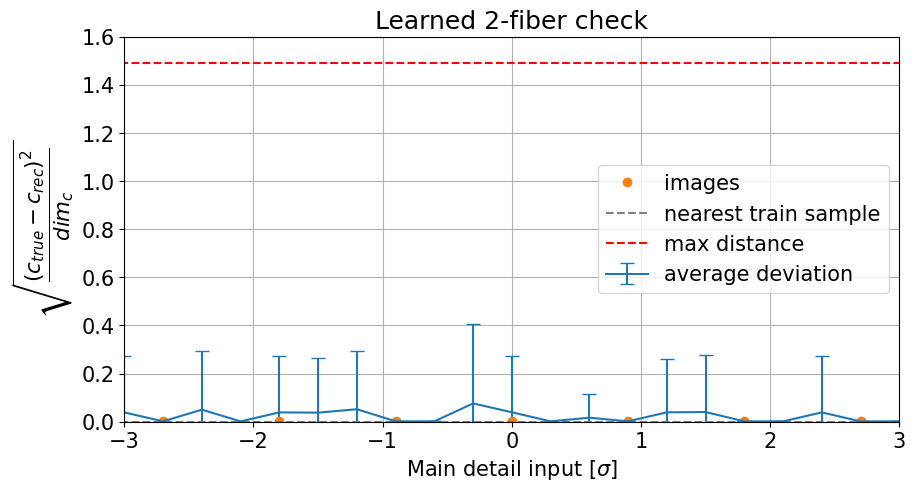

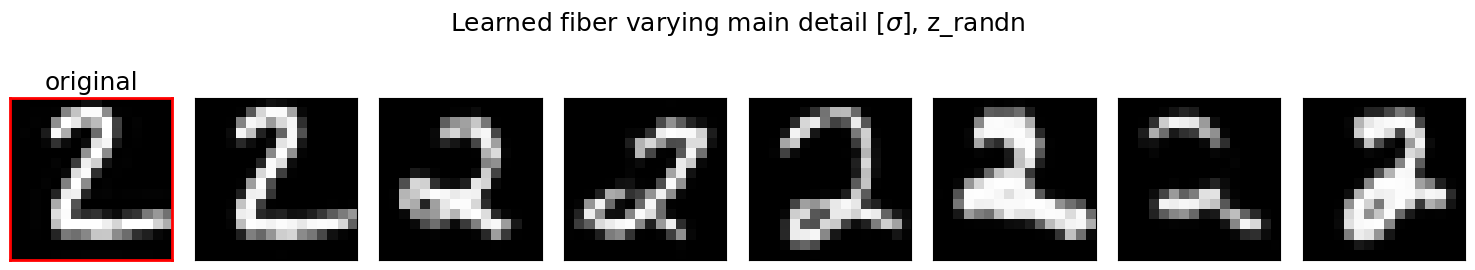

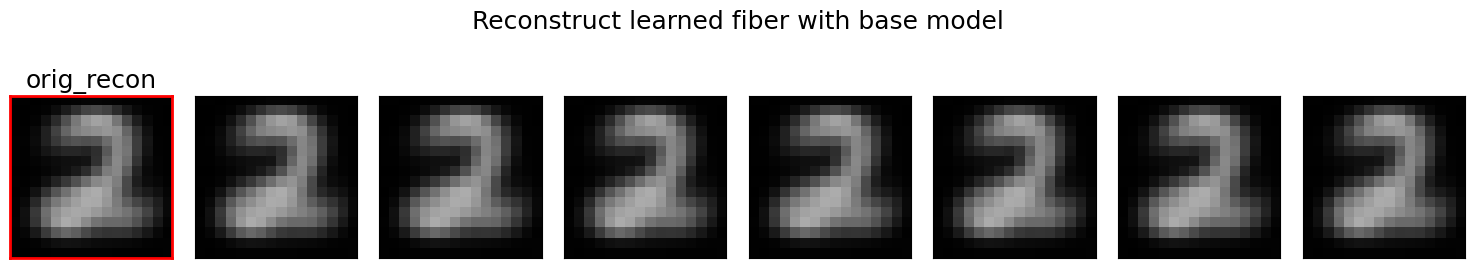

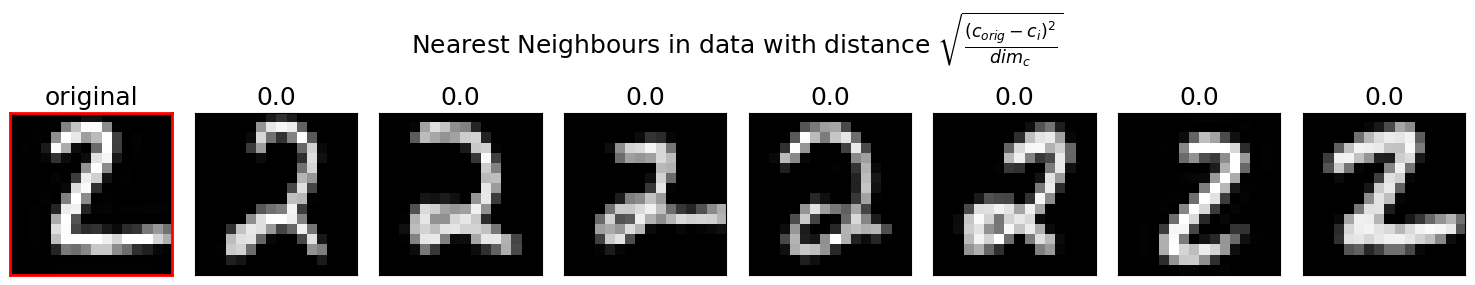

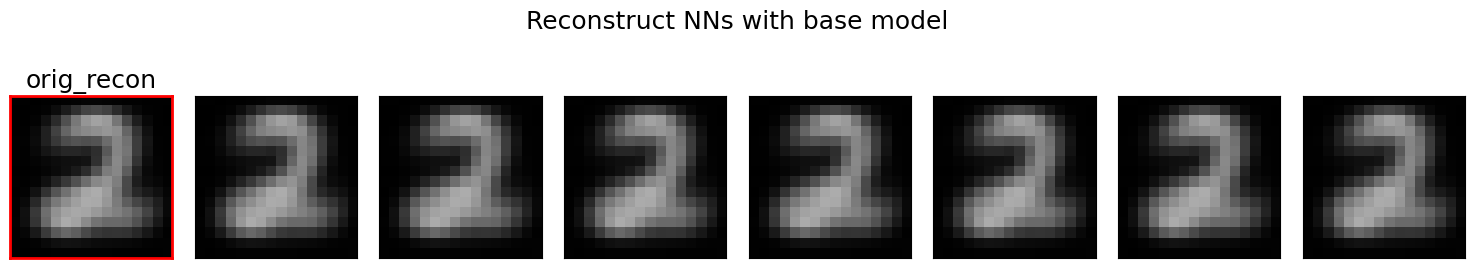

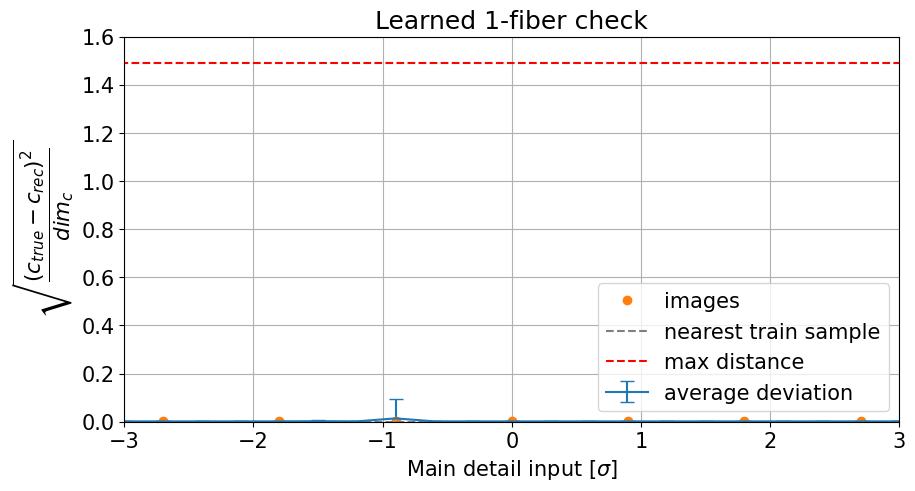

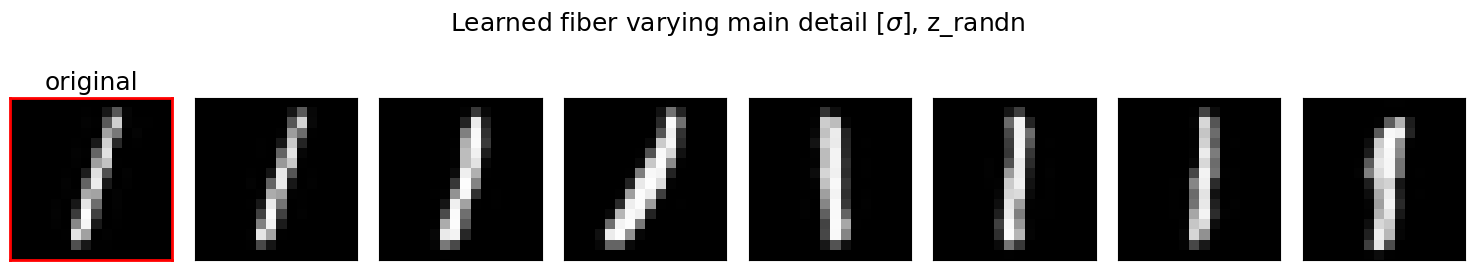

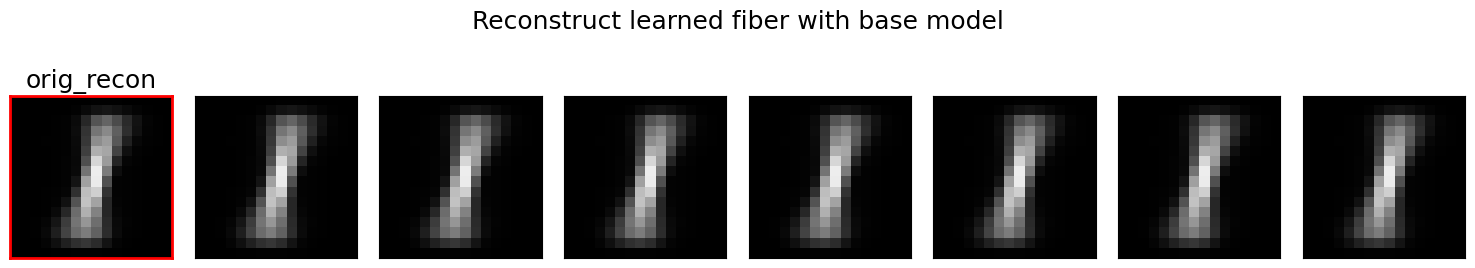

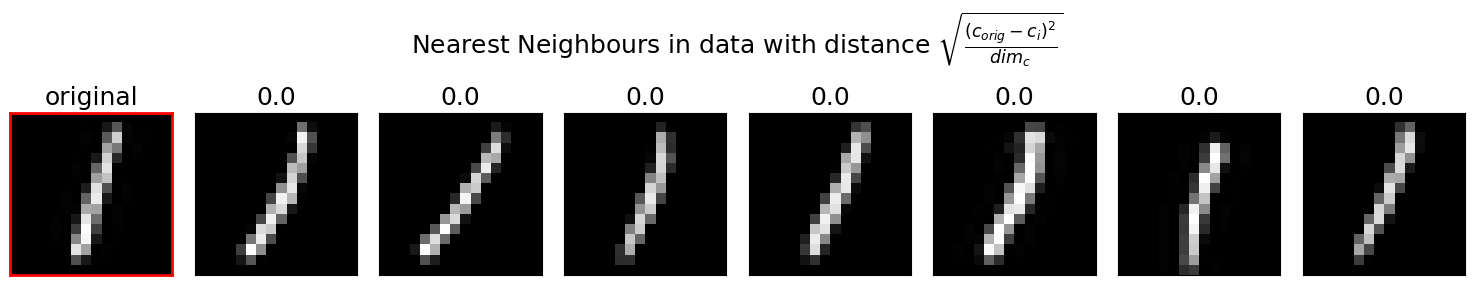

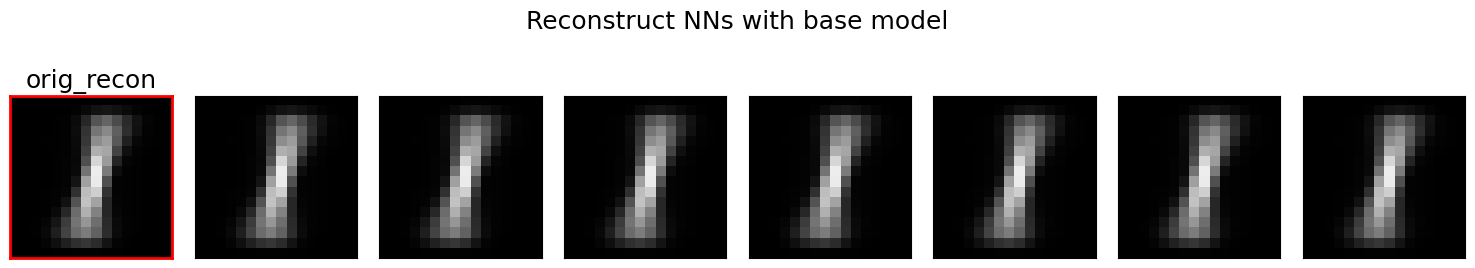

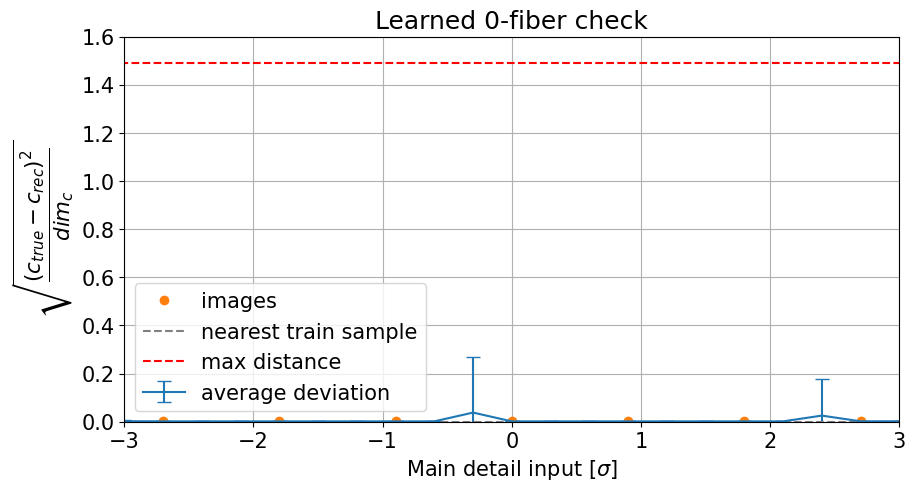

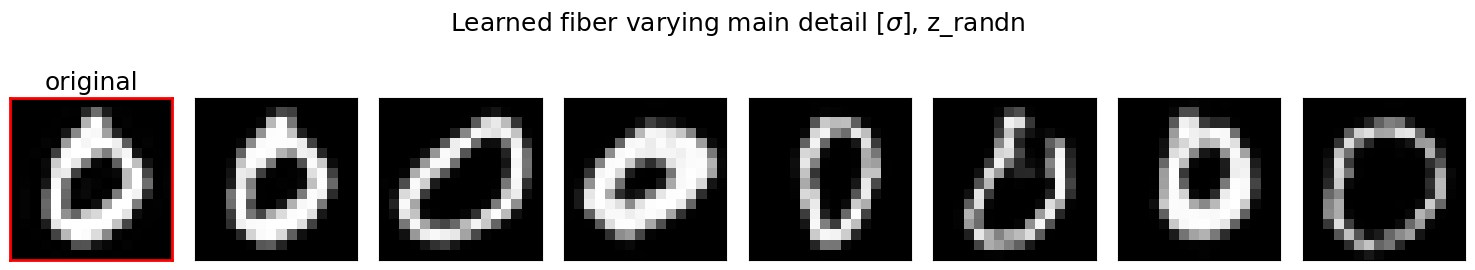

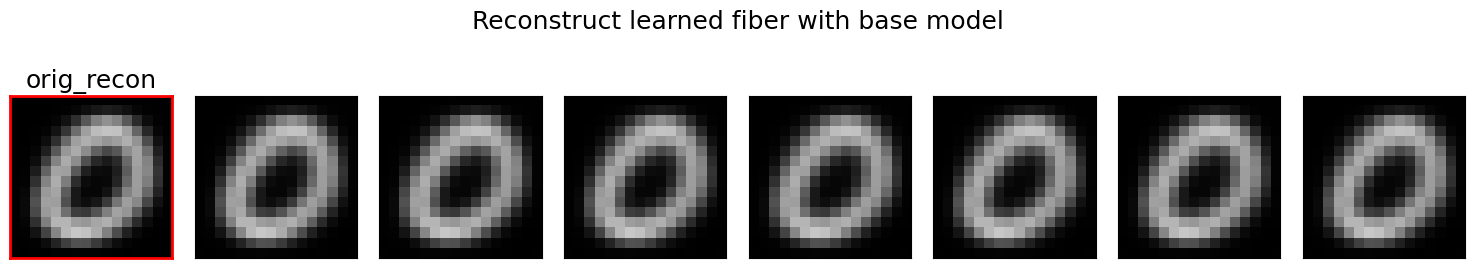

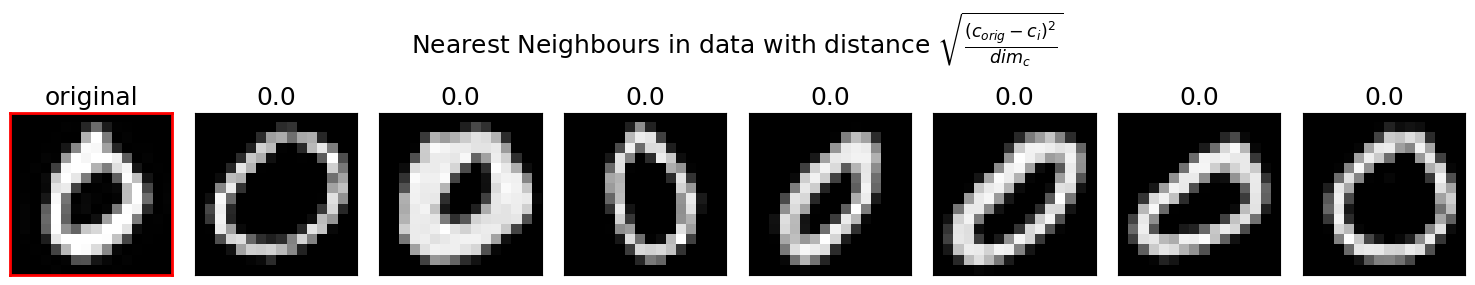

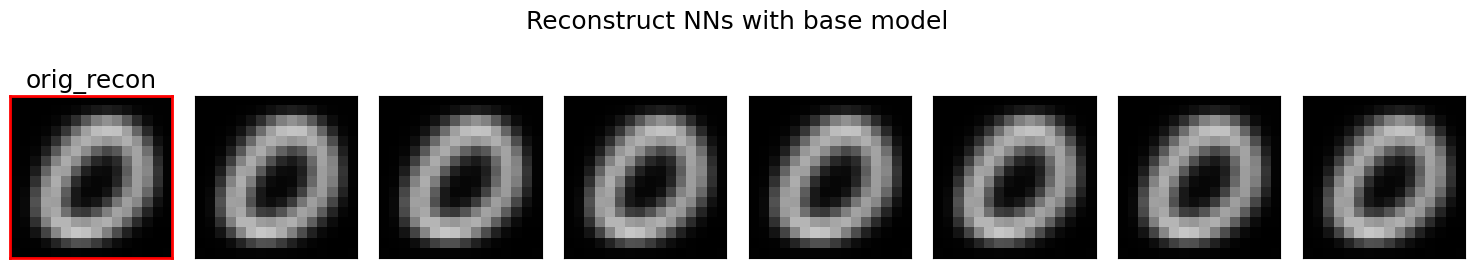

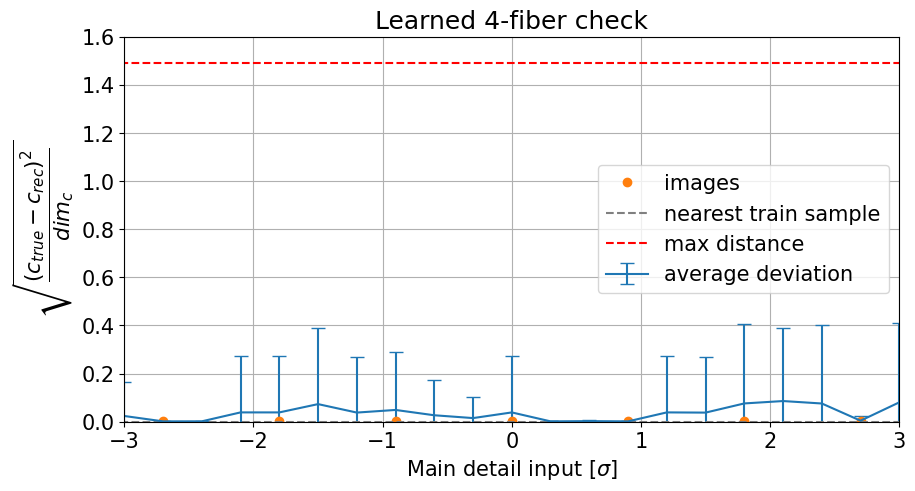

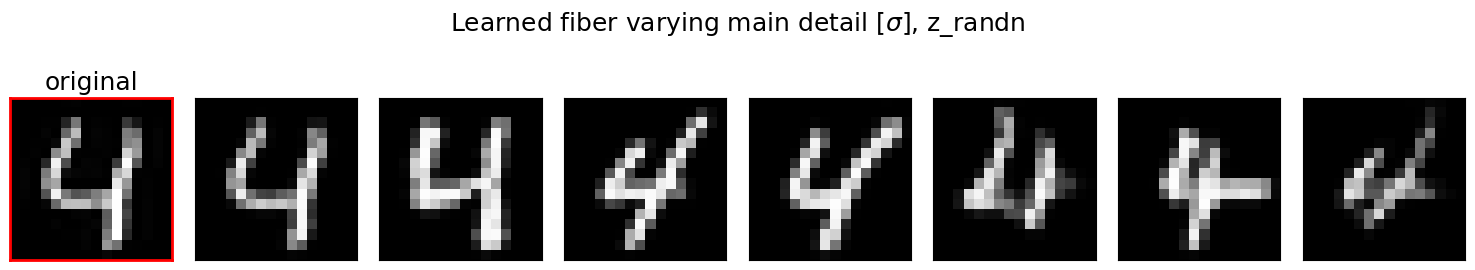

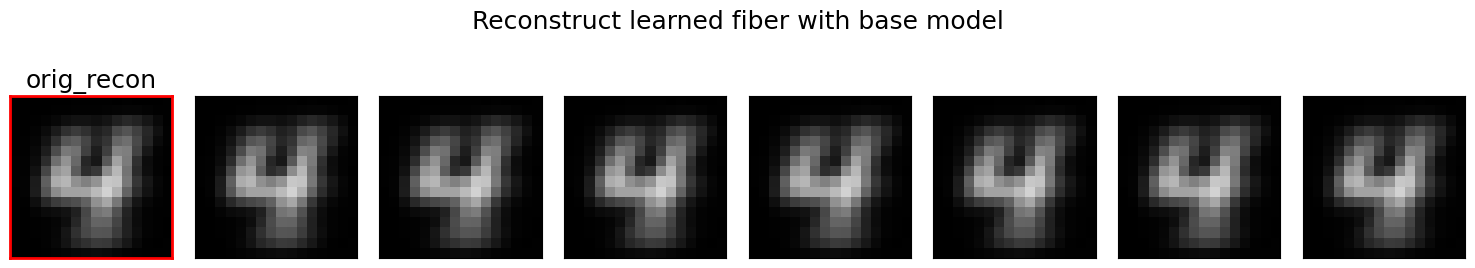

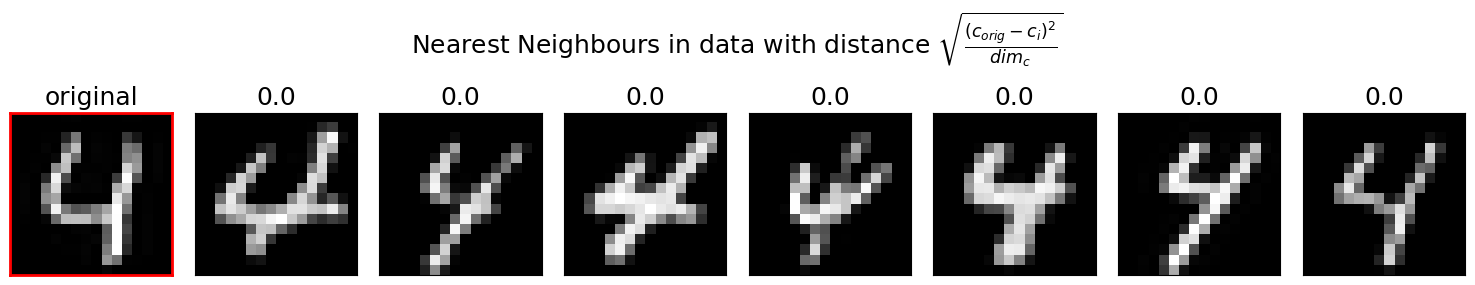

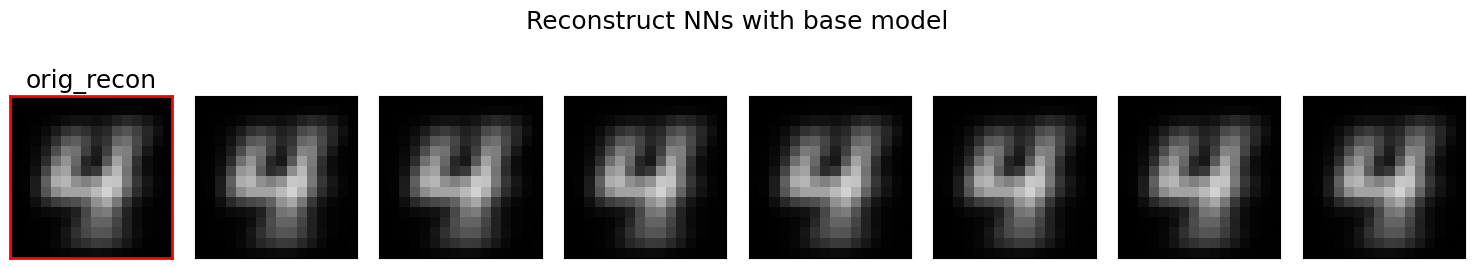

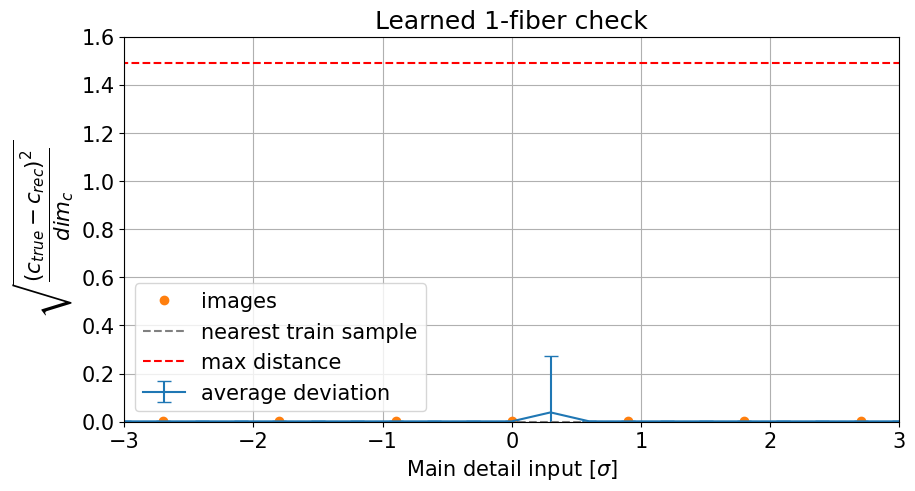

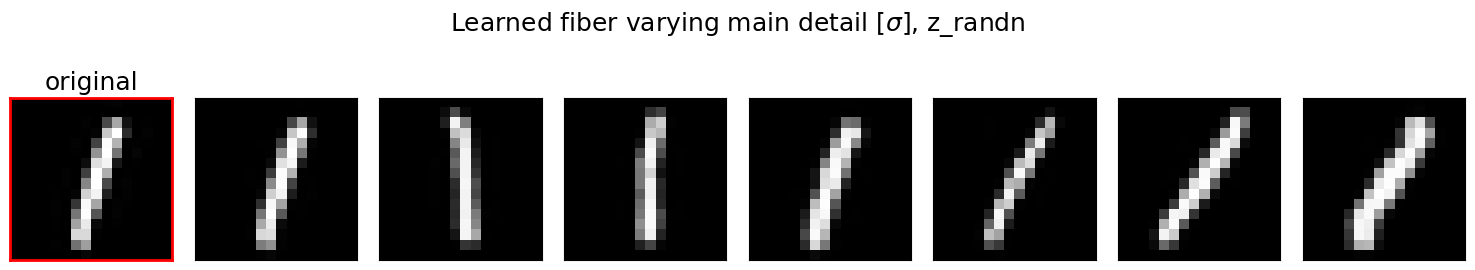

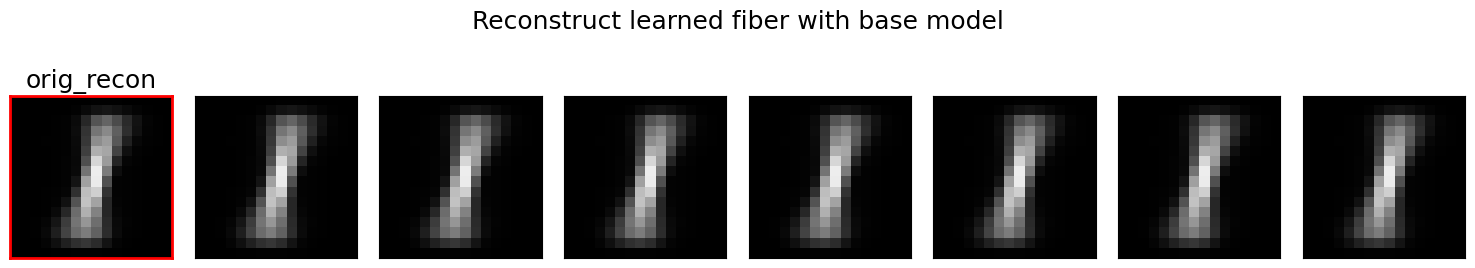

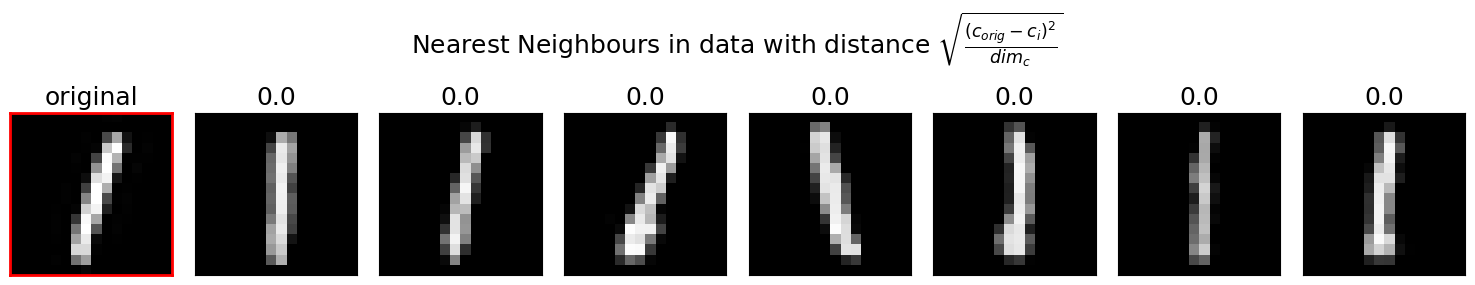

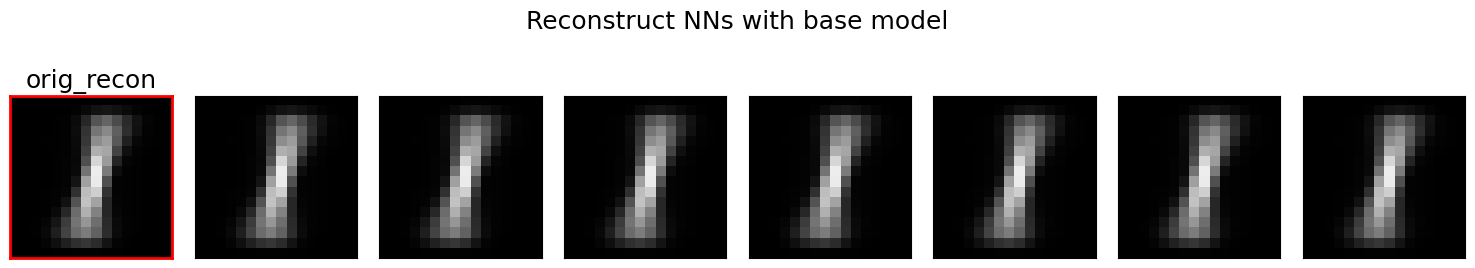

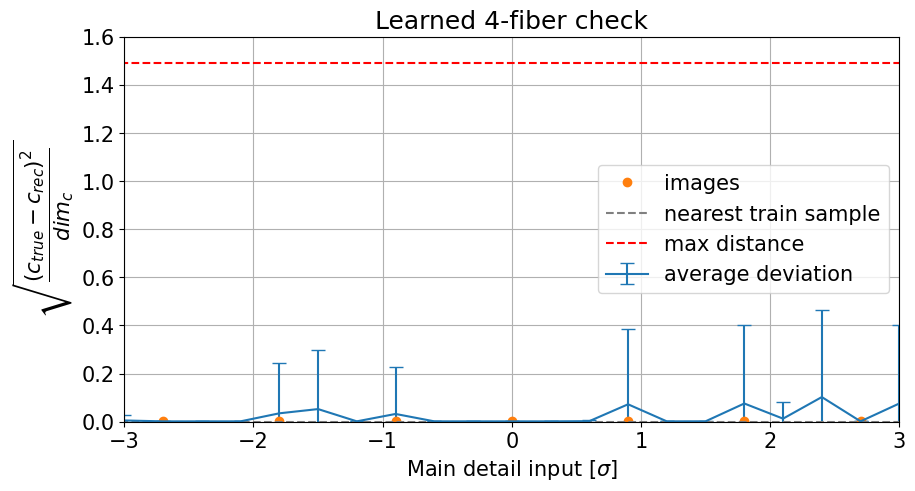

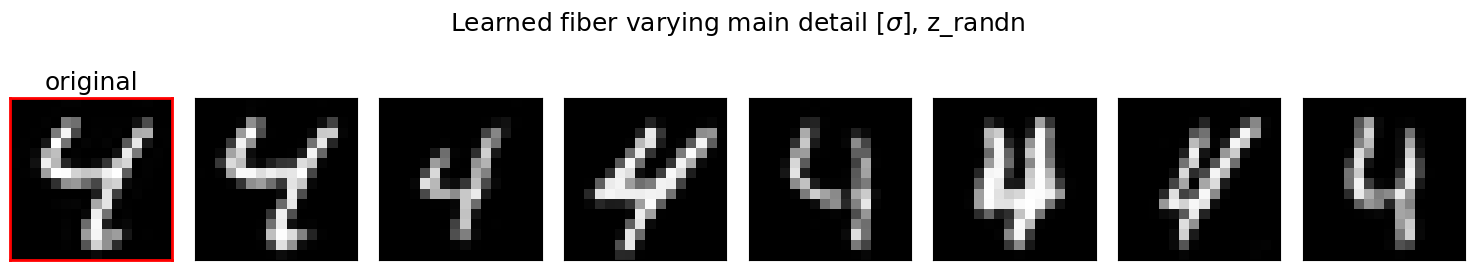

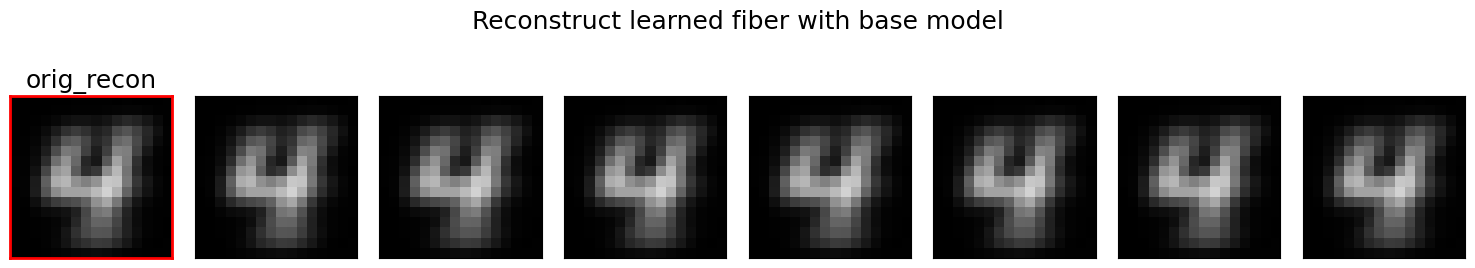

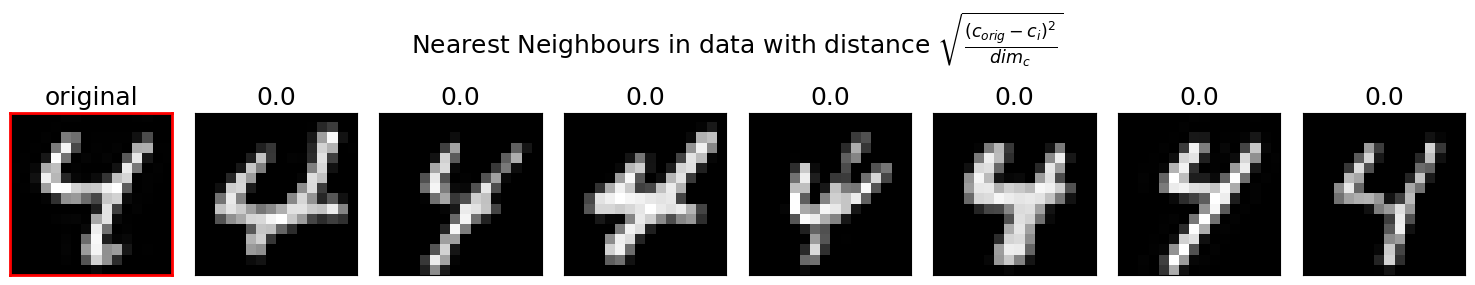

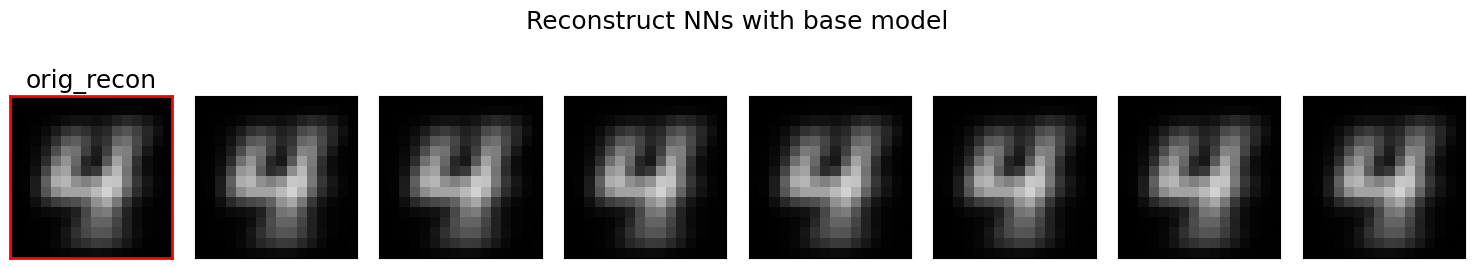

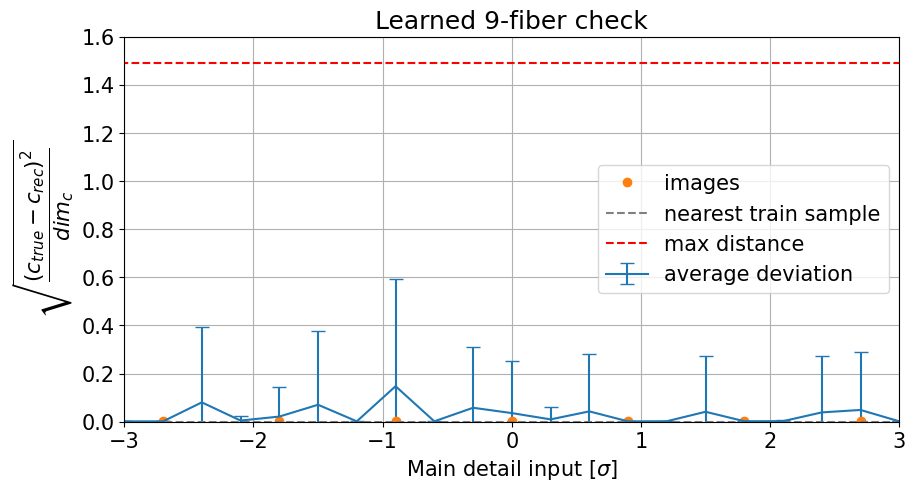

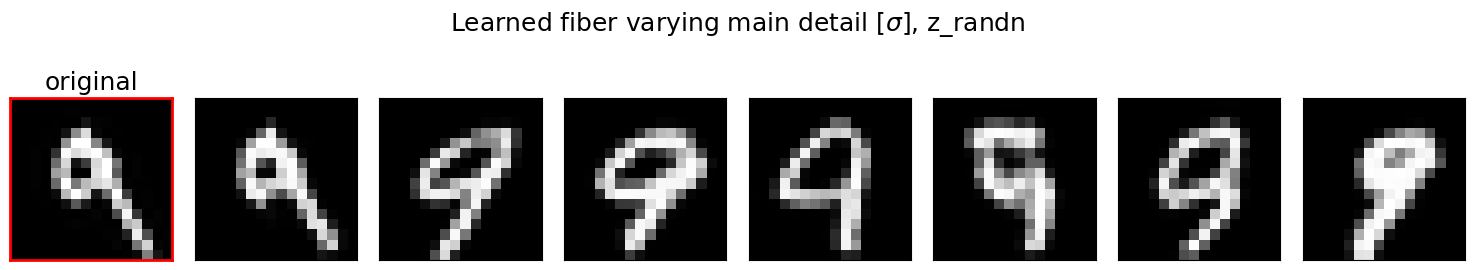

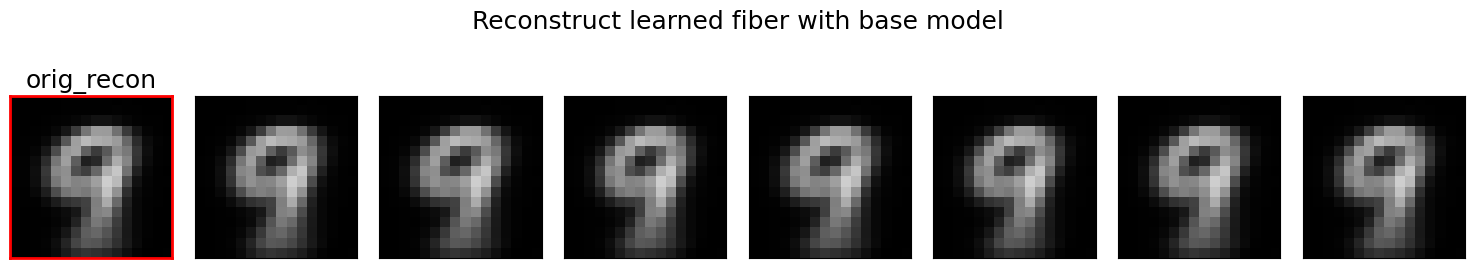

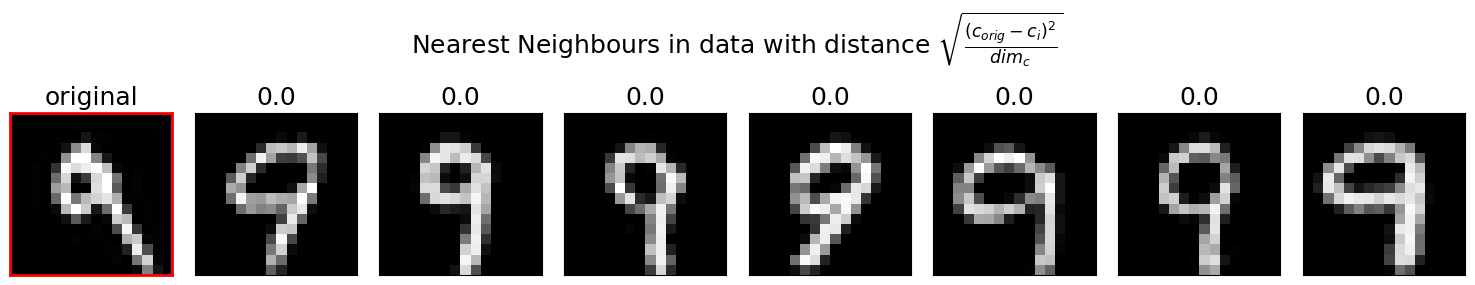

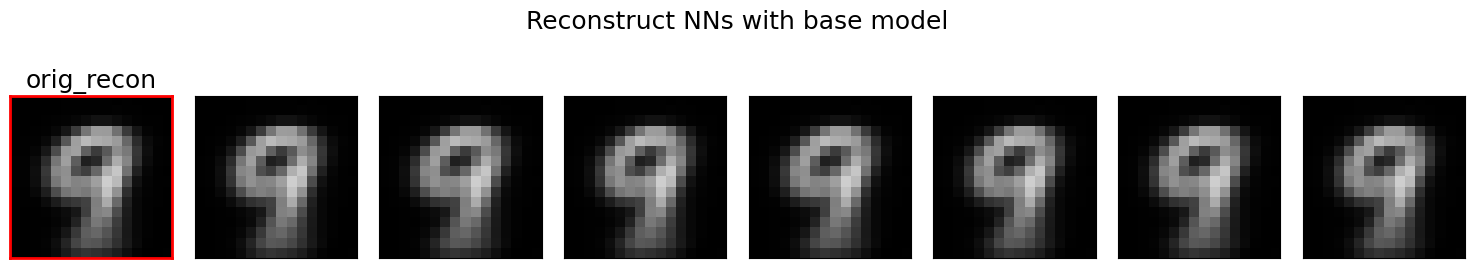

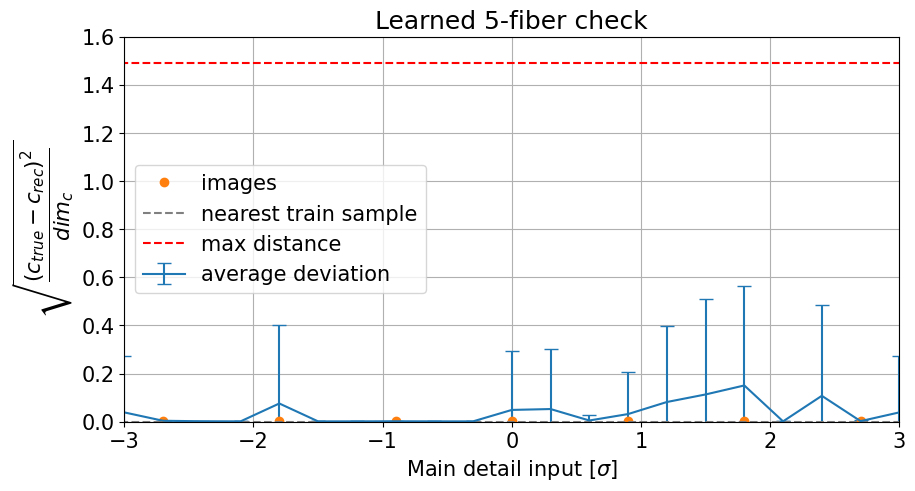

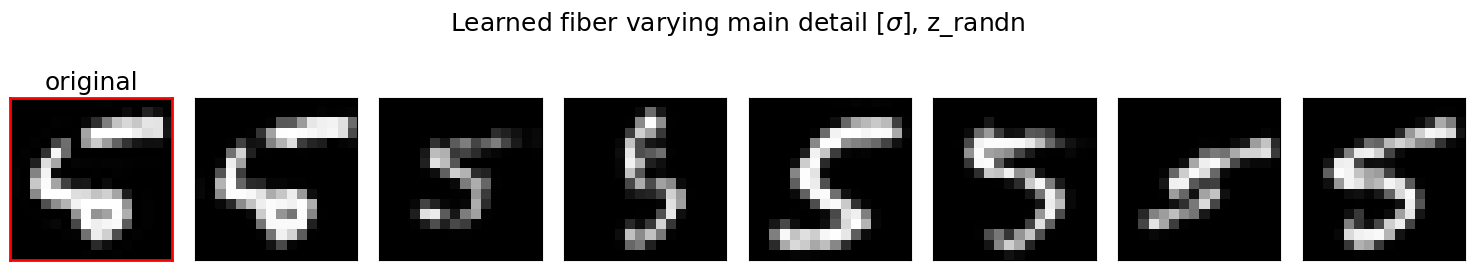

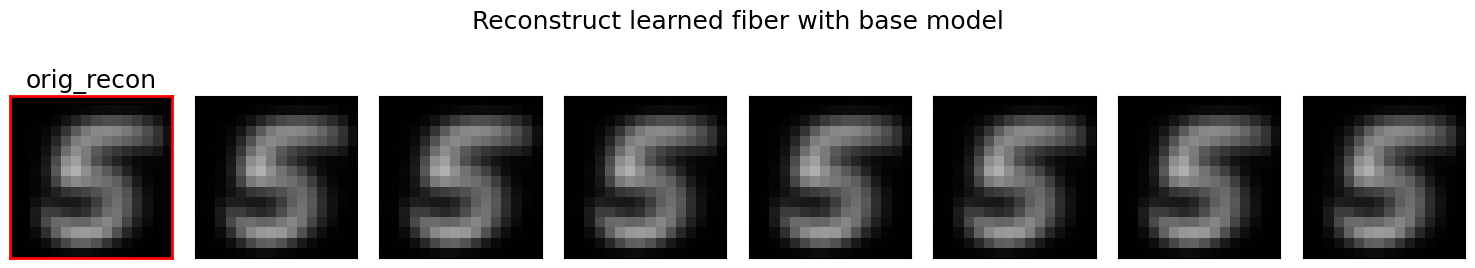

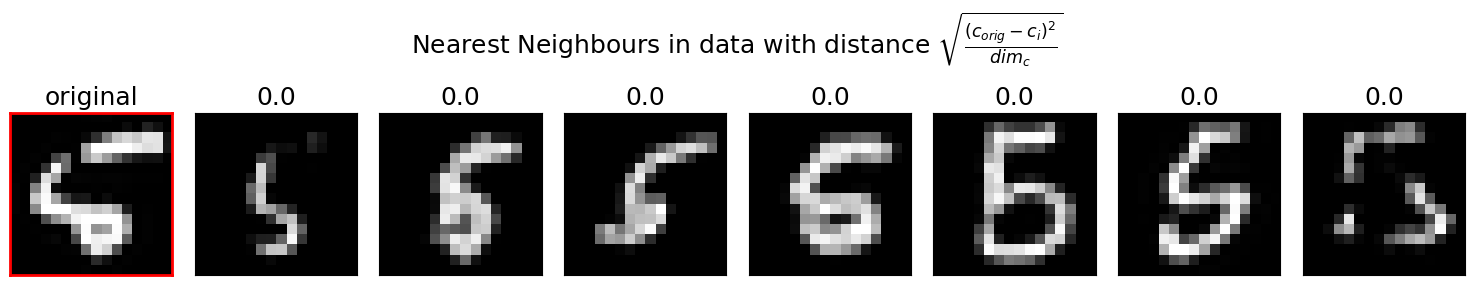

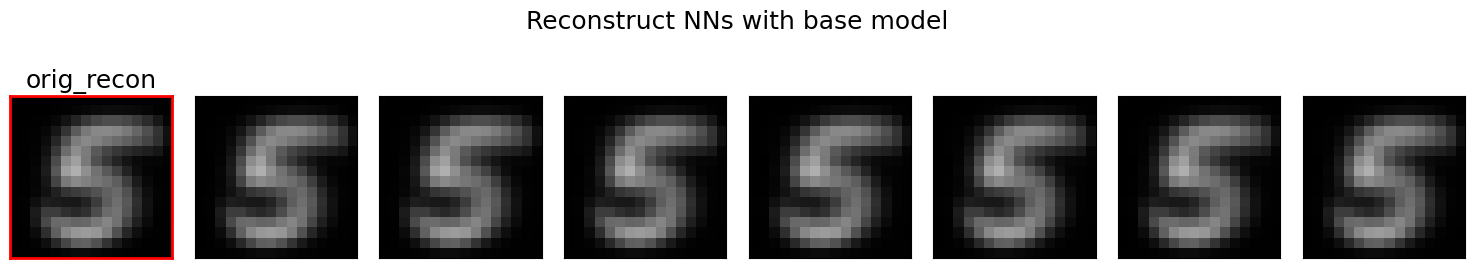

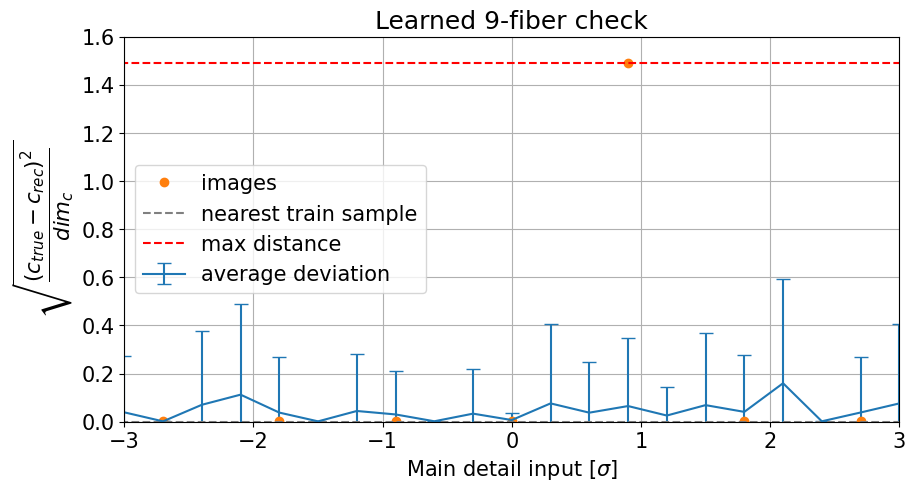

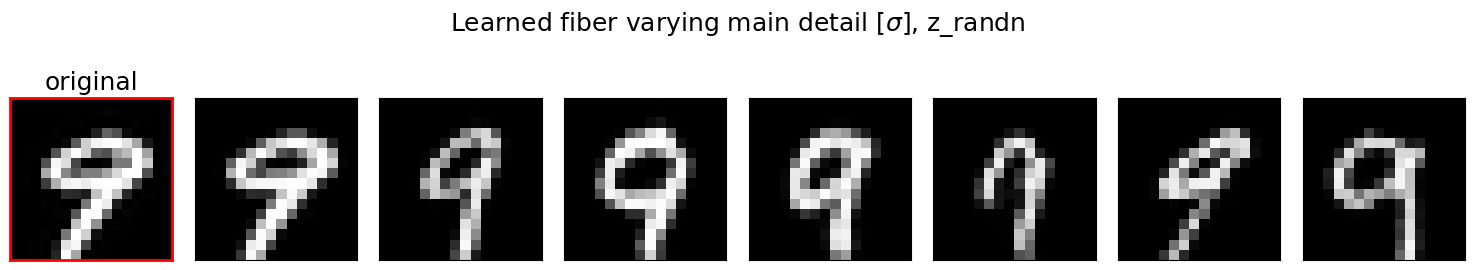

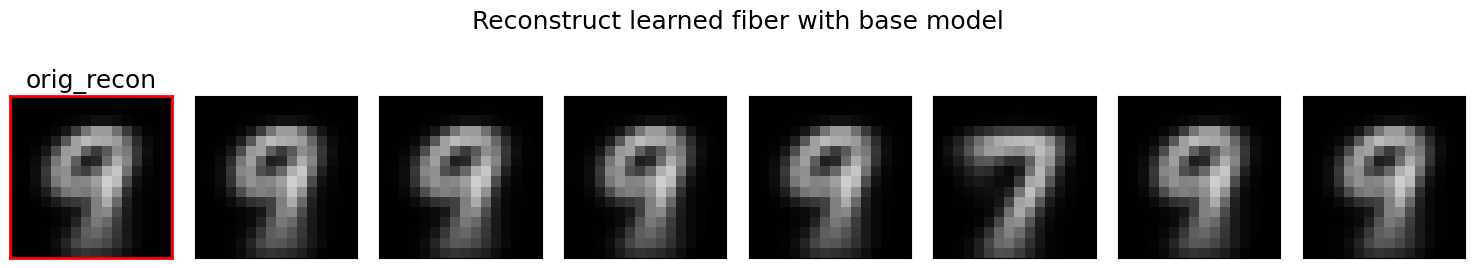

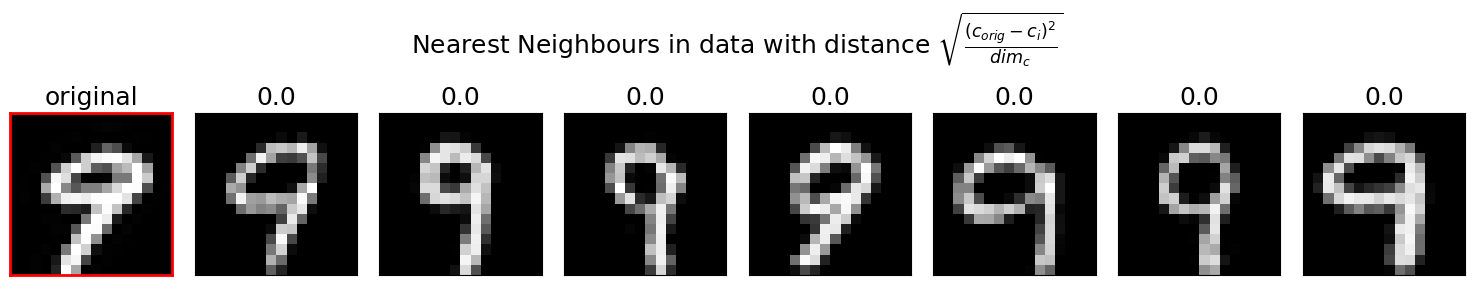

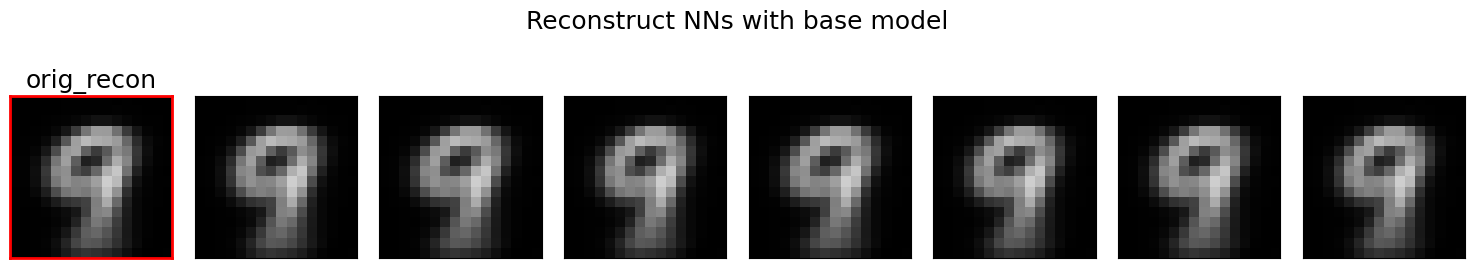

In [38]:
#FIF
zrange = 3*std_z0
matplotlib.rcParams.update({'font.size': 15})
nums = [7,2,1,0,4,1,4,9,5,9,0,6,9,0,1,5,9,7,3,4,0,0,0,0,0,0,0,0,0,0,0,0]
ran = np.arange(10)

for j in ran:
    plot_details(model, data, j, zrange, 0)

tensor(1.4920)
tensor(1.4919)
tensor(1.4920)
tensor(1.4877)
tensor(1.4920)


/tmp/ipykernel_2644688/3457698026.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[10,5])


tensor(1.4920)
tensor(1.4920)
tensor(1.4920)
tensor(1.4920)
tensor(1.4920)


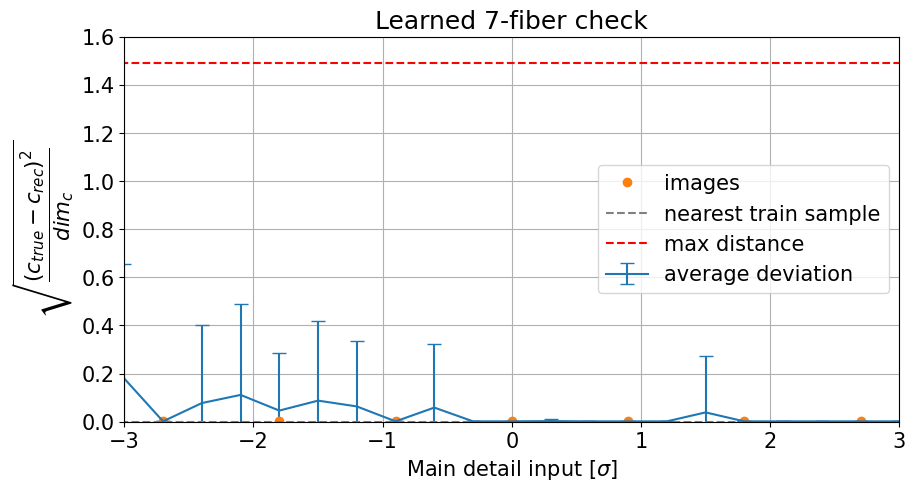

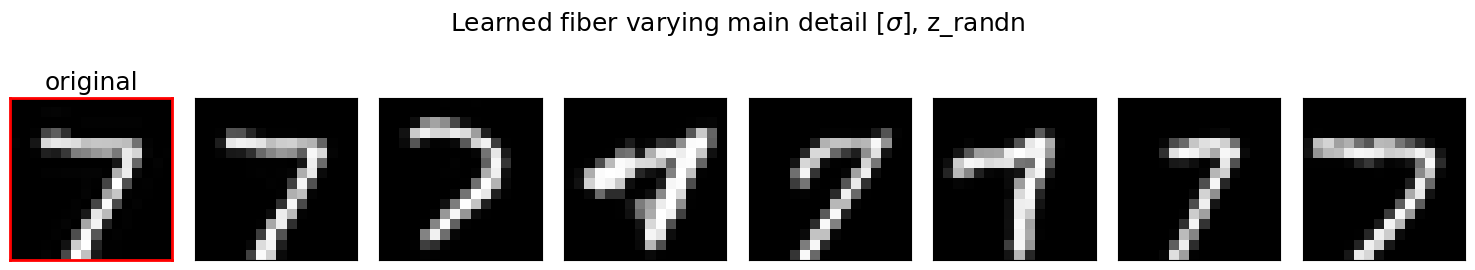

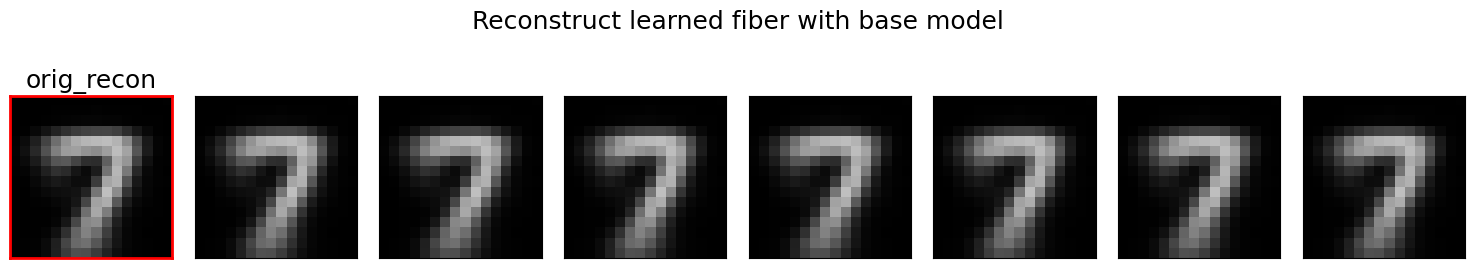

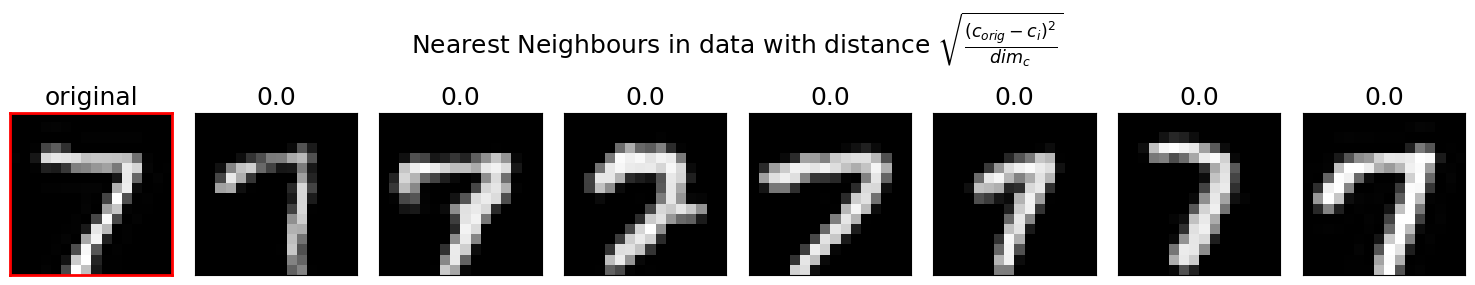

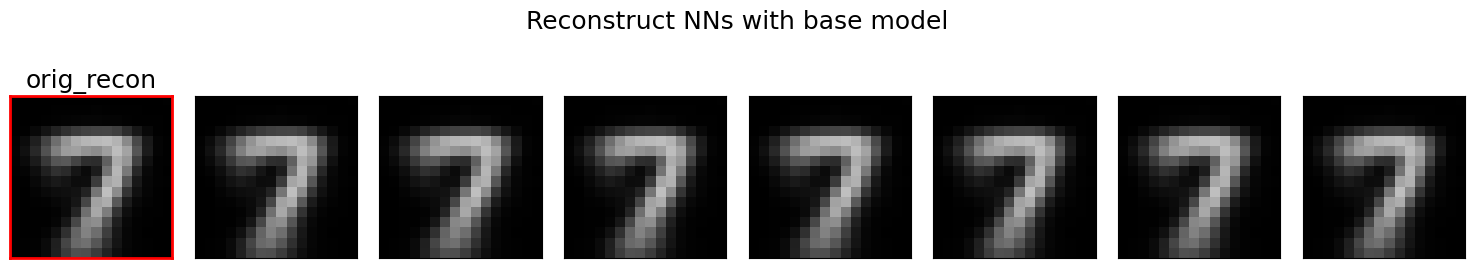

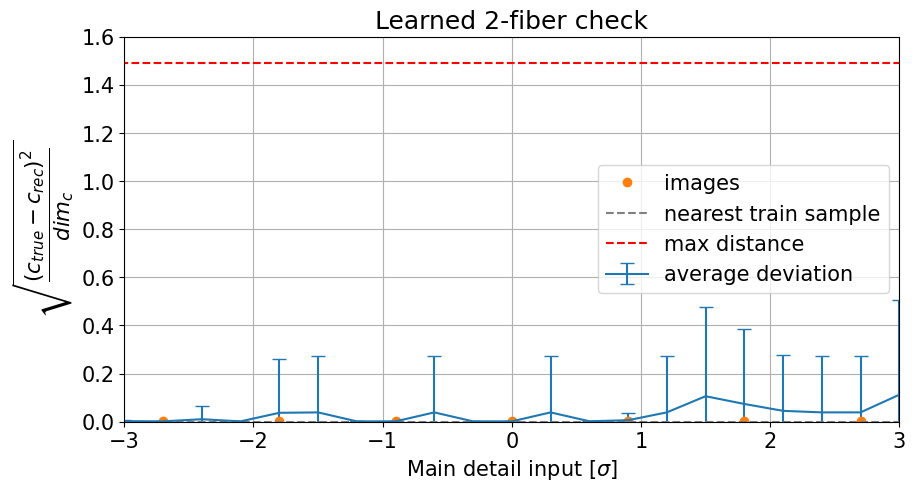

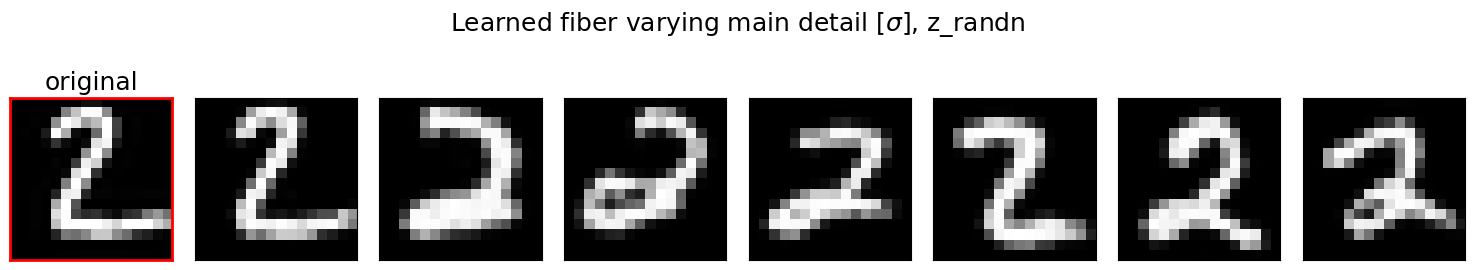

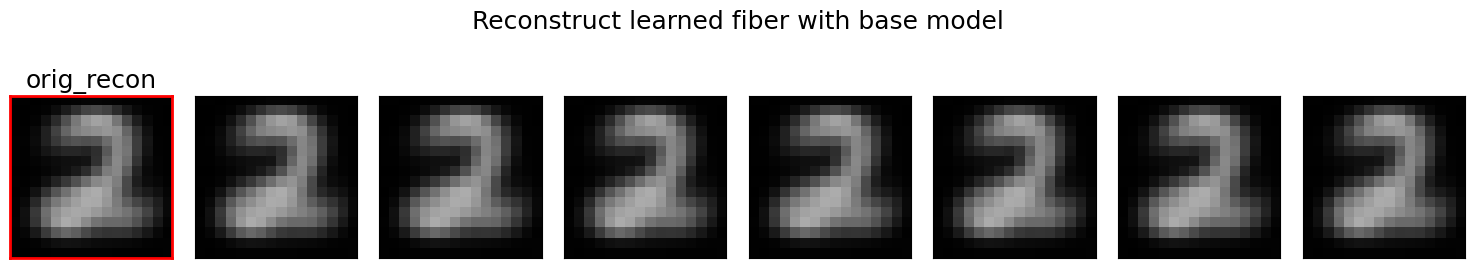

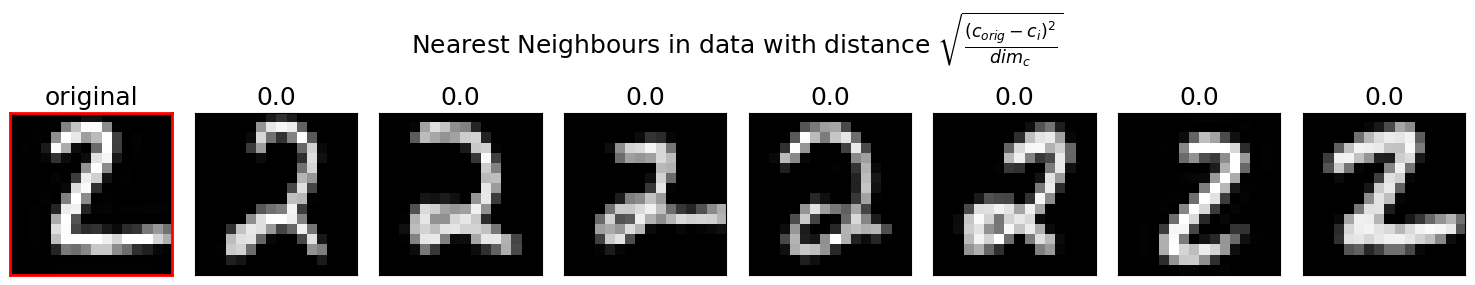

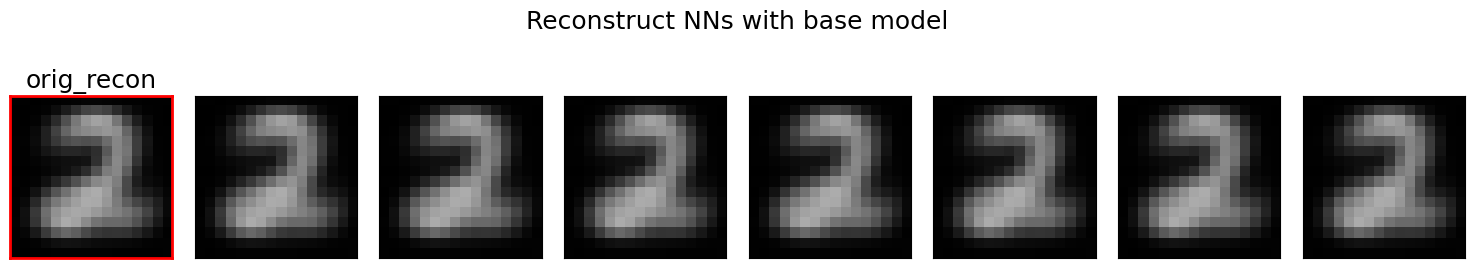

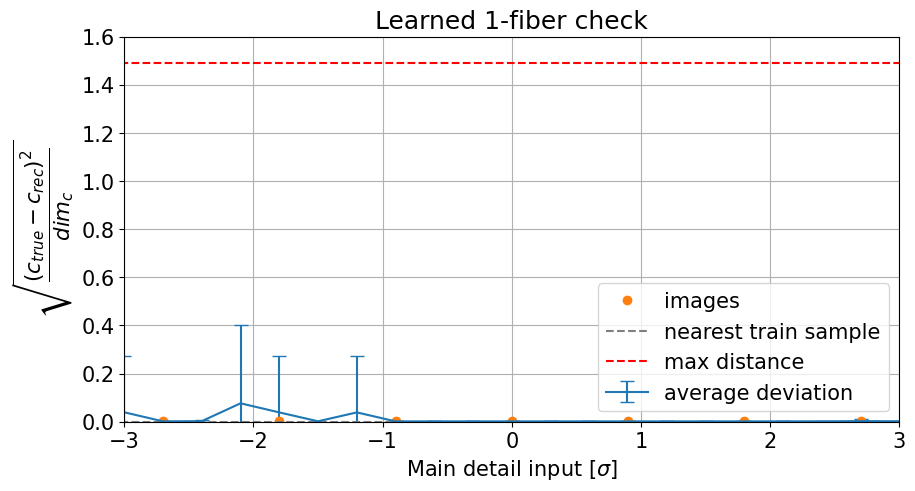

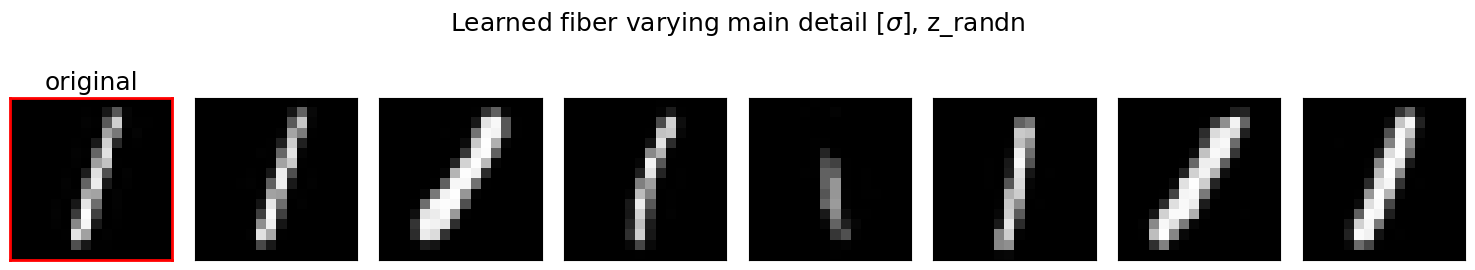

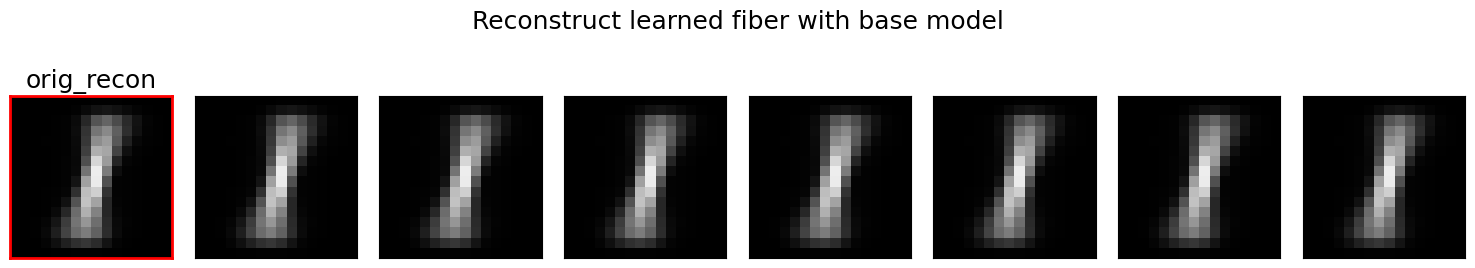

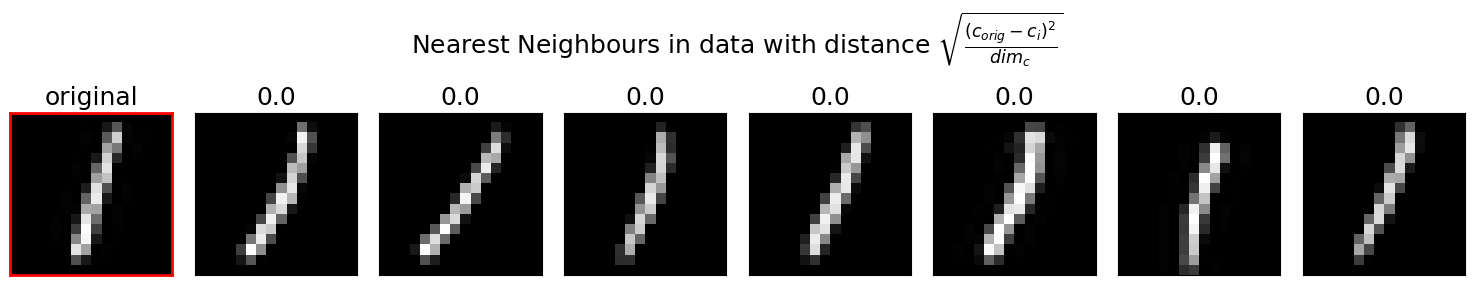

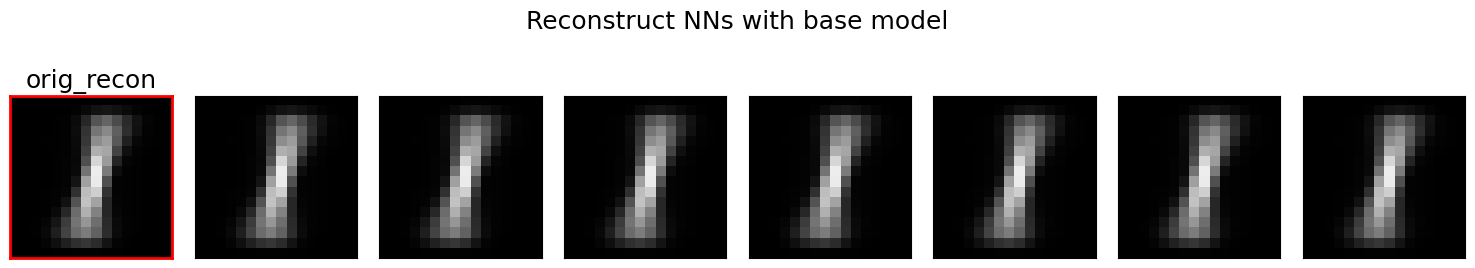

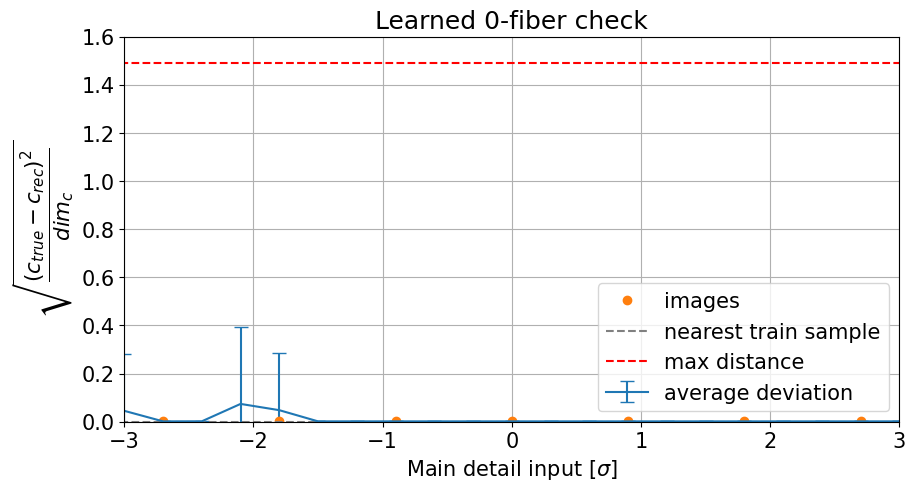

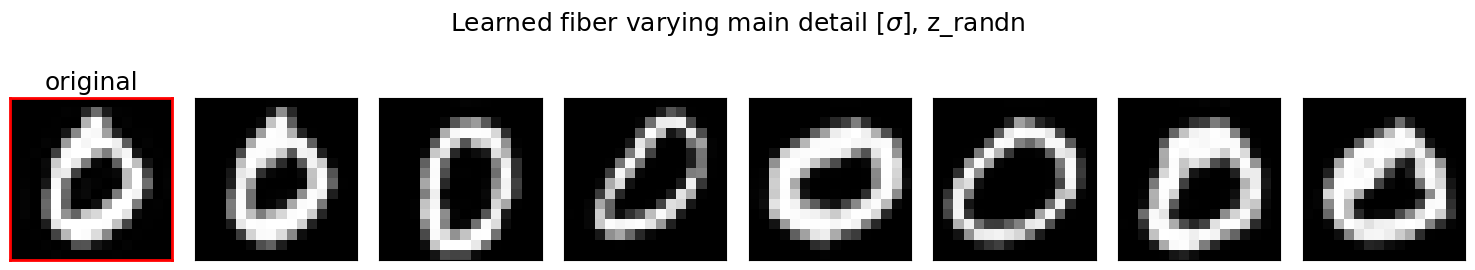

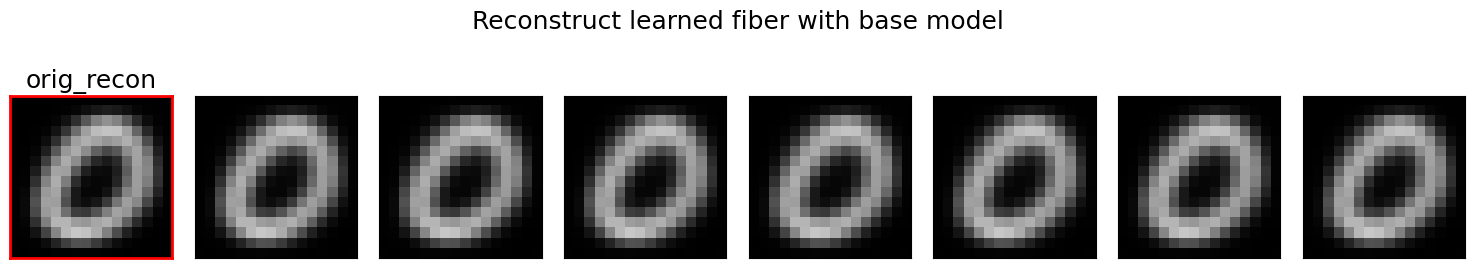

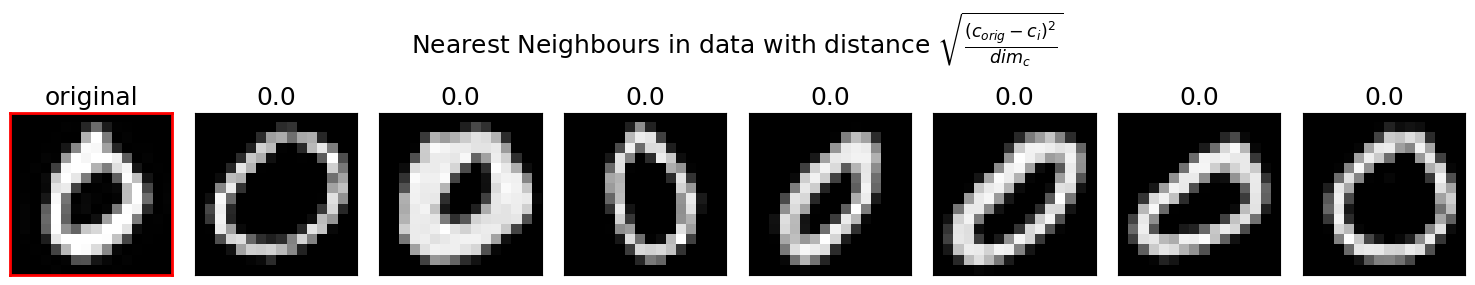

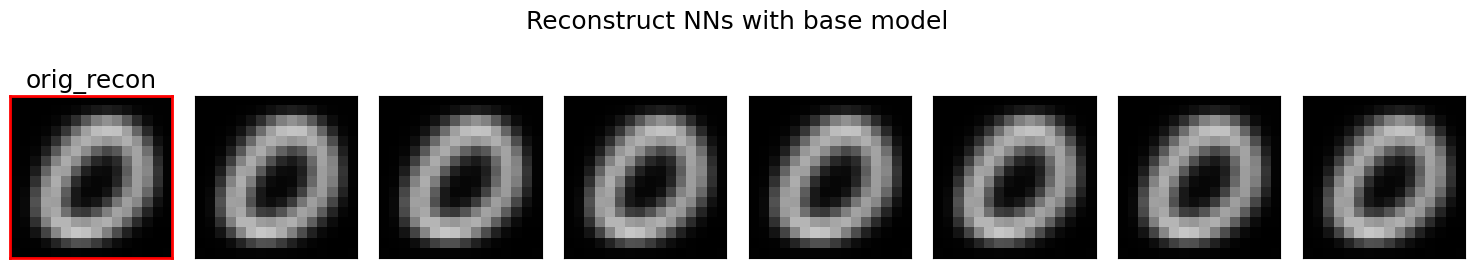

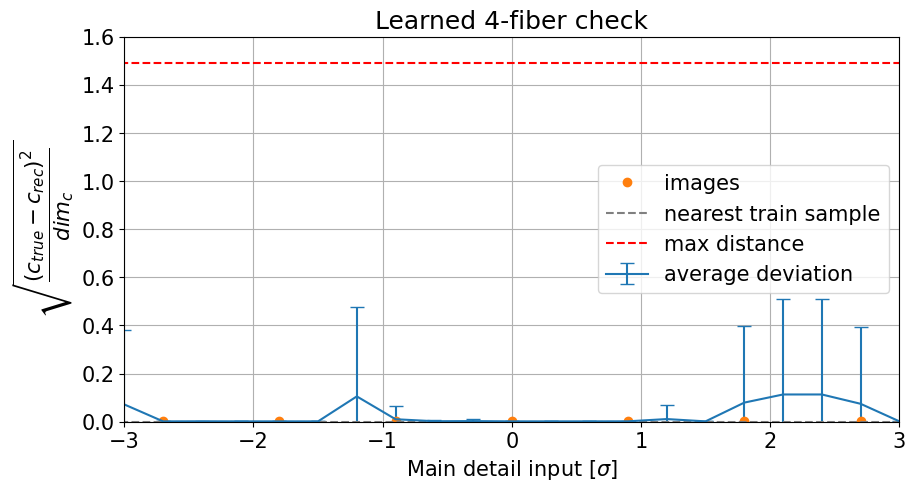

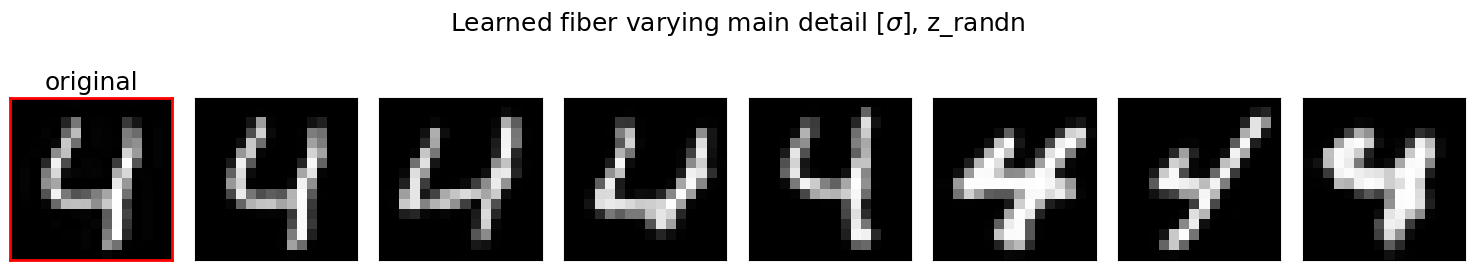

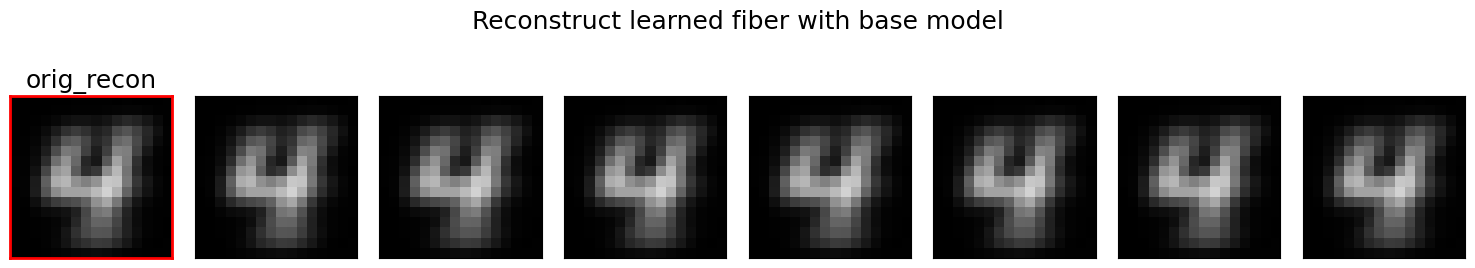

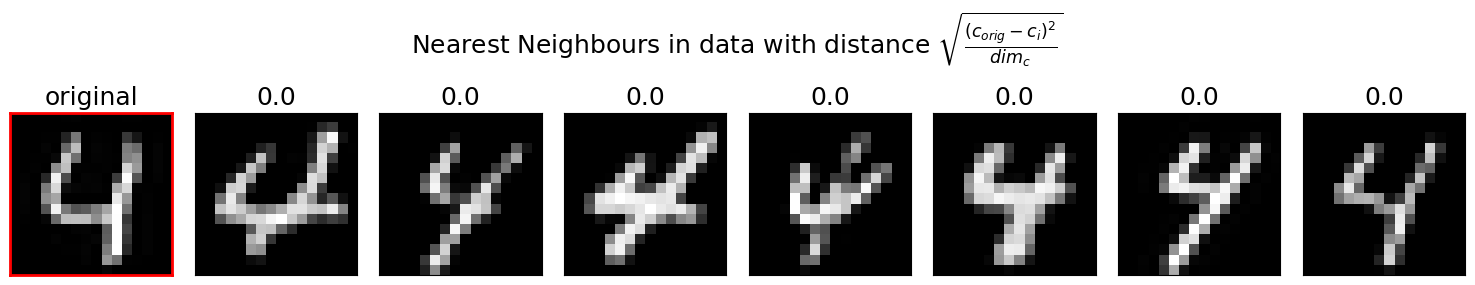

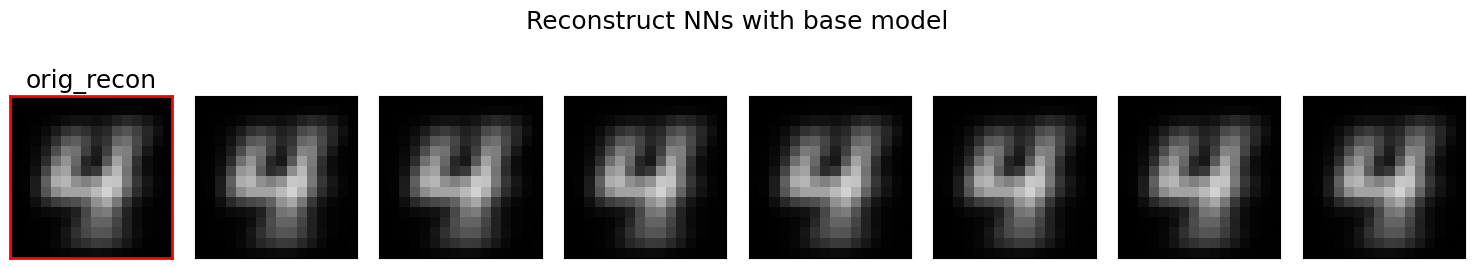

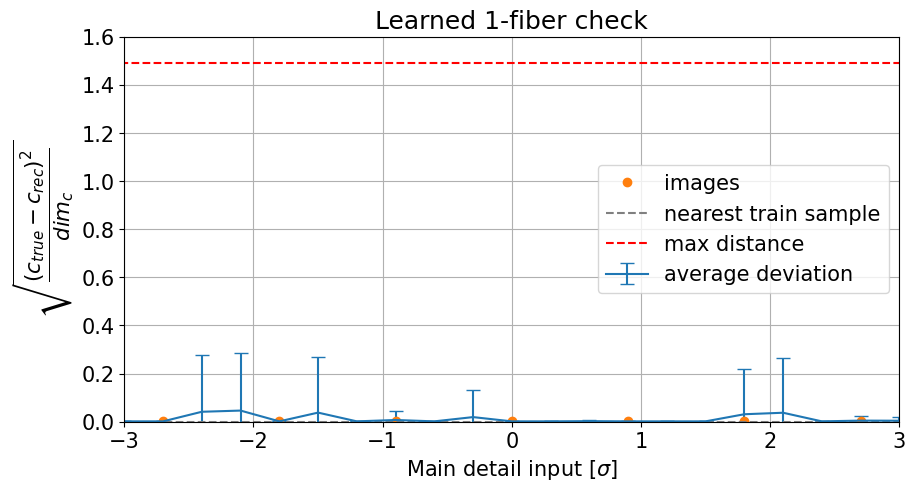

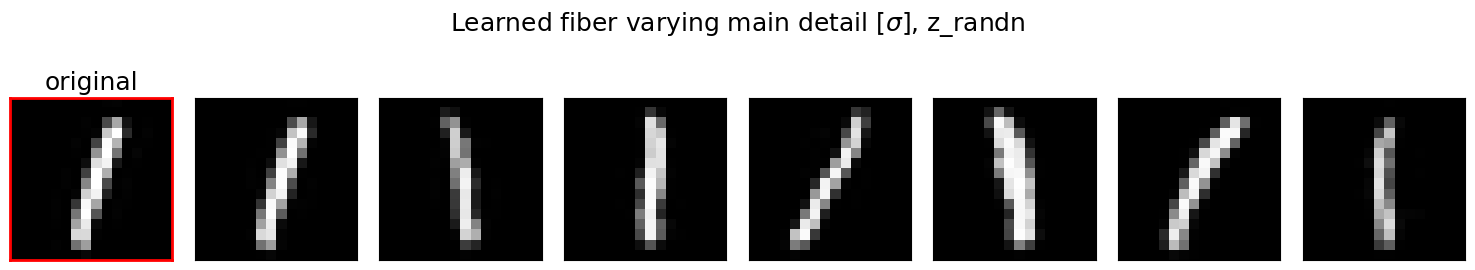

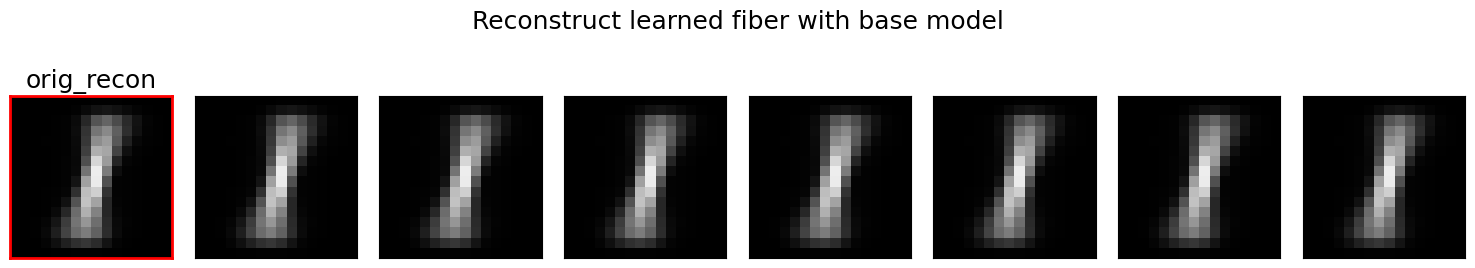

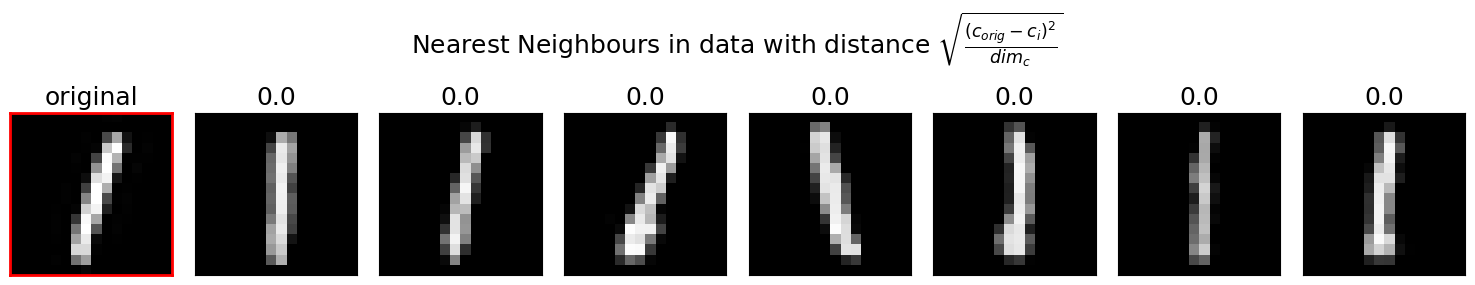

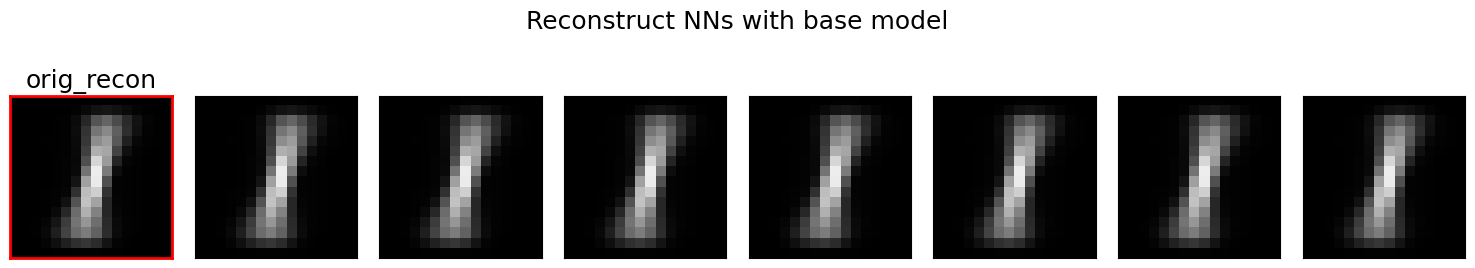

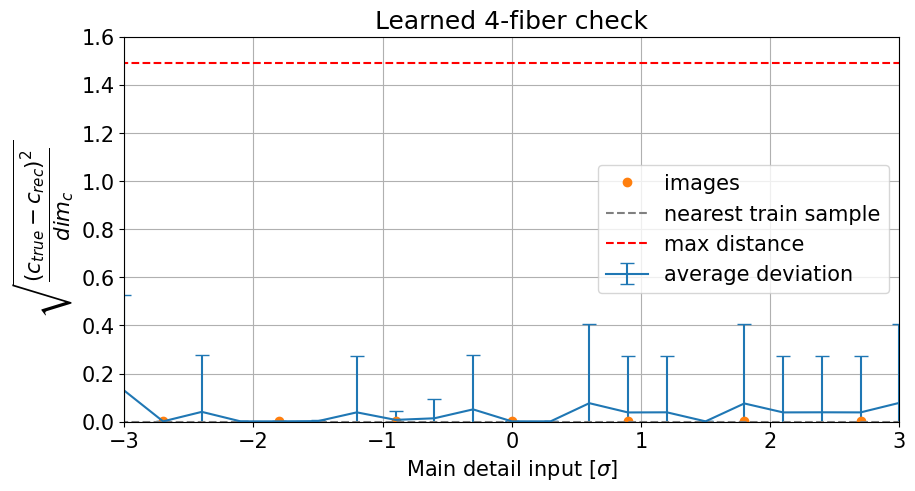

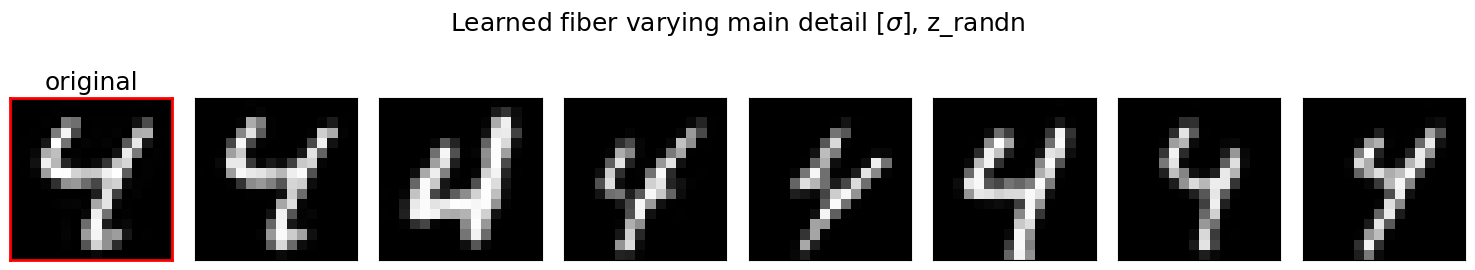

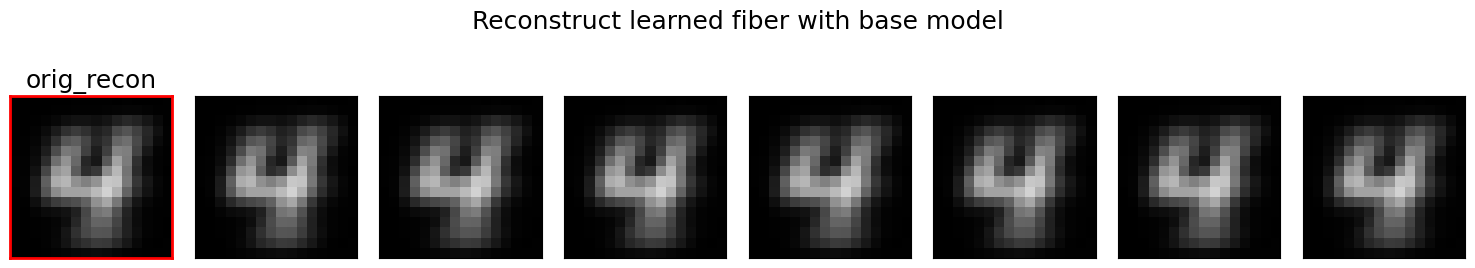

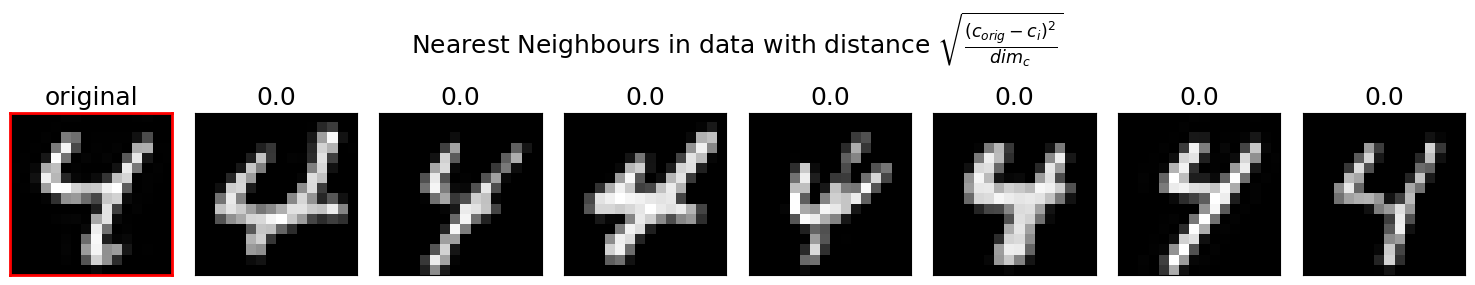

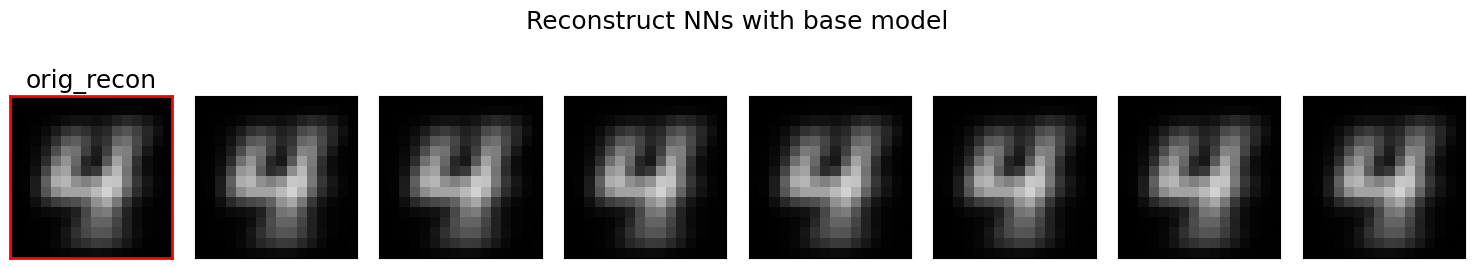

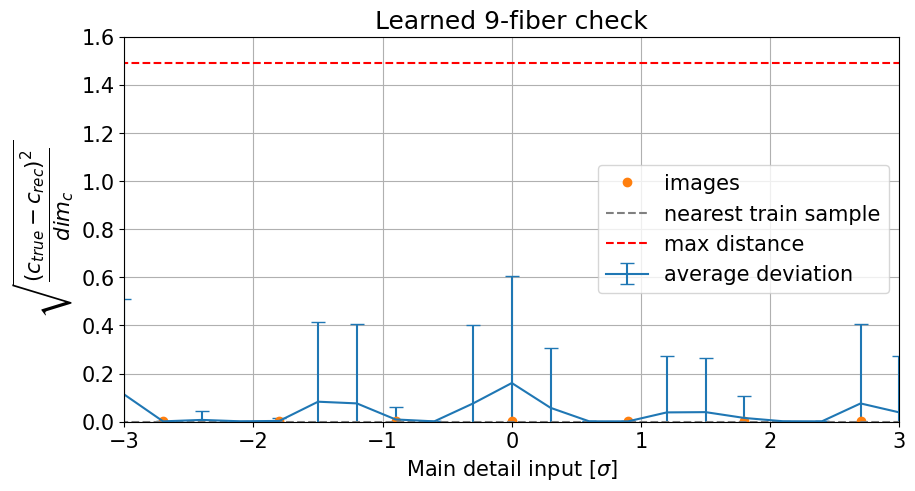

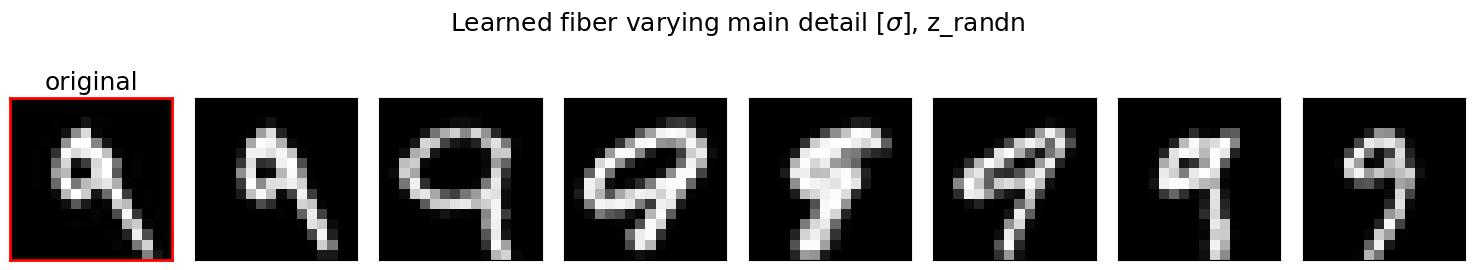

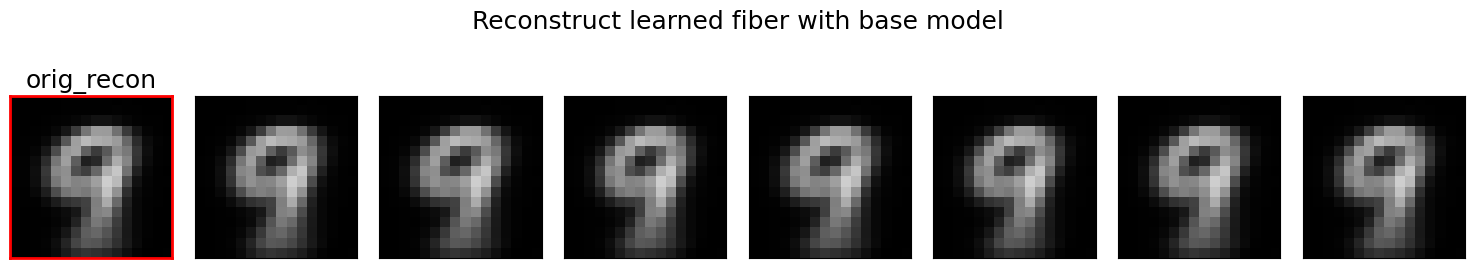

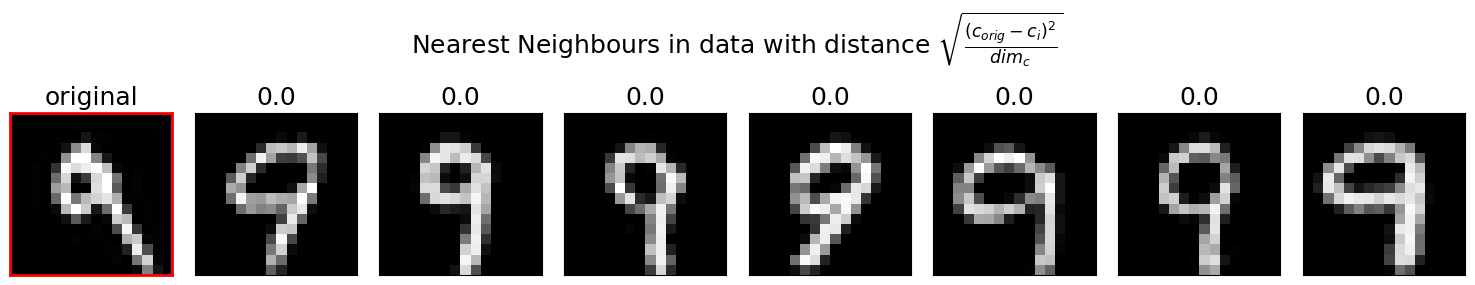

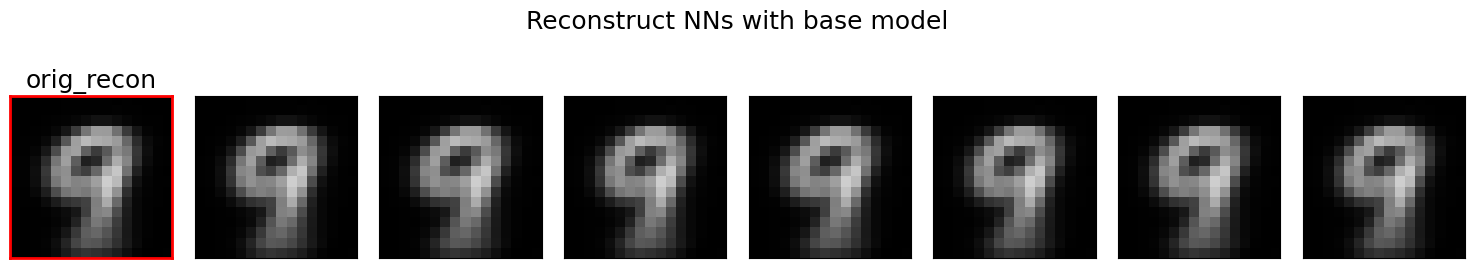

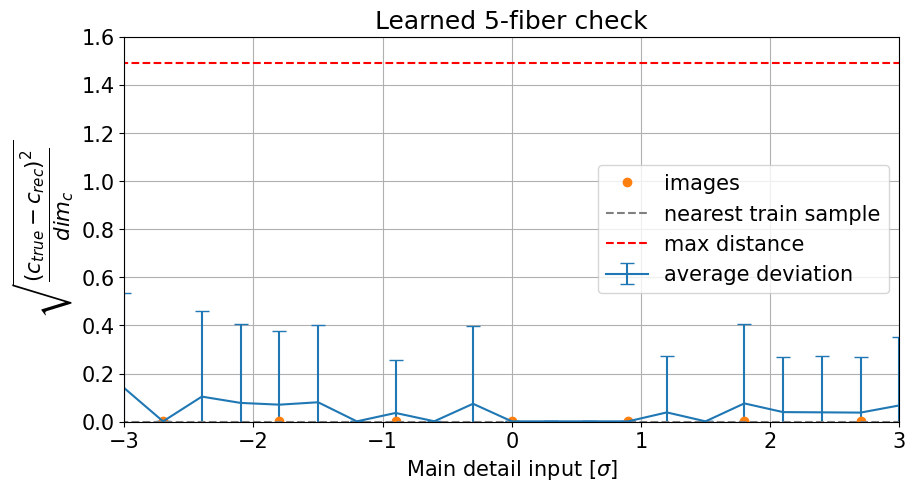

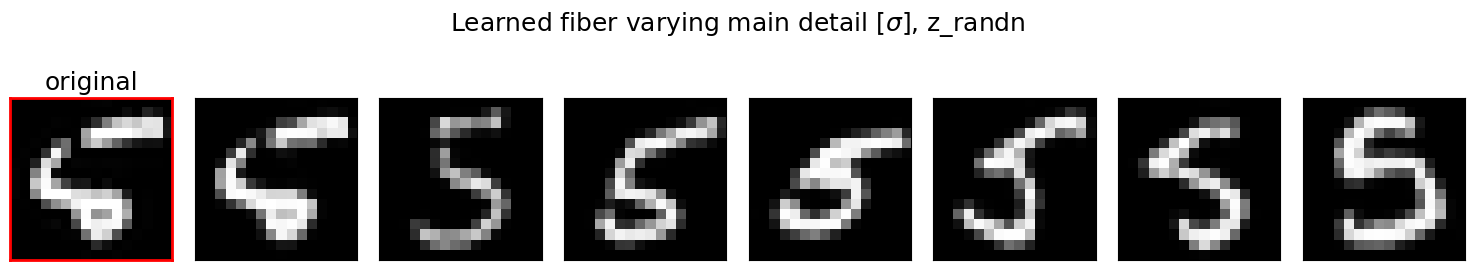

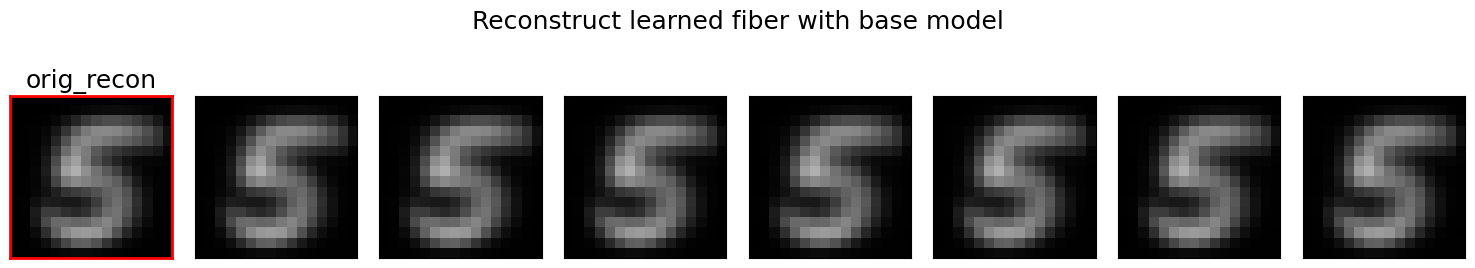

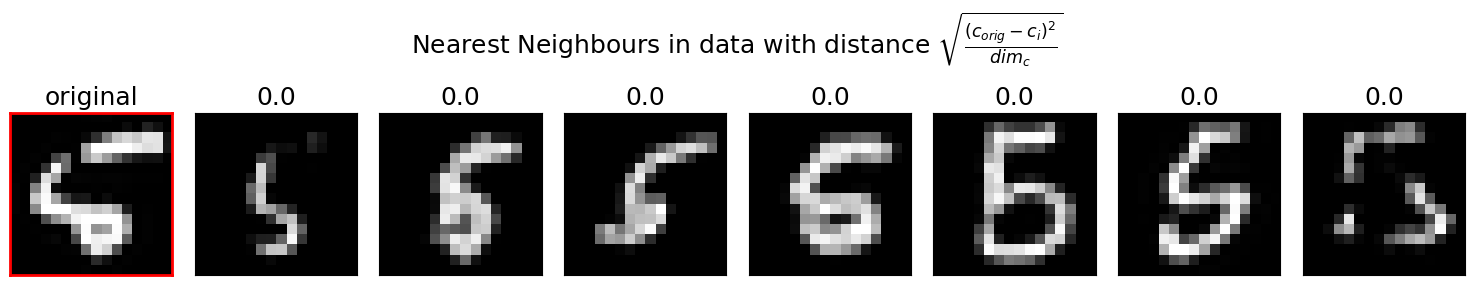

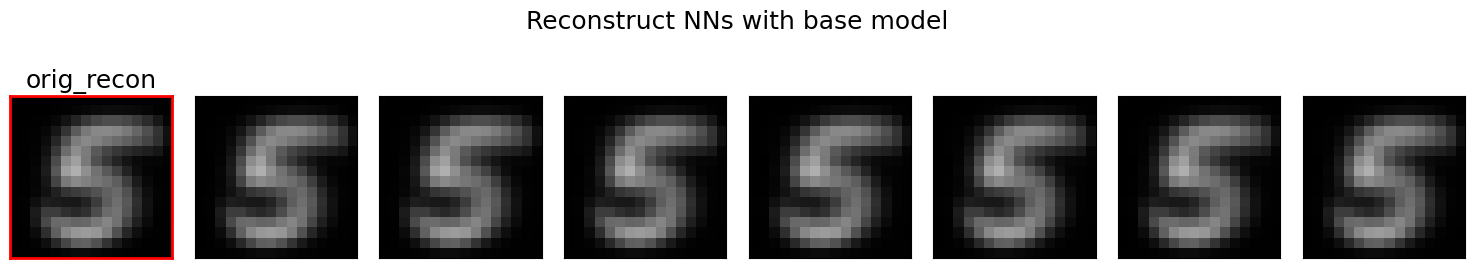

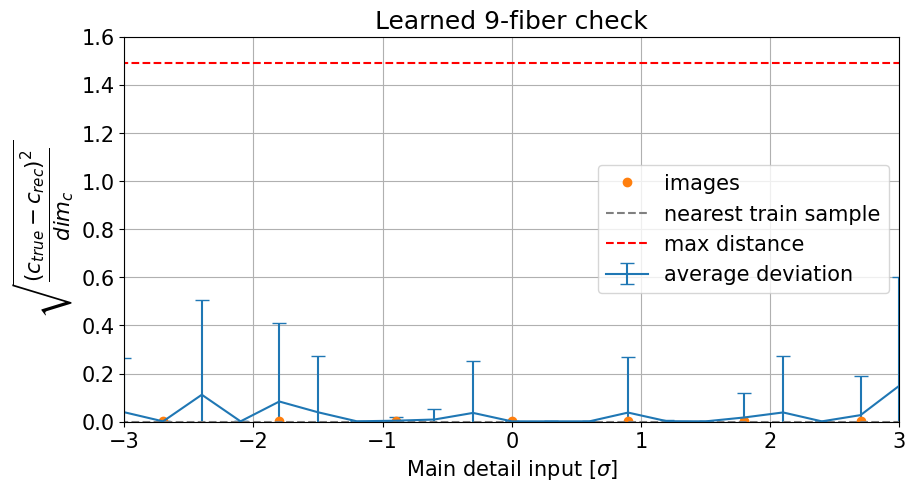

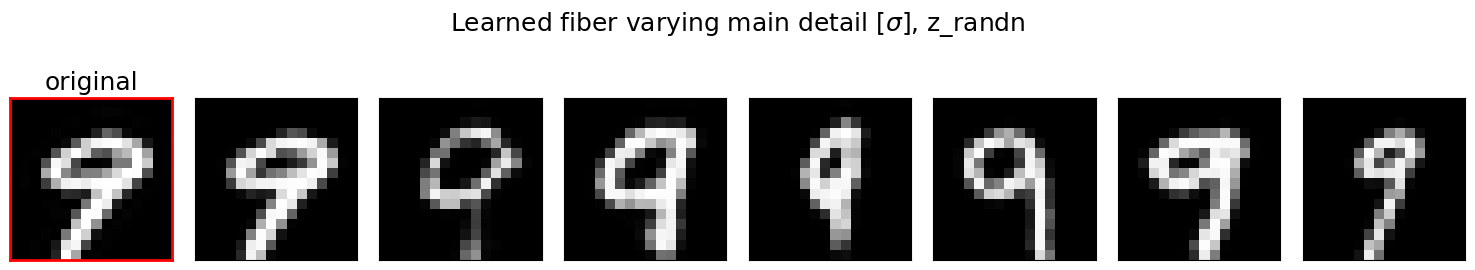

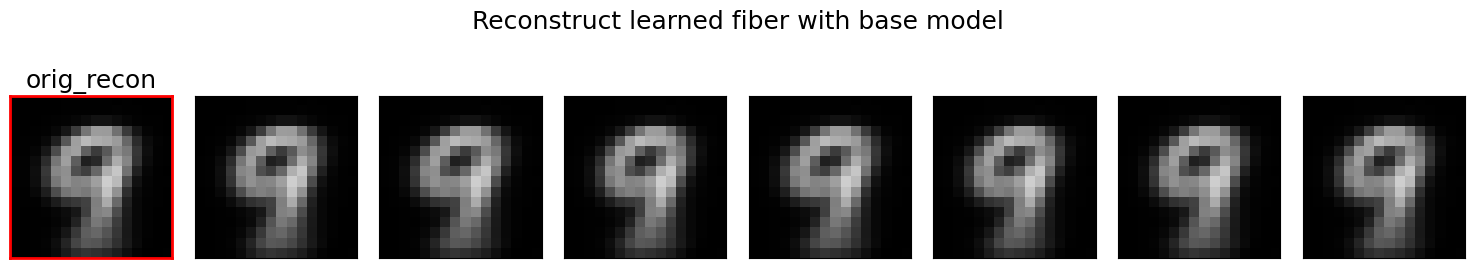

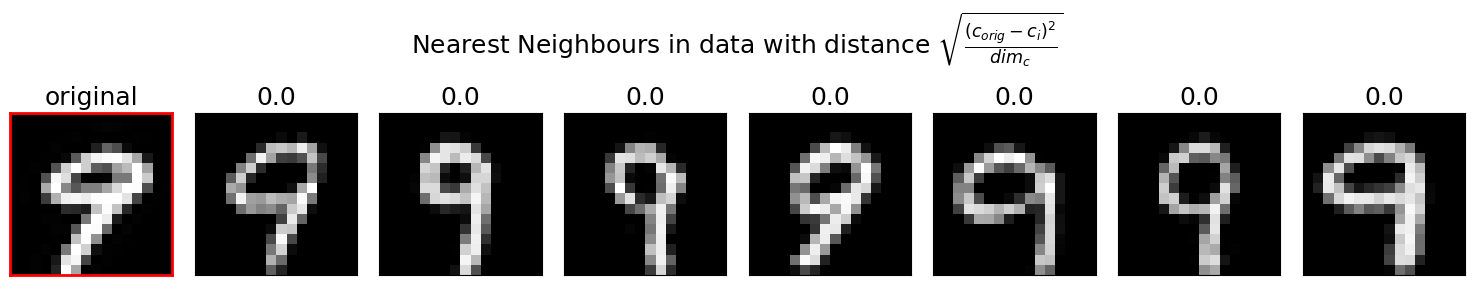

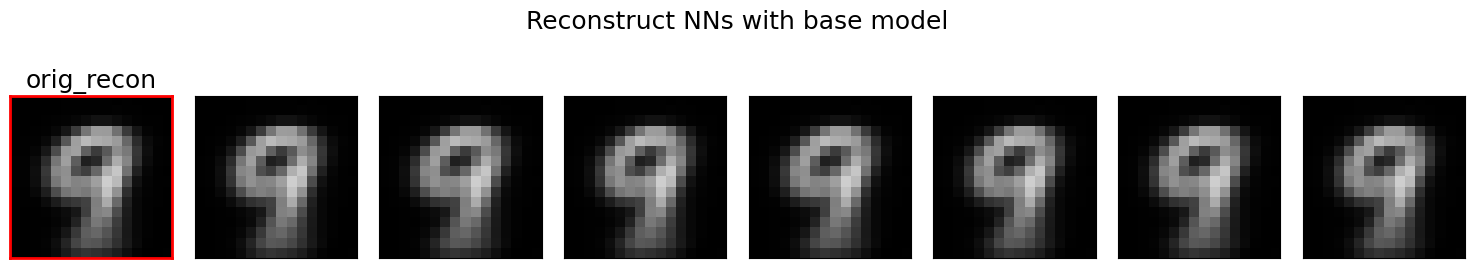

In [46]:
#INN
zrange = 3*std_z0
matplotlib.rcParams.update({'font.size': 15})
nums = [7,2,1,0,4,1,4,9,5,9,0,6,9,0,1,5,9,7,3,4,0,0,0,0,0,0,0,0,0,0,0,0]
ran = np.arange(10)

for j in ran:
    plot_details(model, data, j, zrange, 0)

In [8]:
"""
from fff.evaluate.plots import all_conditions
def plot_mnist(model2plt):
    device = model2plt.device
    
    data = {}
    train_batch = model2plt.train_data[:]
    test_batch = model2plt.test_data[:]

    train_conditioned = model2plt.apply_conditions(train_batch)
    train_samples = train_conditioned.x_noisy
    train_c = train_conditioned.condition
    train_c0 = torch.empty((train_samples.shape[0], 0), device=train_samples.device, dtype=train_samples.dtype)
    
    test_conditioned = model2plt.apply_conditions(test_batch)
    test_c = test_conditioned.condition
    test_samples = test_conditioned.x_noisy
    test_c0 = torch.empty((test_samples.shape[0], 0), device=test_samples.device, dtype=test_samples.dtype)
    
    data["train_samples"] = train_samples
    data["test_samples"] = test_samples
    data["test_c"] = test_c
    data["train_c"] = train_c

    #computing...
    print("encoding...")
    batch_size = model2plt.hparams.batch_size
    test_z = torch.cat([
        model2plt.encode(batch.to(device), c_batch.to(device))[0].cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), test_c0.split(batch_size))
    ])
    print(test_z.shape)
    
    print("reconstructing...")
    reconstruction = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_z.split(batch_size), test_c0.split(batch_size))
    ])
   
    print("sampling...") 
    """
    z_sampled = torch.randn_like(test_z)
    x_sampled = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_sampled.split(batch_size), test_c.split(batch_size))
    ])
    """
    x_sampled = model2plt.sample((test_z[:100].shape[0],),test_c[:100].to(device))

    #plotting...
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(2):
        for j in range(5):
            axes[i][j].imshow(reconstruction[i*5 +j].cpu().reshape(16, 16), cmap='gray')
    fig.suptitle("Reconstruction")
    if save:
        plt.savefig(f"plots/{plot_dir}/reconstruction.png", bbox_inches='tight')
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(2):
        for j in range(5):
            axes[i][j].imshow((test_samples[i*5 +j]).cpu().reshape(16, 16), cmap='gray')
    fig.suptitle("Original")
    if save:
        plt.savefig(f"plots/{plot_dir}/original.png", bbox_inches='tight')
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(2):
        for j in range(5):
            axes[i][j].imshow(x_sampled[i*5 +j].cpu().reshape(16, 16), cmap='gray')
    fig.suptitle("Sampled")
    if save:
        plt.savefig(f"plots/{plot_dir}/sampled.png", bbox_inches='tight')

    #sanity check
    if classifier:
        conditioned = GTa.apply_conditions((test_samples[:10],torch.zeros((10,0),device=device)))
        x_san = conditioned.x0
        c_emp = torch.empty((x_san.shape[0], 0), device=x_san.device, dtype=x_san.dtype)
        c_san = (Features.encode(x_san.to(GTa.device), c_emp.to(GTa.device)).cpu()-center)/std
    else:
        conditioned = GTa.apply_conditions((test_samples[:10],))
        c_emp = conditioned.condition
        x_san = conditioned.x0
        c_san = (GT.encode(x_san.to(GTa.device), c_emp.to(GTa.device)).cpu()-center)/std
    sanity = torch.sqrt(torch.sum((c_san-test_c[:10])**2, dim=1)).numpy()/10
    print(sanity)

    test_z = torch.cat([
        model2plt.transform_model.encode(batch.to(device), c_batch.to(device))[0].cpu()
        for batch, c_batch in zip(test_z.split(batch_size), test_c.split(batch_size))
    ])
    print(test_z.shape)
    data["test_z"] = test_z
    """
    outlier = torch.nonzero(test_z[:,0]<-10, as_tuple=True)
    print(outlier)
    print(test_z[outlier])
    plt.figure(figsize=(4, 4))
    plt.imshow((test_samples[outlier]).cpu().reshape(16, 16), cmap='gray')
    """ 
    nrows = 12
    fig, axes = plt.subplots(nrows=nrows, ncols=5, figsize=(17, nrows*3))
    a = np.linspace(-5,5,100)
    for i in range(nrows):
        for j in range(5):
            axes[i][j].hist(test_z[:,(i*5+j)], bins=60, label="Samples", density=True)
            axes[i][j].plot(a, normal(a))
    fig.suptitle("Latent")
    fig.tight_layout()
    if save:
        plt.savefig(f"plots/{plot_dir}/latent.png", bbox_inches='tight')

    return data

In [167]:
Classifier = fff.FreeFormInjectiveFlow.load_from_checkpoint(
        "lightning_logs/classifier/version_4/checkpoints/last.ckpt"
    )

torch.Size([60000, 1, 8, 8])
cond_dim:  0
latent_dim:  10
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]


In [168]:
z = (torch.from_numpy(df["val_y"]) - center) / std
val_data = Classifier.val_data[:]
conditioned = Classifier.apply_conditions(val_data)
t = conditioned.condition
y = np.argmax(t,axis=1)
reducer = umap.UMAP()
embedding = reducer.fit_transform(z)
print(embedding.shape)

(10000, 2)


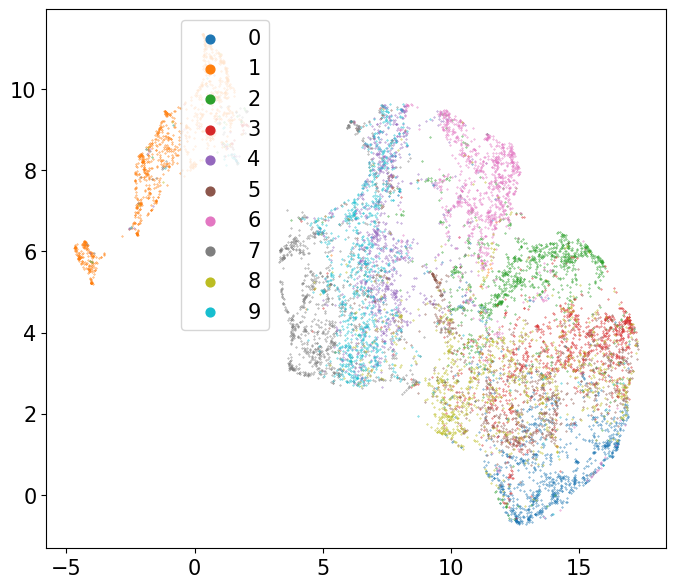

In [169]:
plt.figure(figsize=[8,7])
for i in range(10):
    emb = embedding[y==i]
    plt.scatter(
        emb[:, 0],
        emb[:, 1],
        s=0.1, label=i
    )
plt.legend(markerscale=20.,loc='upper left',bbox_to_anchor=(0.2, 1.))
plt.savefig(f"plots/GTs/AE5/umap_latent.png")

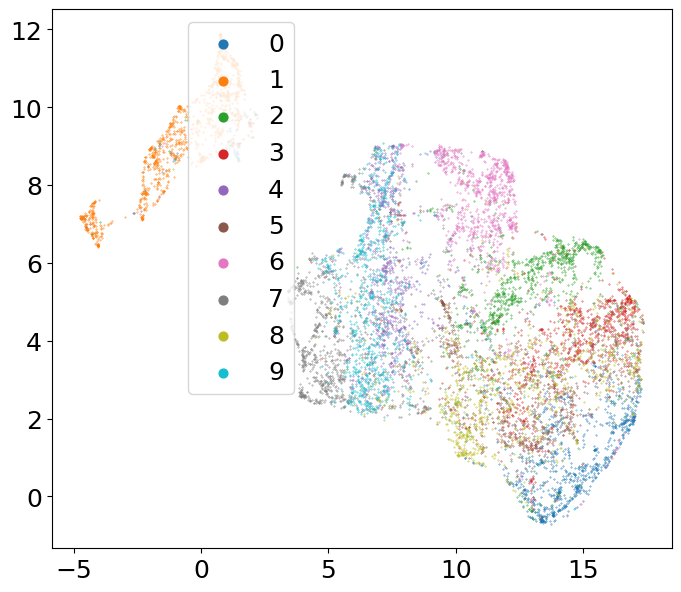

In [19]:
plt.figure(figsize=[8,7])
for i in range(10):
    emb = embedding[y==i]
    plt.scatter(
        emb[:, 0],
        emb[:, 1],
        s=0.1, label=i
    )
plt.legend(markerscale=20.,loc='upper left',bbox_to_anchor=(0.2, 1.))

torch.Size([10000, 10])
torch.Size([10000])


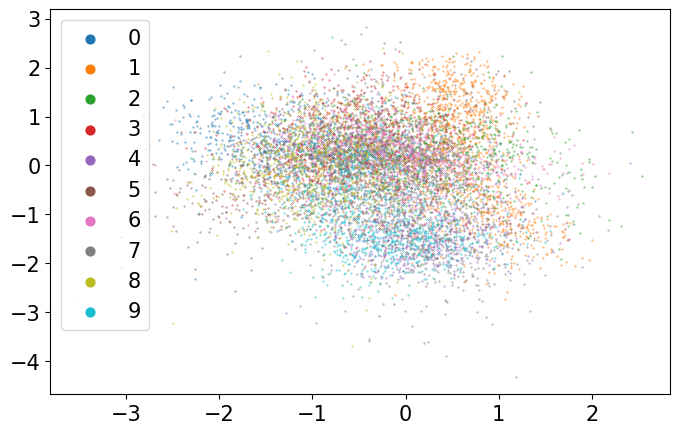

In [30]:
plt.figure(figsize=[8,5])
z = (torch.from_numpy(df["val_y"]) - center) / std
val_data = Classifier.val_data[:]
conditioned = Classifier.apply_conditions(val_data)
t = conditioned.condition
y = np.argmax(t,axis=1)
print(z.shape)
z0 = z[:,6]
z1 = z[:,7]
print(y.shape)
for i in range(10):
    z0i = z0[y==i]
    z1i = z1[y==i]
    plt.scatter(z0i,z1i, s=0.1, label=i)
plt.legend(markerscale=20.)

In [51]:
from fff.model.utils import guess_image_shape
class Truncate(torch.nn.Module):
            def __init__(self):
                super(Truncate, self).__init__()
                enc_conv = list(
                    list(
                    list(
                    list(
                        GT.children()
                    )[1].children()
                    )[0].children()
                    )[0].children()
                    )[0]
                enc_res = list(
                    list(
                    list(
                    list(
                    list(
                        GT.children()
                    )[1].children()
                    )[1].children()
                    )[0].children()
                    )[0].children()
                    )[:-2]
                self.features = torch.nn.Sequential(
                    enc_conv, *enc_res
                )

            def cat_x_c(self, x, c):
                # Reshape as image, and concatenate conditioning as channel dimensions
                has_batch_dimension = len(x.shape) > 1
                if not has_batch_dimension:
                    x = x[None, :]
                    c = c[None, :]
                batch_size = x.shape[0]
                input_shape = guess_image_shape(GT.data_dim)
                x_img = x.reshape(batch_size, *input_shape)
                c_img = c[:, :, None, None] * torch.ones(batch_size, GT.cond_dim, *input_shape[1:], device=c.device)
                out = torch.cat([x_img, c_img], -3).reshape(batch_size, -1)
                if not has_batch_dimension:
                    out = out[0]
                return out
            
            def encode(self, x, c):
                x = self.features(self.cat_x_c(x,c))
                return x

Features = Truncate()

In [22]:
data = save_data(GT)

encoding traindata...
encoding valdata...
encoding testdata...


In [24]:
from math import log10

def rand_log_uniform(vmin, vmax, shape, device, dtype):
    vmin, vmax = map(log10, [vmin, vmax])
    return torch.rand(
        shape, device=device, dtype=dtype
    ) * (vmin - vmax) + vmax

def save_data(rectangular_flow):
    max_noise = 0.2
    min_noise = 0.01
    train_data = rectangular_flow.train_data[:]
    val_data = rectangular_flow.val_data[:]
    test_data = rectangular_flow.test_data[:]
    
    conditioned = rectangular_flow.apply_conditions(train_data)
    train_x0 = conditioned.x0
    noise_scale = rand_log_uniform(max_noise, min_noise, shape=(train_x0.shape[0],1), device=train_x0.device, dtype=train_x0.dtype)
    train_samples = train_x0 + torch.randn_like(train_x0) * (10 ** noise_scale)
    c_t = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_data)
    val_x0 = conditioned.x0
    noise_scale = rand_log_uniform(max_noise, min_noise, shape=(val_x0.shape[0],1), device=val_x0.device, dtype=val_x0.dtype)
    val_samples = val_x0 + torch.randn_like(val_x0) * (10 ** noise_scale)
    c_v = conditioned.condition

    conditioned = rectangular_flow.apply_conditions(test_data)
    test_x0 = conditioned.x0
    noise_scale = rand_log_uniform(max_noise, min_noise, shape=(test_x0.shape[0],1), device=test_x0.device, dtype=test_x0.dtype)
    test_samples = test_x0 + torch.randn_like(test_x0) * (10 ** noise_scale)
    c_test = conditioned.condition
    
    device = rectangular_flow.device
    print("encoding traindata...")
    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t.split(batch_size))
    ])
    print("encoding valdata...")
    z_val = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_v.split(batch_size))
    ])
    print("encoding testdata...")
    z_test = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), c_test.split(batch_size))
    ])

    data = {}
    
    data["train_x"] = train_samples.cpu().numpy()
    data["train_y"] = z_train.cpu().numpy()
    
    data["val_x"] = val_samples.cpu().numpy()
    data["val_y"] = z_val.cpu().numpy()

    data["test_x"] = test_samples.cpu().numpy()
    data["test_y"] = z_test.cpu().numpy()

    path = "data/"
    fileName = path + '16Mnist_AE'
    fileObject = open(fileName, 'wb')
    
    pkl.dump(data, fileObject)
    fileObject.close()
    
    return data

In [21]:
def save_data(rectangular_flow):
    train_data = rectangular_flow.train_data[:]
    val_data = rectangular_flow.val_data[:]
    test_data = rectangular_flow.test_data[:]
    
    conditioned = rectangular_flow.apply_conditions(train_data)
    train_samples = conditioned.x_noisy
    c_t = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_data)
    val_samples = conditioned.x_noisy
    c_v = conditioned.condition

    conditioned = rectangular_flow.apply_conditions(test_data)
    test_samples = conditioned.x_noisy
    c_test = conditioned.condition
    
    device = rectangular_flow.device
    print("encoding traindata...")
    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t.split(batch_size))
    ])
    print("encoding valdata...")
    z_val = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_v.split(batch_size))
    ])
    print("encoding testdata...")
    z_test = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), c_test.split(batch_size))
    ])

    data = {}
    
    data["train_x"] = train_samples.cpu().numpy()
    data["train_y"] = z_train.cpu().numpy()
    
    data["val_x"] = val_samples.cpu().numpy()
    data["val_y"] = z_val.cpu().numpy()

    data["test_x"] = test_samples.cpu().numpy()
    data["test_y"] = z_test.cpu().numpy()

    path = "data/"
    fileName = path + '16Mnist_AE'
    fileObject = open(fileName, 'wb')
    
    pkl.dump(data, fileObject)
    fileObject.close()

/tmp/ipykernel_2391122/3809913029.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=1, ncols=n+1, figsize=(18, 3))


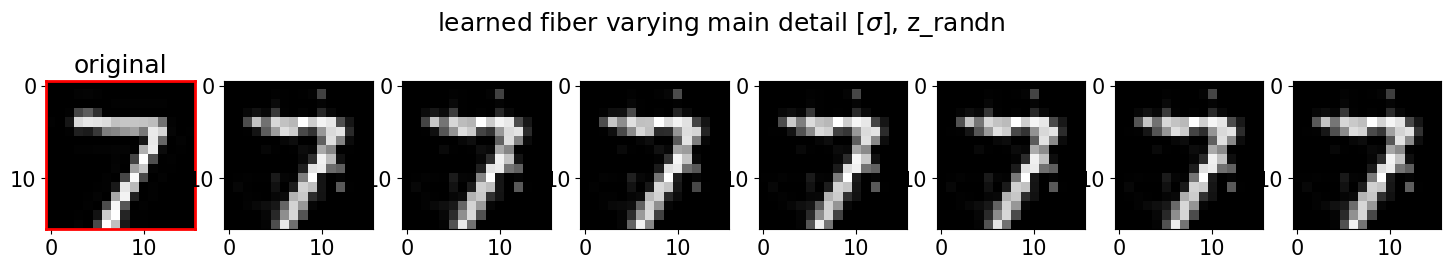

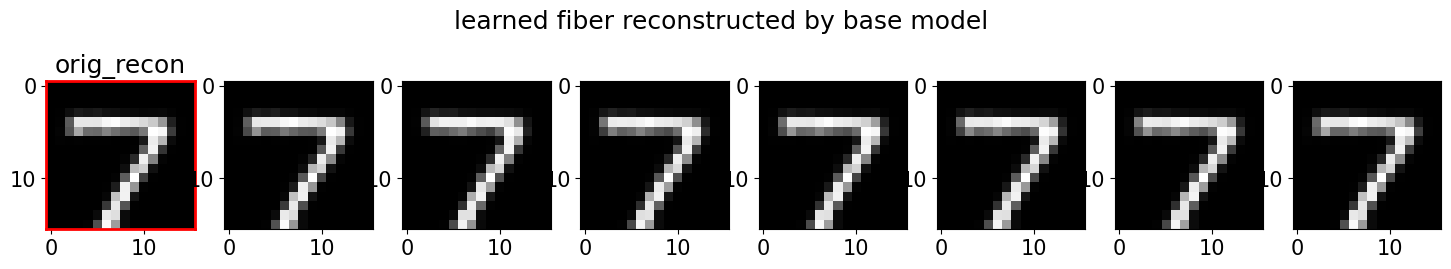

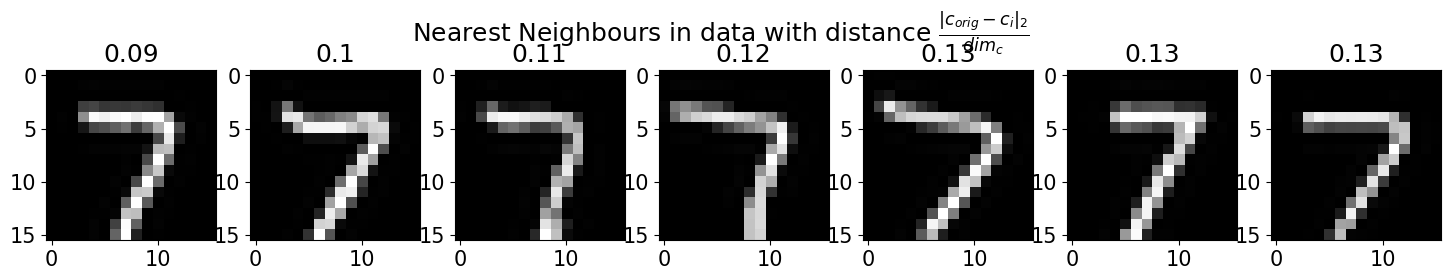

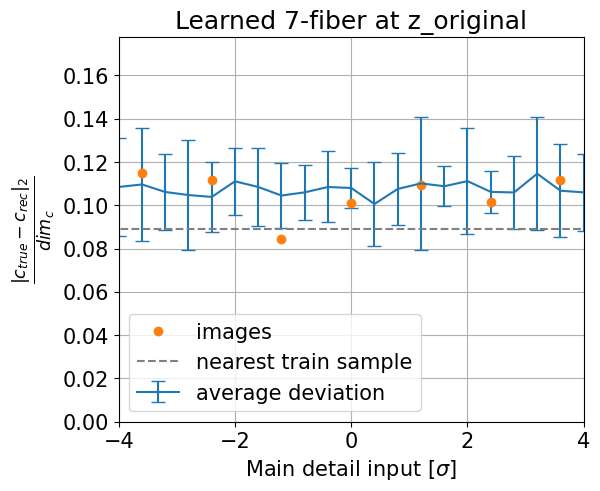

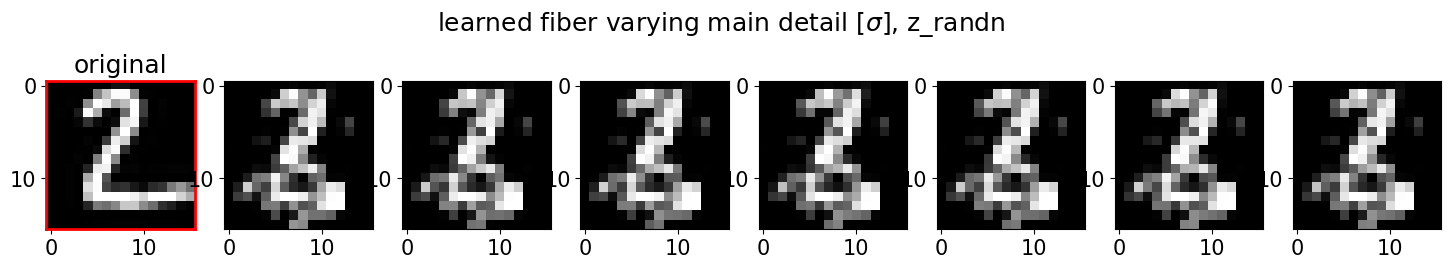

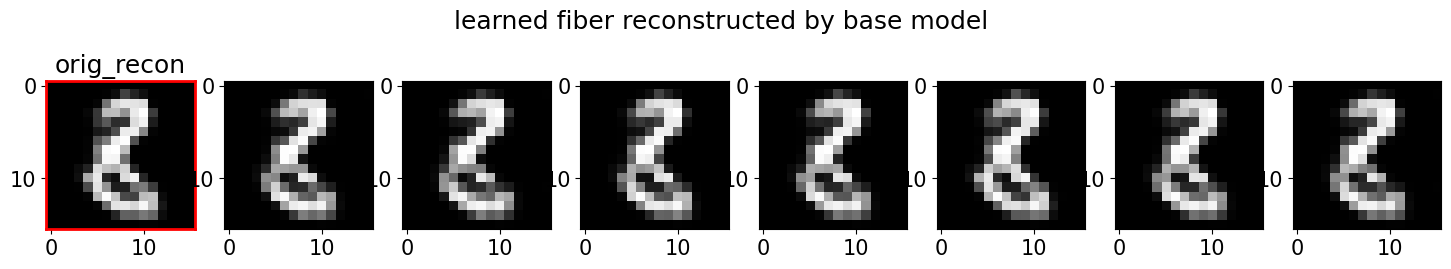

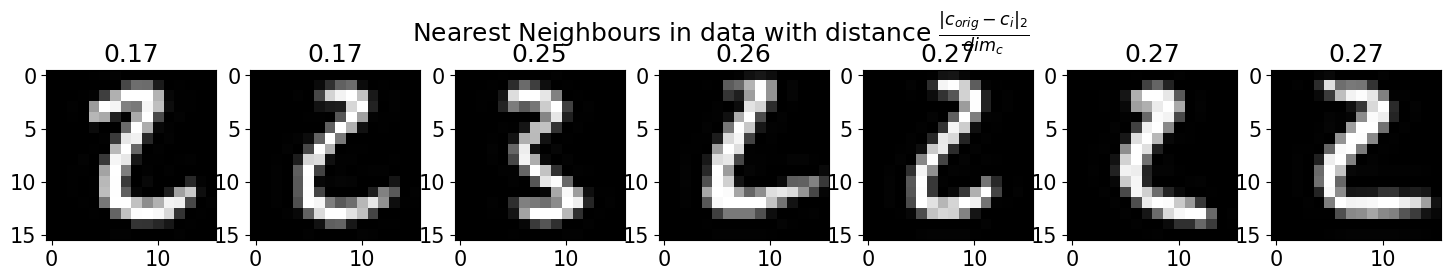

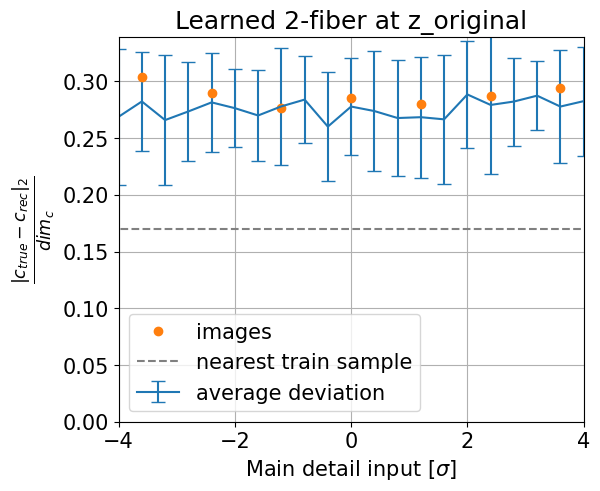

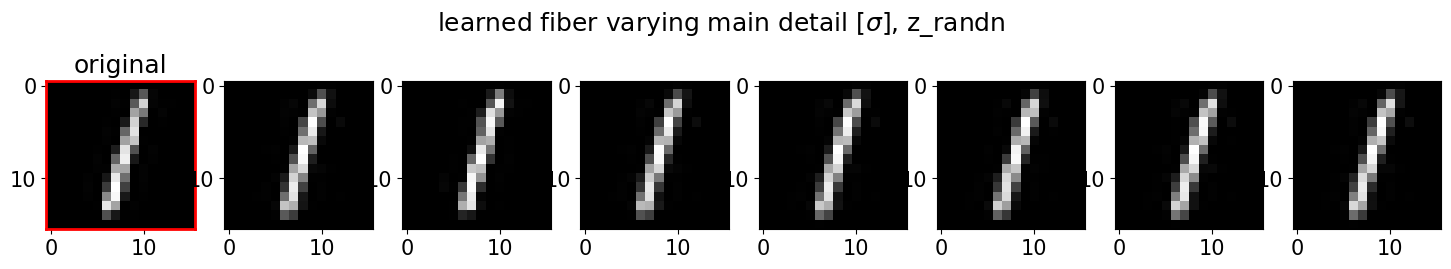

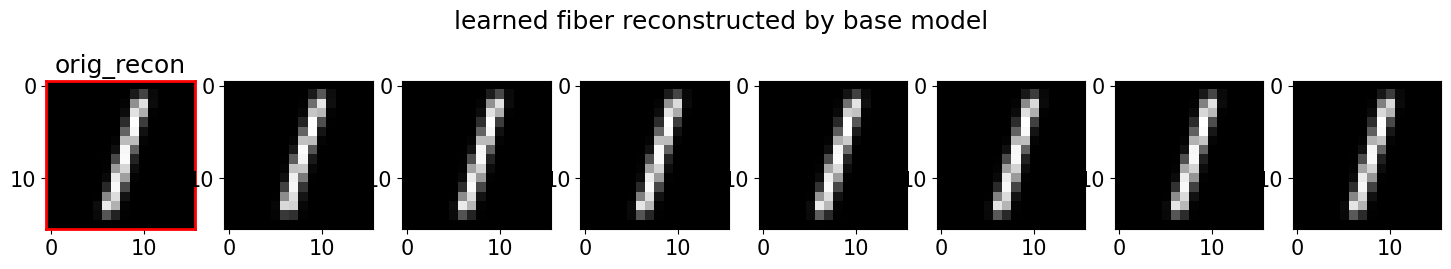

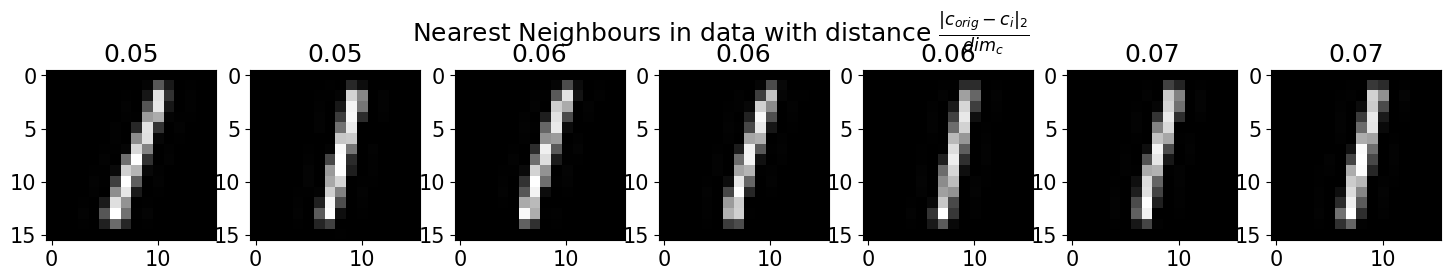

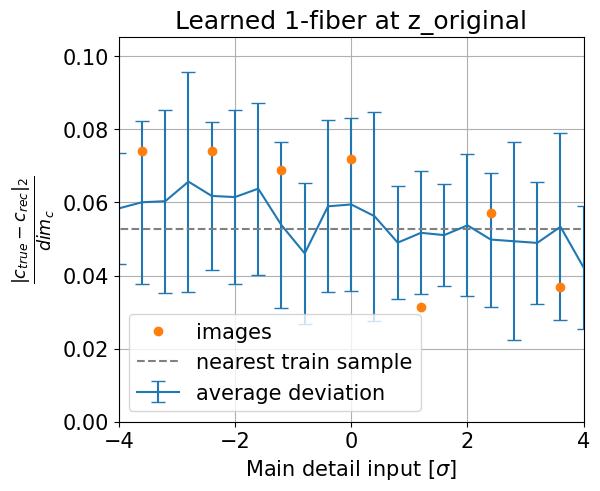

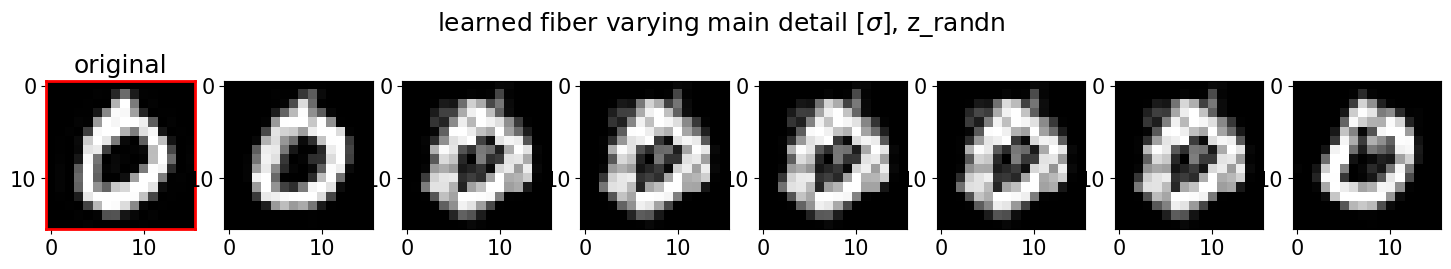

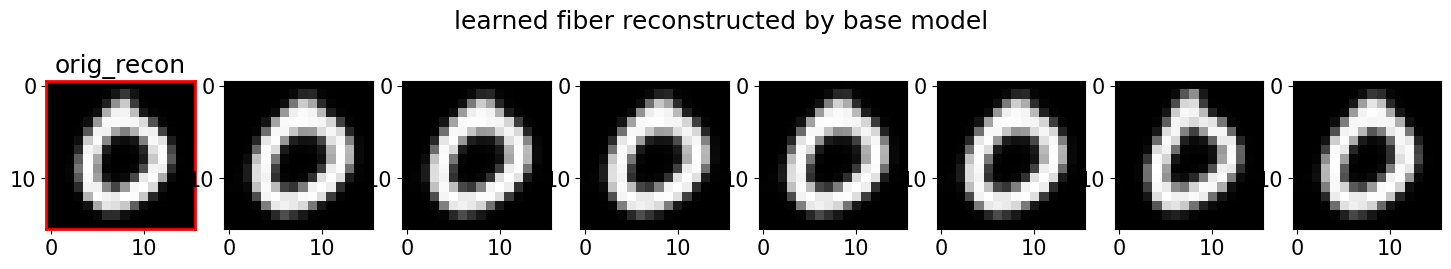

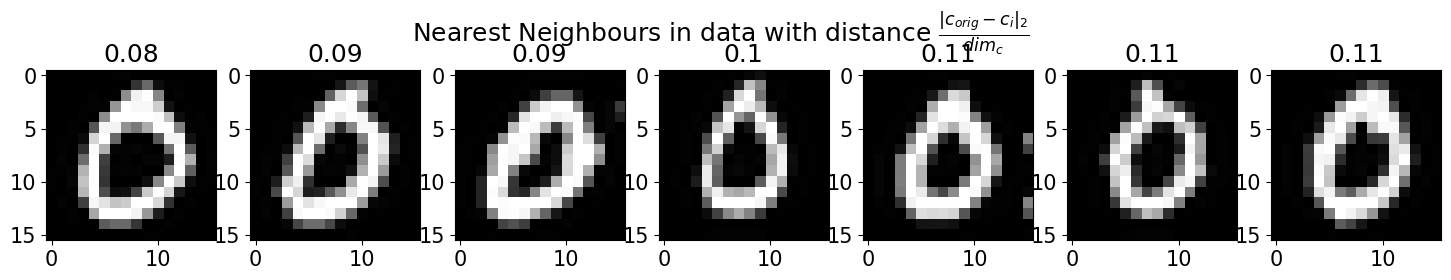

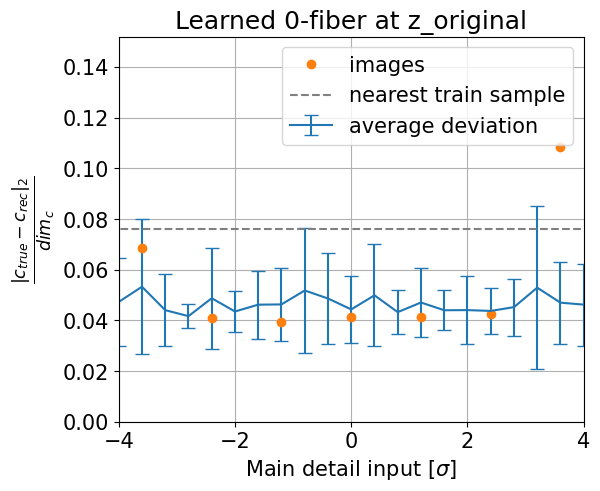

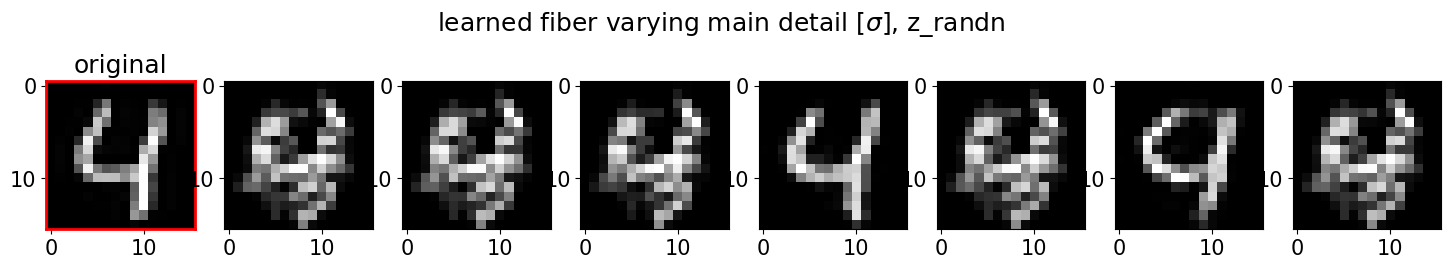

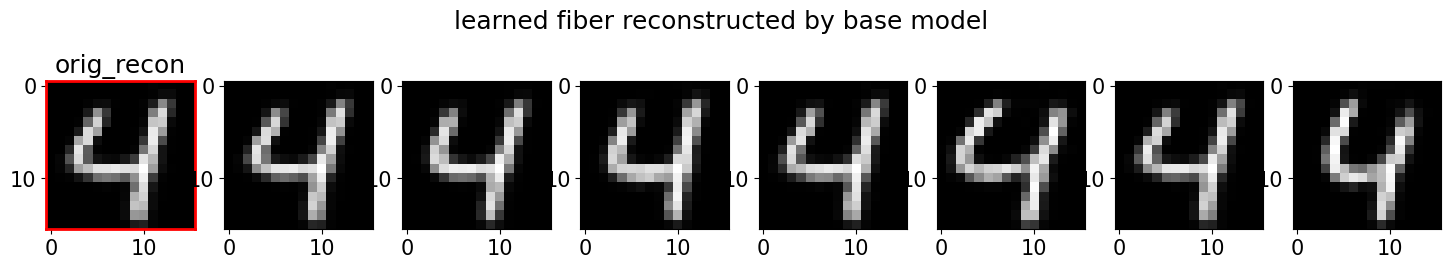

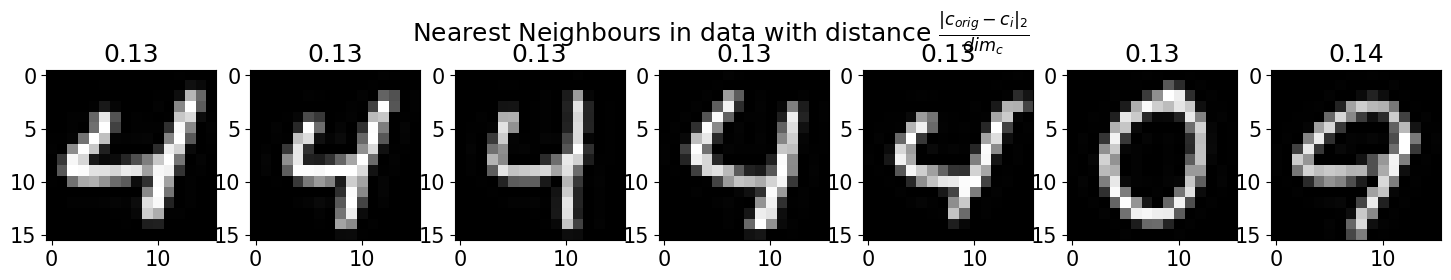

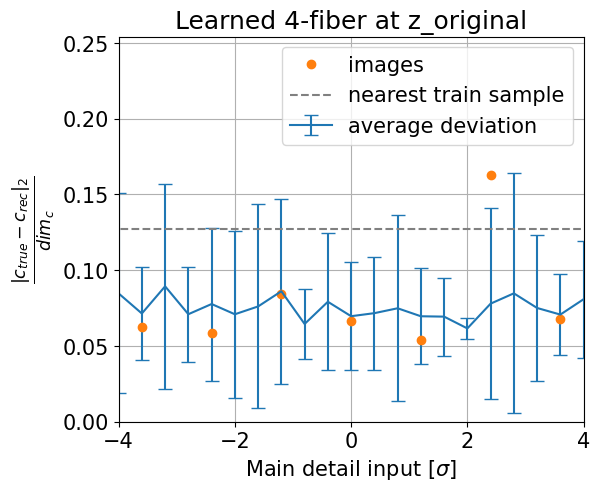

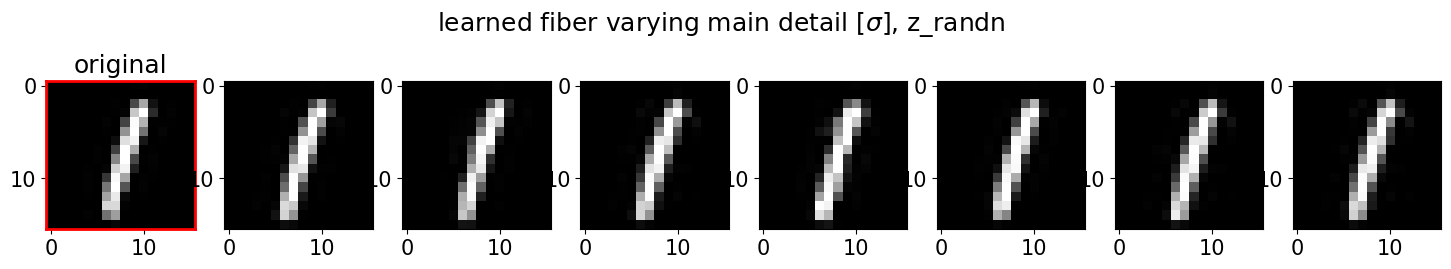

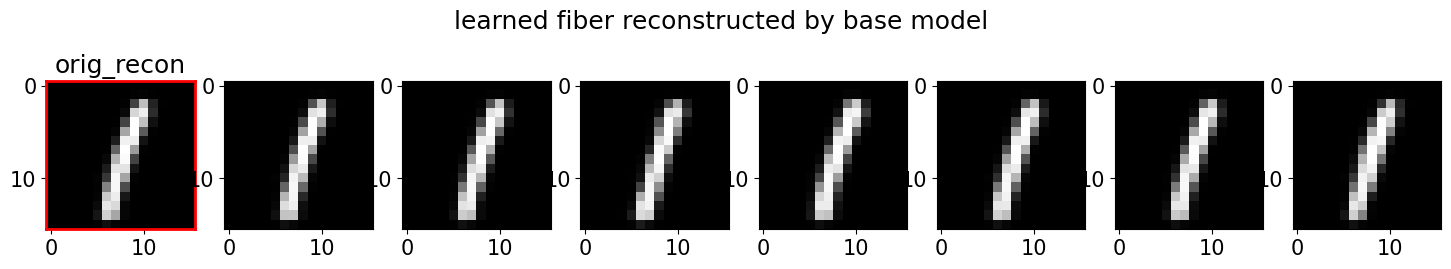

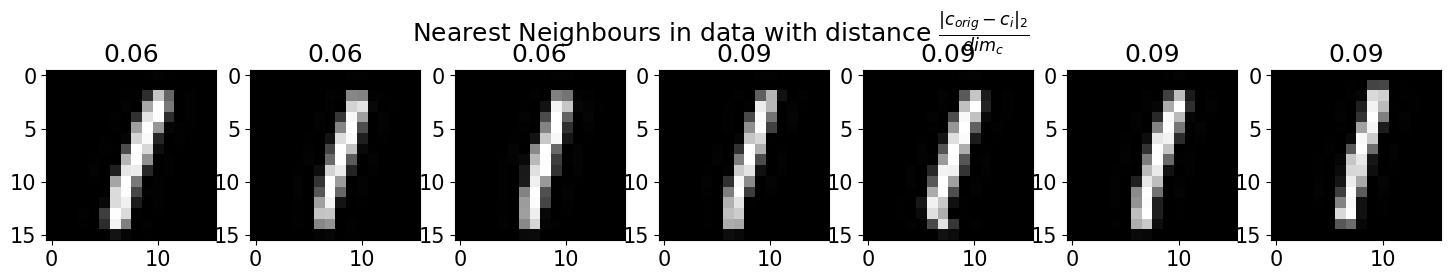

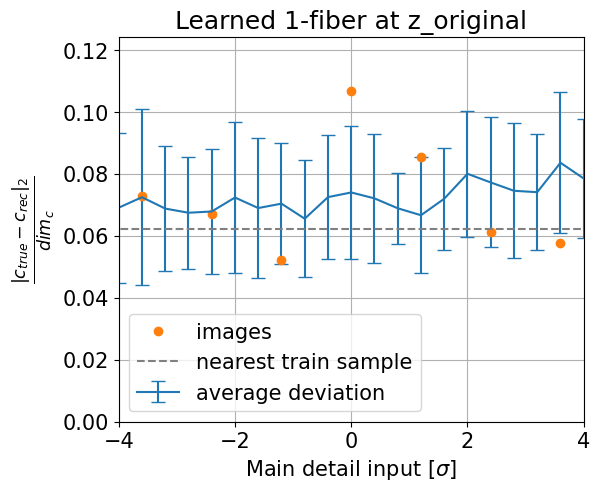

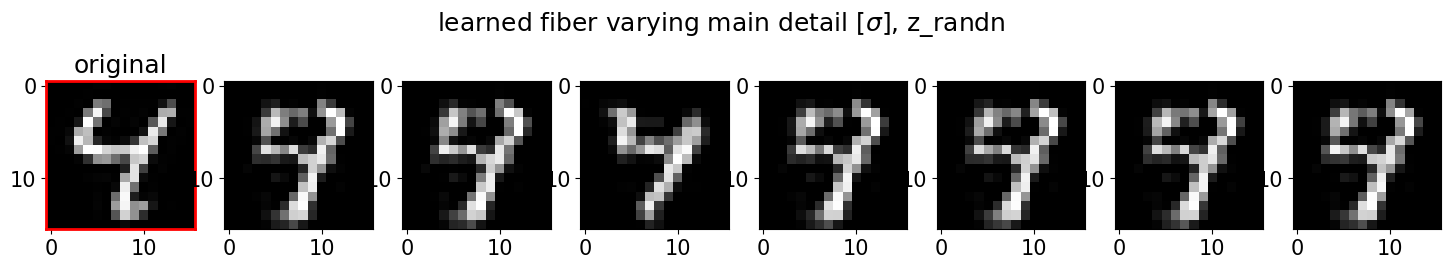

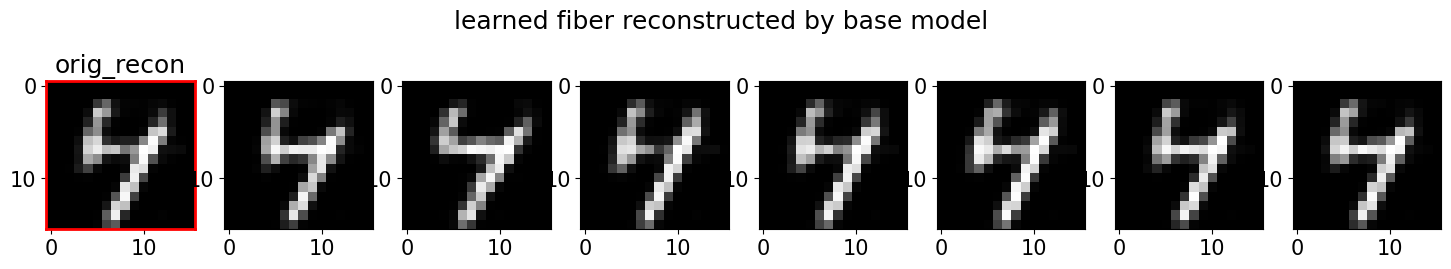

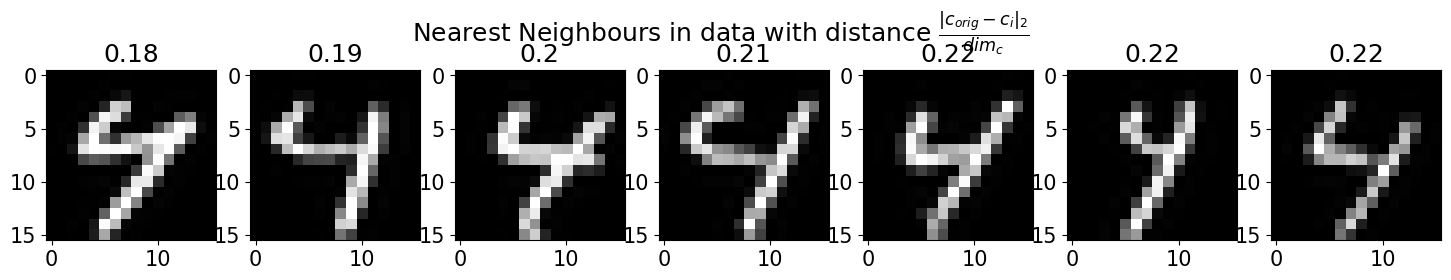

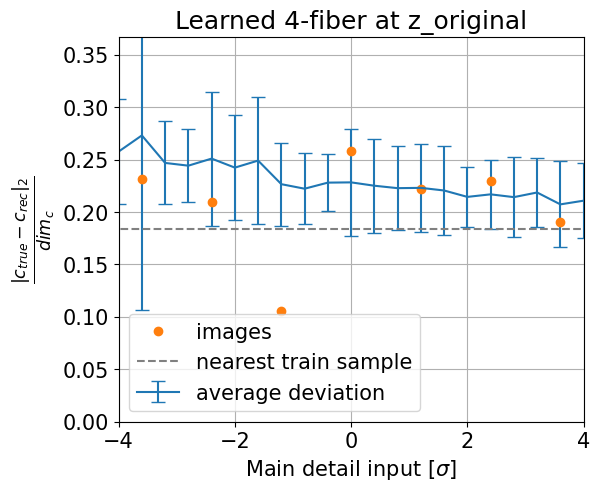

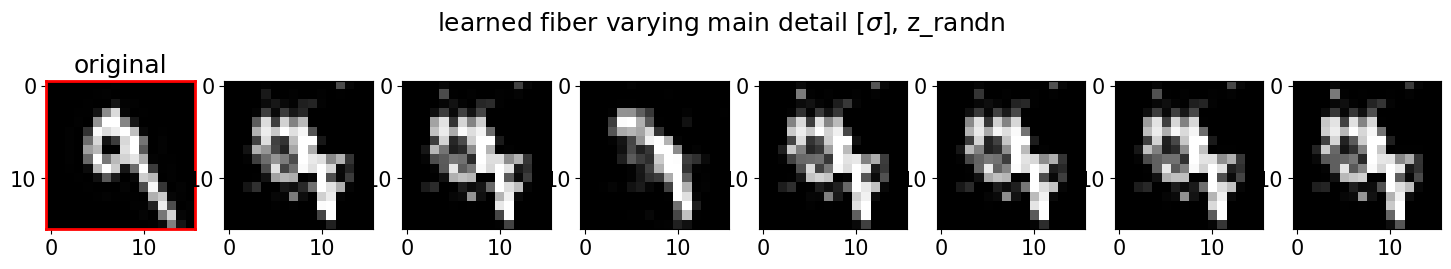

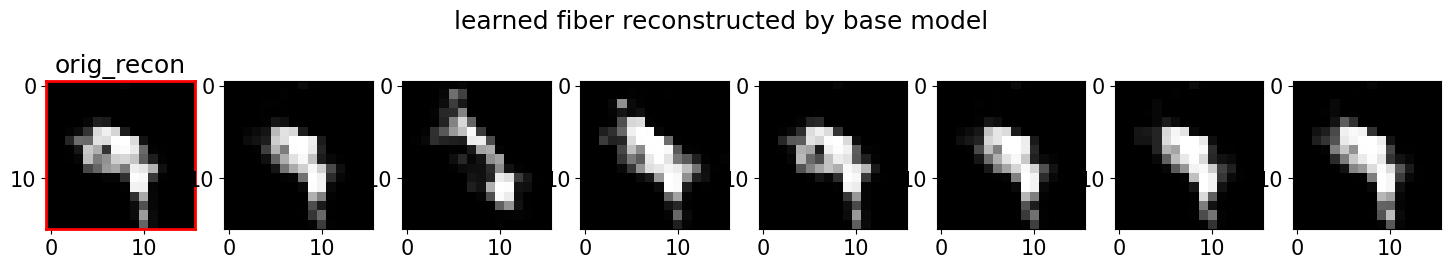

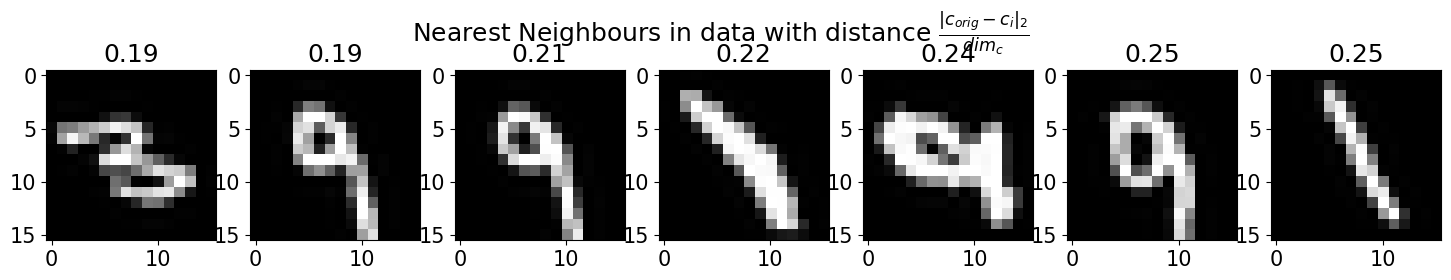

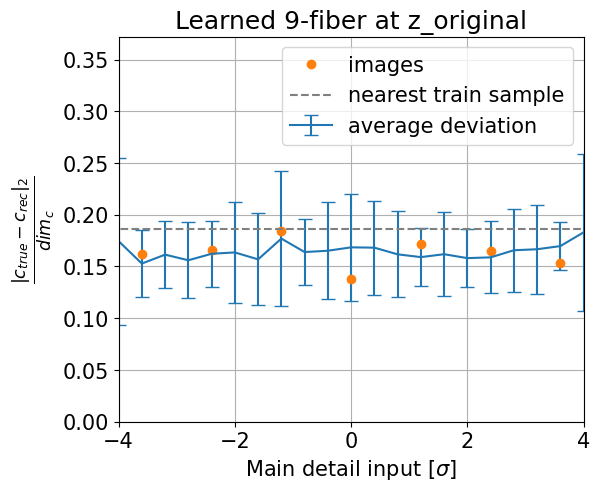

In [183]:
zrange = 4*std_z0
matplotlib.rcParams.update({'font.size': 15})
nums = [7,2,1,0,4,1,4,9,5,9,0,6,9,0,1,5,9,7,3,4,0,0,0,0,0,0,0,0,0,0,0,0]
z_name = ["z_original", "z_0", "z_randn"]

accident = []
for j in range(8):
    xs, c_sample, z0_range, NN, z0_sample, keep, check_fiber = plot_details(model, data, j, zrange)
    accident.append(keep)
    for i, xi in enumerate(xs):
        """
        if classifier == False:
            conditioned = GTa.apply_conditions((xi,))
            c = conditioned.condition
            x = conditioned.x0
            check_fiber = GT.encode(x.to(GTa.device), c.to(GTa.device))
            fiber_rec = GTa.decode(check_fiber, c.to(GTa.device))
            check_fiber = (check_fiber.cpu() - center) / std
            fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(17, 3))
            for k in range(7):
                axes[k].imshow(fiber_rec[k*21//7+1].cpu().reshape(16, 16), cmap='gray')
            plt.suptitle(r"learned fiber reconstructed by base model")
        else:
            conditioned = GTa.apply_conditions((xi,c_sample))
            x = conditioned.x0
            c = torch.empty((x.shape[0], 0), device=x.device, dtype=x.dtype)
            check_fiber = (Features.encode(x.to(GTa.device), c.to(GTa.device)).cpu() - center) / std
        
        #print(torch.max(check_fiber-c_sample, dim=1)[0])
        plt.figure(figsize=[6,5])
        
        if i == 0:
            delta_coarse = torch.sqrt(torch.sum((check_fiber-c_sample)**2, dim=1)).numpy()/latent_dim
            delta_details = z0_range/std_z0
            plt.axvline(x=z0_sample/std_z0, ymin=0, ymax=2,color='red', label='sample')
            plt.plot(delta_details,delta_coarse, label="average deviation")
        elif i==1:
            delta_coarse = torch.sqrt(torch.sum((check_fiber-c_sample)**2, dim=1)).numpy()/latent_dim
            delta_details = np.linspace(-zrange,zrange,z0_range.shape[0])/std_z0
            plt.plot(delta_details,delta_coarse, label="average deviation")
        else:
        """
        plt.figure(figsize=[6,5])
        delta_coarse = torch.sqrt(torch.sum((check_fiber-c_sample.repeat(40,1))**2, dim=1))/latent_dim
        delta_c_std, delta_c = torch.std_mean(delta_coarse.reshape(40,-1), dim=0)
        delta_c = delta_c.numpy()
        delta_details = np.linspace(-zrange,zrange,z0_range.shape[0])/std_z0
        plt.errorbar(delta_details,delta_c,yerr=delta_c_std, label="average deviation",capsize=5)
        plt.plot(delta_details[1::21//7],delta_coarse[1:21:21//7], marker='o', label="images", linestyle='')
            
        #plotting...
        plt.axhline(y=NN, xmin=-10, xmax=10, color='gray', linestyle="--", label='nearest train sample')
        plt.title(f"Learned {nums[j]}-fiber at {z_name[i]}")
        plt.ylabel(r"$\frac{|c_{true}-c_{rec}|_2}{dim_c}$", fontsize=18)
        plt.legend()
        plt.xlabel(r"Main detail input [$\sigma$]")
        plt.ylim((0,2*NN))
        plt.xlim((-zrange/std_z0,zrange/std_z0))
        plt.grid()
        if save:
            plt.savefig(f"plots/{plot_dir}/fiber0/{nums[j]}deviation_{z_name[i]}.png", bbox_inches='tight')
"""
accident = torch.stack(accident)
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(14, 9))
dist = torch.sqrt(torch.sum((accident[1:]-accident[:-1])**2,-1))
for i in range(3):
    for j in range(6):
        axes[i][j].imshow(accident[i*6+j].cpu().reshape(16,16), cmap='gray')
        axes[i][j].set_title(str(nums[i*6+j]) + " " + str(np.round(dist[i*6+j].numpy(),2)))
plt.suptitle(r"accidental finding")
""";

In [182]:
def plot_details(model2plot, data, sample, zrange):
    nums = [7,2,1,0,4]
    device = model2plot.device
    
    pos_min, pos_max = -zrange, zrange
    c = data["test_c"]
    z = data["test_z"]
    train_c = data["train_c"]
    train_samples = data["train_samples"]
    test_samples = data["test_samples"]
    N = 21
    n = 7
    ddim = 100

    #calculate two walks along main detail dimension
    z0_range = torch.linspace(pos_min, pos_max, N)
    z0_range1 = z0_range.clone()
    z0_range1[torch.argmin((z0_range-z[sample][0])**2)] = z[sample][0]
    z0_sample = z[sample][0].numpy()
    
    z_list = []
    for i in range(N):
        z_new = z[sample].clone()
        z_new[0] = z0_range1[i]
        z_list.append(z_new)
    new_details1 = torch.stack(z_list)

    z_list = []
    for i in range(N):
        z_new = torch.zeros(ddim)
        z_new[0] = z0_range[i]
        z_list.append(z_new)
    new_details0 = torch.stack(z_list)
    #new_details0 = torch.zeros(N,53)
    #new_details0 = torch.cat([torch.unsqueeze(z0_range,1), new_details0], dim=1)
    
    new_details_norm = torch.randn(40,N,ddim-1)
    z0_range_norm = torch.unsqueeze(z0_range,0)
    z0_range_norm = z0_range_norm.repeat(40,1)
    new_details_norm = torch.cat([torch.unsqueeze(z0_range_norm,2), new_details_norm], dim=2)
    new_details_norm = torch.reshape(new_details_norm, (40*N,ddim))
    #print(torch.reshape(new_details_norm, (40,N,100))[0,:,0])
    
    #decoding...
    c0 = torch.empty((new_details1.shape[0], 0), device=new_details1.device, dtype=new_details1.dtype)
    c_sample = torch.unsqueeze(c[sample], dim=0)
    c_sample_norm = c_sample.repeat(40*N,1)
    c_sample_norm0 = torch.empty((c_sample_norm.shape[0], 0), device=new_details1.device, dtype=new_details1.dtype)
    c_sample = c_sample.repeat(N,1)
    new_details1 = model2plot.transform_model.decode(new_details1.to(device), c_sample.to(device)).cpu()
    x_details1 = model2plot.decode(new_details1.to(device), c0.to(device)).cpu()
    new_details_norm = model2plot.transform_model.decode(new_details_norm.to(device), c_sample_norm.to(device)).cpu()
    x_details_norm = model2plot.decode(new_details_norm.to(device), c_sample_norm0.to(device)).cpu()
    new_details0 = model2plot.transform_model.decode(new_details0.to(device), c_sample.to(device)).cpu()
    x_details0 = model2plot.decode(new_details0.to(device), c0.to(device)).cpu()
    
    #plotting...
    """
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(14, 3))
    del_detail = []
    for i in range(n):
        axes[i].imshow(x_details1[i*N//n+1].cpu().reshape(16, 16), cmap='gray')
        axes[i].set_title((z0_range1[i*N//n+1]/std_z0).numpy().round(1))
        del_detail.append(z0_range1[i*N//n+1])
    del_detail = (np.array(del_detail)-z0_sample)**2
    closest = np.argmin(del_detail)
    for spine in axes[closest].spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(2)
    plt.suptitle(r"learned fiber varying main detail [$\sigma$], z_orig")
    if save:
        plt.savefig(f"plots/{plot_dir}/fiber0/{nums[sample]}fiber_zorig.png", bbox_inches='tight')
    
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(14, 3))
    for i in range(n):
        axes[i].imshow(x_details0[i*N//n+1].cpu().reshape(16, 16), cmap='gray')
        axes[i].set_title((z0_range[i*N//n+1]/std_z0).numpy().round(1))
    plt.suptitle(r"learned fiber varying main detail [$\sigma$], z_0")
    if save:
        plt.savefig(f"plots/{plot_dir}/fiber0/{nums[sample]}fiber_z0.png", bbox_inches='tight')
    """
    i_plot = np.arange(n) * N//n + 1
    x_plot = torch.cat((test_samples[sample].unsqueeze(0), x_details_norm[i_plot].cpu()), dim=0)
    #title_plot = torch.cat((torch.Tensor([z0_sample.item()]), (new_details_norm[i_plot,0]/std_z0)), dim=0)
    
    fig, axes = plt.subplots(nrows=1, ncols=n+1, figsize=(18, 3))
    for i in range(n+1):
        axes[i].imshow(x_plot[i].reshape(16, 16), cmap='gray')
        #axes[i].set_title(title_plot[i].numpy().round(1))
    axes[0].set_title("original")
    for spine in axes[0].spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(2)
    plt.suptitle(r"learned fiber varying main detail [$\sigma$], z_randn")
    if save:
        plt.savefig(f"plots/{plot_dir}/fiber0/{nums[sample]}fiber_znew.png", bbox_inches='tight')

    if classifier == False:
        conditioned = GTa.apply_conditions((x_details_norm,))
        c_GT = conditioned.condition
        x_GT = conditioned.x0
        check_fiber = GT.encode(x_GT.to(GTa.device), c_GT.to(GTa.device))
        fiber_rec = GTa.decode(check_fiber, c_GT.to(GTa.device))
        check_fiber = (check_fiber.cpu() - center) / std
        
        i_plot = np.arange(n+1) * N//n + 1
        #x_plot = torch.cat((data["test_x_GT"][sample].cpu().unsqueeze(0), fiber_rec[i_plot].cpu()), dim=0)
        x_plot = fiber_rec[i_plot].cpu()
        
        fig, axes = plt.subplots(nrows=1, ncols=n+1, figsize=(18, 3))
        for k in range(n+1):
            axes[k].imshow(x_plot[k].reshape(16, 16), cmap='gray')
        axes[0].set_title("orig_recon")
        for spine in axes[0].spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(2)
        plt.suptitle(r"learned fiber reconstructed by base model")
    else:
        conditioned = GTa.apply_conditions((xi,c_sample))
        x = conditioned.x0
        c = torch.empty((x.shape[0], 0), device=x.device, dtype=x.dtype)
        check_fiber = (Features.encode(x.to(GTa.device), c.to(GTa.device)).cpu() - center) / std
    
    verify = c[sample]
    diff = train_c - verify
    squared_diff = torch.sqrt(torch.sum(torch.square(diff), dim =1))
    ind = torch.argsort(squared_diff)[:n]
    squared_diff = squared_diff[ind]
    #print("squared distance between chosen sample and nearest train samples:", squared_diff[ind]/5)
    similar = train_samples[ind]
    #similar = torch.cat((test_samples[sample].unsqueeze(0), similar), dim=0)
    NN = squared_diff[0].numpy()/latent_dim
    #squared_diff = torch.cat((torch.Tensor([0.]), squared_diff), dim=0)

    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(18, 3))
    for i in range(n):
        axes[i].imshow(similar[i].cpu().reshape(16, 16), cmap='gray')
        axes[i].set_title(np.round(squared_diff[i].numpy()/latent_dim,2))
    fig.suptitle(r"Nearest Neighbours in data with distance $\frac{|c_{orig}-c_i|_2}{dim_c}$")
    dist = torch.sqrt(torch.sum((similar[:-1]-similar[1:])**2,-1))
    #print(dist)
    if save:
        plt.savefig(f"plots/{plot_dir}/fiber0/{nums[sample]}NN.png", bbox_inches='tight')
    
    return [x_details_norm], c_sample, z0_range1, NN, z0_sample, x_details_norm[5*N//n+1], check_fiber